# Quantitative Momentum Strategy on Futures and Forwards


In [ ]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
from scipy.optimize import minimize
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
!pip install Riskfolio-Lib
import riskfolio as rp
import holidays
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 32.4 MB/s eta 0:00:00


In [ ]:
import tensorflow

In [ ]:
from datetime import date,timedelta

In [ ]:
import warnings


# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)


## Collection of Data
All the data is sourced from Bloomberg. To maintain continuous dataset the futures the contracts are rolled over two weeks before expiry.

In [ ]:
fp=pd.read_excel('/content/Final Port.xlsx')
vix=pd.read_excel('/content/VIX_Ind.xlsx')
vix=vix.iloc[::-1].reset_index(drop=True)

fp.Dates=pd.to_datetime(fp.Dates,format="%Y-%m-%d")
vix.Date=pd.to_datetime(vix.Date,format="%Y-%m-%d")

In [ ]:
forwards=fp[['Dates','BCN3M Curncy','CZK3M Curncy','KWN3M Curncy','NOK3M Curncy','PLN3M Curncy','SEK3M Curncy','HUF3M Curncy','AUD3M Curncy','HKD3M Curncy','EURCZK3M Curncy',
             'BCN1M Curncy','CZK1M Curncy','KWN1M Curncy','NOK1M Curncy','PLN1M Curncy','SEK1M Curncy','HUF1M Curncy','AUD1M Curncy','HKD1M Curncy','EURCZK1M Curncy']]
forwards=forwards.set_index('Dates')
forwards.index=pd.to_datetime(forwards.index,format="%Y-%m-%d")
spot=pd.read_excel('/content/Spot.xlsx')
spot=spot.set_index('Dates')
spot.index=pd.to_datetime(spot.index,format="%Y-%m-%d")
forwards=forwards.rename({'BCN3M Curncy':'BRL3M Curncy','BCN1M Curncy':'BRL1M Curncy','KWN3M Curncy':'KRW3M Curncy','KWN1M Curncy':'KRW1M Curncy'},axis='columns')
forwards1=forwards

In [ ]:
fwd_tickers=['BRL','CZK','KRW','NOK','PLN','SEK','HUF','AUD','HKD','EURCZK']
for i in fwd_tickers:
  forwards[f'{i}3M Curncy']=(forwards[f'{i}3M Curncy']/10000)+spot[f'{i} Curncy']
  forwards[f'{i}1M Curncy']=(forwards[f'{i}1M Curncy']/10000)+spot[f'{i} Curncy']
forwards

BRL3M Curncy  CZK3M Curncy  KRW3M Curncy  NOK3M Curncy  \
Dates                                                                
1999-12-31           NaN     35.829750   1139.999720      8.012350   
2000-01-03           NaN     35.174750   1127.499650      7.884550   
2000-01-04           NaN     35.256000   1122.249650      7.942650   
2000-01-05           NaN     35.108250   1134.499900      7.938600   
2000-01-06           NaN     35.101850   1146.249900      7.937750   
...                  ...           ...           ...           ...   
2023-10-17       5.09618     23.320613   1353.549290     10.923188   
2023-10-18       5.11502     23.429657   1349.599285     11.016138   
2023-10-19       5.12278     23.276150   1357.299275     10.974601   
2023-10-20       5.09080     23.231949   1352.499280     11.038890   
2023-10-23       5.06999     23.063558   1353.699286     11.032087   

            PLN3M Curncy  SEK3M Curncy  HUF3M Curncy  AUD3M Curncy  \
Dates                                                                
1999-12-31      4.255000      8.464300           NaN      0.657360   
2000-01-03      4.238750      8.325200           NaN      0.659125   
2000-01-04      4.241000      8.330600           NaN      0.655690   
2000-01-05      4.243000      8.317000           NaN      0.658609   
2000-01-06      4.188000      8.321400           NaN      0.654012   
...                  ...           ...           ...           ...   
2023-10-17      4.188479     10.862445    363.440000      0.638679   
2023-10-18      4.235501     10.976400    364.553578      0.635825   
2023-10-19      4.216324     10.914234    361.787750      0.635019   
2023-10-20      4.218531     10.931310    360.738001      0.633546   
2023-10-23      4.189910     10.914477    357.635456      0.636478   

            HKD3M Curncy  EURCZK3M Curncy  BRL1M Curncy  CZK1M Curncy  \
Dates                                                                   
1999-12-31      7.776250        36.052580           NaN     35.833250   
2000-01-03      7.773150        36.060355           NaN     35.178250   
2000-01-04      7.774650        36.346845           NaN     35.259350   
2000-01-05      7.774300        36.255100           NaN     35.112400   
2000-01-06      7.776500        36.253645           NaN     35.105450   
...                  ...              ...           ...           ...   
2023-10-17      7.812376        24.676030      5.058090     23.319808   
2023-10-18      7.815512        24.696857      5.077018     23.428650   
2023-10-19      7.812604        24.648538      5.089180     23.275260   
2023-10-20      7.812781        24.616937      5.056367     23.230675   
2023-10-23      7.812997        24.627245      5.034056     23.062449   

            KRW1M Curncy  NOK1M Curncy  PLN1M Curncy  SEK1M Curncy  \
Dates                                                                
1999-12-31   1139.999720      8.013850      4.185750      8.499150   
2000-01-03   1127.499650      7.887400      4.167000      8.358650   
2000-01-04   1122.249785      7.944050      4.163000      8.363750   
2000-01-05   1134.499785      7.942200      4.166500      8.350450   
2000-01-06   1146.249785      7.941250      4.118500      8.354950   
...                  ...           ...           ...           ...   
2023-10-17   1353.549780     10.942410      4.181208     10.896470   
2023-10-18   1349.599788     11.035845      4.228250     11.011029   
2023-10-19   1357.299778     10.992625      4.209380     10.946491   
2023-10-20   1352.499792     11.056895      4.211506     10.963510   
2023-10-23   1353.699787     11.049820      4.182915     10.945801   

            HUF1M Curncy  AUD1M Curncy  HKD1M Curncy  EURCZK1M Curncy  
Dates                                                                  
1999-12-31           NaN      0.656975      7.774500        36.040065  
2000-01-03           NaN      0.658745      7.771800        36.047790  
2000-01-04           NaN      0.655263   

In [ ]:
forwards=forwards.loc[forwards.index>=pd.to_datetime('2001-01-01')]
forwards

BRL3M Curncy  CZK3M Curncy  KRW3M Curncy  NOK3M Curncy  \
Dates                                                                
2001-01-01       1.98725     37.169250   1262.400090      8.816250   
2001-01-02       1.97875     37.006050   1275.700090      8.750650   
2001-01-03       1.96675     37.203550   1271.250100      8.967350   
2001-01-04       1.97600     37.084530   1265.500135      8.752400   
2001-01-05       1.99060     36.823275   1264.500250      8.681400   
...                  ...           ...           ...           ...   
2023-10-17       5.09618     23.320613   1353.549290     10.923188   
2023-10-18       5.11502     23.429657   1349.599285     11.016138   
2023-10-19       5.12278     23.276150   1357.299275     10.974601   
2023-10-20       5.09080     23.231949   1352.499280     11.038890   
2023-10-23       5.06999     23.063558   1353.699286     11.032087   

            PLN3M Curncy  SEK3M Curncy  HUF3M Curncy  AUD3M Curncy  \
Dates                                                                
2001-01-01      4.287500      9.358800           NaN      0.558727   
2001-01-02      4.221300      9.346700           NaN      0.562626   
2001-01-03      4.199650      9.539100           NaN      0.556873   
2001-01-04      4.235400      9.323100           NaN      0.566179   
2001-01-05      4.199650      9.277350           NaN      0.571600   
...                  ...           ...           ...           ...   
2023-10-17      4.188479     10.862445    363.440000      0.638679   
2023-10-18      4.235501     10.976400    364.553578      0.635825   
2023-10-19      4.216324     10.914234    361.787750      0.635019   
2023-10-20      4.218531     10.931310    360.738001      0.633546   
2023-10-23      4.189910     10.914477    357.635456      0.636478   

            HKD3M Curncy  EURCZK3M Curncy  BRL1M Curncy  CZK1M Curncy  \
Dates                                                                   
2001-01-01      7.789700        35.175155      1.963500     37.173900   
2001-01-02      7.789350        35.246655      1.955000     37.010850   
2001-01-03      7.789500        35.143745      1.943000     37.207950   
2001-01-04      7.793250        35.253525      1.953500     37.082565   
2001-01-05      7.792850        35.278790      1.967600     36.824790   
...                  ...              ...           ...           ...   
2023-10-17      7.812376        24.676030      5.058090     23.319808   
2023-10-18      7.815512        24.696857      5.077018     23.428650   
2023-10-19      7.812604        24.648538      5.089180     23.275260   
2023-10-20      7.812781        24.616937      5.056367     23.230675   
2023-10-23      7.812997        24.627245      5.034056     23.062449   

            KRW1M Curncy  NOK1M Curncy  PLN1M Curncy  SEK1M Curncy  \
Dates                                                                
2001-01-01   1262.400030      8.799850      4.193750      9.389750   
2001-01-02   1275.700030      8.733100      4.127550      9.375850   
2001-01-03   1271.250030      8.946500      4.121650      9.566050   
2001-01-04   1265.500030      8.726950      4.157400      9.346050   
2001-01-05   1264.500200      8.654150      4.121650      9.298850   
...                  ...           ...           ...           ...   
2023-10-17   1353.549780     10.942410      4.181208     10.896470   
2023-10-18   1349.599788     11.035845      4.228250     11.011029   
2023-10-19   1357.299778     10.992625      4.209380     10.946491   
2023-10-20   1352.499792     11.056895      4.211506     10.963510   
2023-10-23   1353.699787     11.049820      4.182915     10.945801   

            HUF1M Curncy  AUD1M Curncy  HKD1M Curncy  EURCZK1M Curncy  
Dates                                                                  
2001-01-01    282.352150      0.559225      7.796050        35.172670  
2001-01-02    279.307450      0.562446      7.795850        35.244455  
2001-01-03    279.907900      0.556732   

In [ ]:
#VIX Index
vix=vix.set_index('Date')
vix.index=pd.to_datetime(vix.index,format="%Y-%m-%d")
vix.columns=['VIX']

vix=vix.pct_change()
vix=vix.dropna()
vix['MA120']=vix.VIX.rolling(window=120).mean()
vix=vix.loc[(vix.index>=pd.to_datetime("2001-01-01",format='%Y-%m-%d'))&(vix.index<=pd.to_datetime("2023-09-01",format='%Y-%m-%d'))]
vix

VIX     MA120
Date                          
2001-01-02  0.116946  0.004714
2001-01-03 -0.113038  0.003772
2001-01-04  0.013910  0.004183
2001-01-05  0.063033  0.004652
2001-01-08  0.040809  0.004864
...              ...       ...
2023-08-28 -0.038265 -0.002615
2023-08-29 -0.041777 -0.003541
2023-08-30 -0.039446 -0.002993
2023-08-31 -0.022334 -0.004026
2023-09-01 -0.035372 -0.003316

[5713 rows x 2 columns]

## Carry adjustment
When dealing with forwards and futures we have to adjust the returns for carry. So in the next section I'm adjusting them so that there are no anomalies.

In [ ]:
fp=fp.set_index('Dates')


fp.index=pd.to_datetime(fp.index,format="%Y-%m-%d")
fp=fp.drop(columns=['BCN3M Curncy','CLNI3M Curncy','ZAR3M Curncy','CZK3M Curncy','KWN3M Curncy','NOK3M Curncy','PLN3M Curncy','SEK3M Curncy','HUF3M Curncy','AUD3M Curncy','HKD3M Curncy','EURCZK3M Curncy',
                    'BCN1M Curncy','CZK1M Curncy','CLNI1M Curncy','ZAR1M Curncy','KWN1M Curncy','NOK1M Curncy','PLN1M Curncy','SEK1M Curncy','HUF1M Curncy','AUD1M Curncy','HKD1M Curncy','EURCZK1M Curncy'])
fp=pd.concat([fp,forwards],axis=1)

fp=fp.loc[(fp.index>=pd.to_datetime("2001-01-01",format='%Y-%m-%d'))&(fp.index<=pd.to_datetime("2023-09-01",format='%Y-%m-%d'))]

#fp=fp.drop(fp.loc[fp.index.isin(df.index)].index)
fp1=fp.pct_change()
fp1=fp1.dropna()
list_fwd=['BRL3M Curncy','CZK3M Curncy','KRW3M Curncy','NOK3M Curncy','PLN3M Curncy','SEK3M Curncy','HUF3M Curncy','AUD3M Curncy','HKD3M Curncy','EURCZK3M Curncy']
for j in list_fwd:
  ticker1=j
  ticker1=ticker1.replace('3M','1M')
  fp[f'{j}_carry']=pd.DataFrame(((fp[j]/fp[ticker1])-1)*(1/61))
  fp1[j]=fp1[j]+fp[f'{j}_carry'].shift(1)
fp1

TY1 Comdty  TU1 Comdty  FV1 Comdty  RX1 Comdty  CN1 Comdty  \
Dates                                                                    
2001-01-29   -0.001197    0.000000    0.000000    0.001477   -0.000096   
2001-01-30    0.004945    0.001072    0.002112    0.002397    0.000965   
2001-01-31    0.004175    0.001759    0.002860    0.001196    0.004242   
2001-02-01    0.004901    0.000535    0.002252    0.001102    0.002688   
2001-02-02   -0.004433   -0.001832   -0.003594    0.000092   -0.004117   
...                ...         ...         ...         ...         ...   
2023-08-28    0.001856    0.000154    0.000961   -0.001438    0.001690   
2023-08-29    0.006270    0.002162    0.004654    0.004549    0.005990   
2023-08-30    0.000283    0.000270    0.000368   -0.001358    0.001929   
2023-08-31    0.001841    0.000693    0.001103    0.006499    0.000335   
2023-09-01   -0.003674   -0.000077   -0.001468   -0.006082    0.001088   

            XM1 Comdty  US1 Comdty  DU1 Comdty  OE1 Comdty  UB1 Comdty  ...  \
Dates                                                                   ...   
2001-01-29    0.000106   -0.003344    0.000878    0.001612    0.003369  ...   
2001-01-30   -0.000264    0.010067    0.001463    0.002462    0.002798  ...   
2001-01-31    0.000634    0.005738    0.000389    0.000945    0.000000  ...   
2001-02-01    0.000845    0.010210   -0.000292    0.000094    0.001860  ...   
2001-02-02   -0.000317   -0.006837   -0.000292   -0.000189    0.005477  ...   
...                ...         ...         ...         ...         ...  ...   
2023-08-28    0.000209    0.001566   -0.000571   -0.000865   -0.004246  ...   
2023-08-29    0.000417    0.009640    0.000286    0.002425    0.009747  ...   
2023-08-30    0.000313    0.000258   -0.000143   -0.000605   -0.001659  ...   
2023-08-31    0.000469    0.003612    0.001524    0.003804    0.010727  ...   
2023-09-01    0.000208   -0.010797   -0.000333   -0.002153   -0.017040  ...   

            BRL1M Curncy  CZK1M Curncy  KRW1M Curncy  NOK1M Curncy  \
Dates                                                                
2001-01-29     -0.000504      0.005310     -0.011165      0.005823   
2001-01-30     -0.003527     -0.011081     -0.001184     -0.010919   
2001-01-31      0.003034     -0.010136     -0.005929     -0.006876   
2001-02-01      0.008319      0.000701     -0.000795     -0.003413   
2001-02-02     -0.001500      0.002261     -0.006367      0.000628   
...                  ...           ...           ...           ...   
2023-08-28     -0.000650      0.000522     -0.001283      0.001362   
2023-08-29     -0.003892     -0.008577     -0.001134     -0.012842   
2023-08-30      0.006350     -0.003107      0.001286      0.001338   
2023-08-31      0.014261      0.005914     -0.000642      0.003710   
2023-09-01     -0.001088      0.007412     -0.002949      0.002805   

            PLN1M Curncy  SEK1M Curncy  HUF1M Curncy  AUD1M Curncy  \
Dates                                                                
2001-01-29     -0.002803      0.002919      0.003387     -0.001105   
2001-01-30     -0.006041     -0.010384     -0.009109      0.007080   
2001-01-31     -0.006932     -0.006743     -0.004492      0.005671   
2001-02-01     -0.011562      0.001301     -0.007883      0.004564   
2001-02-02     -0.001287      0.003781      0.003504     -0.000136   
...                  ...           ...           ...           ...   
2023-08-28     -0.001859     -0.006258      0.002347      0.003984   
2023-08-29     -0.006009     -0.009895     -0.012291      0.007911   
2023-08-30     -0.003186     -0.003261     -0.007913     -0.000711   
2023-08-31      0.008425      0.010284      0.011322      0.001336   
2023-09-01      0.004801      0.007919      0.014017     -0.004403   

            HKD1M Curncy  EURCZK1M Curncy  
Dates                                      
2001-01-29     -0.000013        -0.005886  
2001-01-30      0.000038         0.002839  
2001-01-31     -0.00003

In [ ]:
fp1=fp1.dropna()
fp1=pd.concat([fp1,vix],axis=1)
fp1

TY1 Comdty  TU1 Comdty  FV1 Comdty  RX1 Comdty  CN1 Comdty  \
2001-01-02         NaN         NaN         NaN         NaN         NaN   
2001-01-03         NaN         NaN         NaN         NaN         NaN   
2001-01-04         NaN         NaN         NaN         NaN         NaN   
2001-01-05         NaN         NaN         NaN         NaN         NaN   
2001-01-08         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2023-08-28    0.001856    0.000154    0.000961   -0.001438    0.001690   
2023-08-29    0.006270    0.002162    0.004654    0.004549    0.005990   
2023-08-30    0.000283    0.000270    0.000368   -0.001358    0.001929   
2023-08-31    0.001841    0.000693    0.001103    0.006499    0.000335   
2023-09-01   -0.003674   -0.000077   -0.001468   -0.006082    0.001088   

            XM1 Comdty  US1 Comdty  DU1 Comdty  OE1 Comdty  UB1 Comdty  ...  \
2001-01-02         NaN         NaN         NaN         NaN         NaN  ...   
2001-01-03         NaN         NaN         NaN         NaN         NaN  ...   
2001-01-04         NaN         NaN         NaN         NaN         NaN  ...   
2001-01-05         NaN         NaN         NaN         NaN         NaN  ...   
2001-01-08         NaN         NaN         NaN         NaN         NaN  ...   
...                ...         ...         ...         ...         ...  ...   
2023-08-28    0.000209    0.001566   -0.000571   -0.000865   -0.004246  ...   
2023-08-29    0.000417    0.009640    0.000286    0.002425    0.009747  ...   
2023-08-30    0.000313    0.000258   -0.000143   -0.000605   -0.001659  ...   
2023-08-31    0.000469    0.003612    0.001524    0.003804    0.010727  ...   
2023-09-01    0.000208   -0.010797   -0.000333   -0.002153   -0.017040  ...   

            KRW1M Curncy  NOK1M Curncy  PLN1M Curncy  SEK1M Curncy  \
2001-01-02           NaN           NaN           NaN           NaN   
2001-01-03           NaN           NaN           NaN           NaN   
2001-01-04           NaN           NaN           NaN           NaN   
2001-01-05           NaN           NaN           NaN           NaN   
2001-01-08           NaN           NaN           NaN           NaN   
...                  ...           ...           ...           ...   
2023-08-28     -0.001283      0.001362     -0.001859     -0.006258   
2023-08-29     -0.001134     -0.012842     -0.006009     -0.009895   
2023-08-30      0.001286      0.001338     -0.003186     -0.003261   
2023-08-31     -0.000642      0.003710      0.008425      0.010284   
2023-09-01     -0.002949      0.002805      0.004801      0.007919   

            HUF1M Curncy  AUD1M Curncy  HKD1M Curncy  EURCZK1M Curncy  \
2001-01-02           NaN           NaN           NaN              NaN   
2001-01-03           NaN           NaN           NaN              NaN   
2001-01-04           NaN           NaN           NaN              NaN   
2001-01-05           NaN           NaN           NaN              NaN   
2001-01-08           NaN           NaN           NaN              NaN   
...                  ...           ...           ...              ...   
2023-08-28      0.002347      0.003984      0.000142         0.002793   
2023-08-29     -0.012291      0.007911      0.000087        -0.003026   
2023-08-30     -0.007913     -0.000711      0.000019         0.001000   
2023-08-31      0.011322      0.001336     -0.000482        -0.001572   
2023-09-01      0.014017     -0.004403      0.000228         0.001138   

                 VIX     MA120  
2001-01-02  0.116946  0.004714  
2001-01-03 -0.113038  0.003772  
2001-01-04  0.013910  0.004183  
2001-01-05  0.063033  0.004652  
2001-01-08  0.040809  0.004864  
...              ...       ...  
2023-08-28 -0.038265 -0.002615  
2023-08-29 -0.041777 -0.003541  
2023-08-30 -0.039446 -0.002993  
2023-08-31 -0.022334 -0.004026  
2023-09-01 -0.035372 -0.003316  

[5913 rows x 79 columns]

In [ ]:
fp1=fp1.dropna()
fp1

TY1 Comdty  TU1 Comdty  FV1 Comdty  RX1 Comdty  CN1 Comdty  \
2001-01-29   -0.001197    0.000000    0.000000    0.001477   -0.000096   
2001-01-30    0.004945    0.001072    0.002112    0.002397    0.000965   
2001-01-31    0.004175    0.001759    0.002860    0.001196    0.004242   
2001-02-01    0.004901    0.000535    0.002252    0.001102    0.002688   
2001-02-02   -0.004433   -0.001832   -0.003594    0.000092   -0.004117   
...                ...         ...         ...         ...         ...   
2023-08-28    0.001856    0.000154    0.000961   -0.001438    0.001690   
2023-08-29    0.006270    0.002162    0.004654    0.004549    0.005990   
2023-08-30    0.000283    0.000270    0.000368   -0.001358    0.001929   
2023-08-31    0.001841    0.000693    0.001103    0.006499    0.000335   
2023-09-01   -0.003674   -0.000077   -0.001468   -0.006082    0.001088   

            XM1 Comdty  US1 Comdty  DU1 Comdty  OE1 Comdty  UB1 Comdty  ...  \
2001-01-29    0.000106   -0.003344    0.000878    0.001612    0.003369  ...   
2001-01-30   -0.000264    0.010067    0.001463    0.002462    0.002798  ...   
2001-01-31    0.000634    0.005738    0.000389    0.000945    0.000000  ...   
2001-02-01    0.000845    0.010210   -0.000292    0.000094    0.001860  ...   
2001-02-02   -0.000317   -0.006837   -0.000292   -0.000189    0.005477  ...   
...                ...         ...         ...         ...         ...  ...   
2023-08-28    0.000209    0.001566   -0.000571   -0.000865   -0.004246  ...   
2023-08-29    0.000417    0.009640    0.000286    0.002425    0.009747  ...   
2023-08-30    0.000313    0.000258   -0.000143   -0.000605   -0.001659  ...   
2023-08-31    0.000469    0.003612    0.001524    0.003804    0.010727  ...   
2023-09-01    0.000208   -0.010797   -0.000333   -0.002153   -0.017040  ...   

            KRW1M Curncy  NOK1M Curncy  PLN1M Curncy  SEK1M Curncy  \
2001-01-29     -0.011165      0.005823     -0.002803      0.002919   
2001-01-30     -0.001184     -0.010919     -0.006041     -0.010384   
2001-01-31     -0.005929     -0.006876     -0.006932     -0.006743   
2001-02-01     -0.000795     -0.003413     -0.011562      0.001301   
2001-02-02     -0.006367      0.000628     -0.001287      0.003781   
...                  ...           ...           ...           ...   
2023-08-28     -0.001283      0.001362     -0.001859     -0.006258   
2023-08-29     -0.001134     -0.012842     -0.006009     -0.009895   
2023-08-30      0.001286      0.001338     -0.003186     -0.003261   
2023-08-31     -0.000642      0.003710      0.008425      0.010284   
2023-09-01     -0.002949      0.002805      0.004801      0.007919   

            HUF1M Curncy  AUD1M Curncy  HKD1M Curncy  EURCZK1M Curncy  \
2001-01-29      0.003387     -0.001105     -0.000013        -0.005886   
2001-01-30     -0.009109      0.007080      0.000038         0.002839   
2001-01-31     -0.004492      0.005671     -0.000038        -0.001480   
2001-02-01     -0.007883      0.004564     -0.000051         0.002391   
2001-02-02      0.003504     -0.000136      0.000103         0.001554   
...                  ...           ...           ...              ...   
2023-08-28      0.002347      0.003984      0.000142         0.002793   
2023-08-29     -0.012291      0.007911      0.000087        -0.003026   
2023-08-30     -0.007913     -0.000711      0.000019         0.001000   
2023-08-31      0.011322      0.001336     -0.000482        -0.001572   
2023-09-01      0.014017     -0.004403      0.000228         0.001138   

                 VIX     MA120  
2001-01-29  0.001772  0.002888  
2001-01-30 -0.001769  0.002979  
2001-01-31 -0.024369  0.002603  
2001-02-01 -0.016349  0.002462  
2001-02-02  0.013389  0.002852  
...              ...       ...  
2023-08-28 -0.038265 -0.002615  
2023-08-29 -0.041777 -0.003541  
2023-08-30 -0.039446 -0.002993  
2023-08-31 -0.022334 -0.004026  
2023-09-01 -0.035372 -0.003316  

[5695 rows x 79 columns]

In [ ]:
vix_f=fp1.iloc[:,33:35]
vix_f=vix_f.fillna(0)


In [ ]:
costs={'FV1 Comdty':0.00005/1000,'TY1 Comdty':0.00008/1000,'TU1 Comdty':0.00003/2000,'RX1 Comdty':0.00003/1000,
       'XM1 Comdty':0.00004/1000,'CN1 Comdty':0.00006/10000,
       'KC1 Comdty':0.00067/375,'CT1 Comdty':0.00007/500,'C 1 Comdty':0.00039/50,
       'LH1 Comdty':0.00042/400,'LC1 Comdty':0.00014/400,'W 1 Comdty':0.0004/100,'SB1 Comdty':0.00024/50,
       'QC1 Comdty':0.0001/10,'O 1 Comdty':0.00007/150,
       'CC1 Comdty':0.0001/10,'BO1 Comdty':0.00009/600,'FC1 Comdty':0.00002/500,
       'CO1 Comdty':0.00013/1000,'HO1 Comdty':0.00033/4200,'CL1 Comdty':0.00013/1000,
       'QS1 Comdty':0.00013/100,'NG1 Comdty':0.00032/10000,
       'HG1 Comdty':0.00013/25000,'GC1 Comdty':0.00005/100,'PA1 Comdty':0.00002/100,'PL1 Comdty':0.00023/50,
       'SI1 Comdty':0.00016/1000,'LX1 Comdty':0.00073/25,
       'CF1 Index':0.00009/10,'Z 1 Index':0.00005/10,'IB1 Index':0,
       'PT1 Index':0.00009/60,'ES1 Index':0.00007/5,'GX1 Index':0.00006,'SM1 Index':0.00011,
       'NQ1 Index':0.00004/20,'NK1 Index':0.0001/1000,'VG1 Index':0.00016/10,'HI1 Index':0.00008/50,
       'BP1 Curncy':0.00008/62500,'AD1 Curncy':0.00009/100000,'JY1 Curncy':0.00006/1250000,
       'CD1 Curncy':0.00003,'SF1 Curncy':0.00001/100000,'NOK3M Curncy':0.00038/2000000,'CZK3M Curncy':0.00211/4000000,
       'KRW3M Curncy':0.00208/125000,'SEK3M Curncy':0.00032/2000000,
       'AUD3M Curncy':0.00009/100000,'EURCZK3M Curncy':0.00211/4000000,'HKD3M Curncy':0.0001/1000000,
       'PLN3M Curncy':0.00001/500000,'HUF3M Curncy':0.001/1000000,'ER8 Comdty':0.00003/2500,'ER4 Comdty':0.00003/2500,
       'IR2 Comdty':0.00004/2500,'BA8 Comdty':0.00004/2500
       }

In [ ]:
len(costs.keys())

58

In [ ]:
fi=['FV1 Comdty','TY1 Comdty','CN1 Comdty','XM1 Comdty','TU1 Comdty','RX1 Comdty']
agri=['KC1 Comdty', 'CT1 Comdty','C 1 Comdty','LH1 Comdty', 'LC1 Comdty','W 1 Comdty','SB1 Comdty','QC1 Comdty','CC1 Comdty', 'BO1 Comdty','FC1 Comdty','O 1 Comdty']
ener=['CO1 Comdty','HO1 Comdty','CL1 Comdty','QS1 Comdty','NG1 Comdty']
met=['HG1 Comdty','GC1 Comdty','PA1 Comdty','PL1 Comdty','SI1 Comdty','LX1 Comdty']
curncy=['CD1 Curncy','BP1 Curncy', 'AD1 Curncy', 'JY1 Curncy','SF1 Curncy','CZK3M Curncy','KRW3M Curncy',
        'NOK3M Curncy','PLN3M Curncy','SEK3M Curncy','HUF3M Curncy','AUD3M Curncy','HKD3M Curncy','EURCZK3M Curncy']
eq=['CF1 Index','Z 1 Index','IB1 Index','PT1 Index','ES1 Index','GX1 Index','SM1 Index','NQ1 Index','NK1 Index','VG1 Index','HI1 Index']
rates=['ER4 Comdty','ER8 Comdty','IR2 Comdty','BA8 Comdty']
fi_p=fp1.loc[:,fi]
agri_p=fp1.loc[:,agri]
ener_p=fp1.loc[:,ener]
met_p=fp1.loc[:,met]
cur_p=fp1.loc[:,curncy]
eq_p=fp1.loc[:,eq]
rates_p=fp1.loc[:,rates]
fi_p=fi_p.dropna()
agri_p=agri_p.dropna()
ener_p=ener_p.dropna()
met_p=met_p.dropna()
cur_p=cur_p.dropna()
eq_p=eq_p.dropna()
rates_p=rates_p.dropna()

In [ ]:
cur_p.head(15)

CD1 Curncy  BP1 Curncy  AD1 Curncy  JY1 Curncy  SF1 Curncy  \
2001-01-29    0.003163   -0.000411   -0.001287    0.005244   -0.003623   
2001-01-30   -0.001201    0.002468    0.007362    0.007767    0.007106   
2001-01-31    0.003909    0.000000    0.004020   -0.005292    0.002790   
2001-02-01    0.002546    0.011078    0.009281    0.006129    0.007036   
2001-02-02    0.000747   -0.008792   -0.004327   -0.000575   -0.010562   
2001-02-05   -0.008955    0.006550   -0.004527    0.007706    0.004927   
2001-02-06   -0.003163   -0.011388   -0.001637    0.000342   -0.011276   
2001-02-07   -0.000604   -0.002194   -0.004920   -0.012778    0.002975   
2001-02-08    0.000454   -0.007697   -0.022706   -0.003814   -0.011371   
2001-02-09    0.000756    0.001662    0.004497   -0.008121    0.007501   
2001-02-12   -0.007700    0.003595    0.004477    0.000000    0.002647   
2001-02-13    0.000000    0.000413   -0.007985    0.008304   -0.009241   
2001-02-14   -0.004260    0.003305   -0.007301    0.001044    0.000666   
2001-02-15   -0.000153   -0.005765   -0.012823    0.006605   -0.015979   
2001-02-16   -0.007336    0.000690    0.012034    0.001151    0.010825   

            CZK3M Curncy  KRW3M Curncy  NOK3M Curncy  PLN3M Curncy  \
2001-01-29      0.005311     -0.011165      0.005899     -0.002989   
2001-01-30     -0.011070     -0.001184     -0.010632     -0.003901   
2001-01-31     -0.010116     -0.005929     -0.006643     -0.006669   
2001-02-01      0.000698     -0.000795     -0.003323     -0.010967   
2001-02-02      0.002256     -0.006367      0.000637     -0.000604   
2001-02-05     -0.004569      0.010893     -0.002753      0.001562   
2001-02-06      0.005024     -0.003169      0.005902     -0.000899   
2001-02-07     -0.001512      0.007472      0.002813      0.010073   
2001-02-08      0.012672     -0.001105      0.009409      0.008817   
2001-02-09     -0.008096     -0.001659     -0.001413      0.003317   
2001-02-12     -0.002430      0.000435     -0.006799     -0.010220   
2001-02-13      0.007546     -0.008738      0.013231      0.005125   
2001-02-14      0.001426     -0.001596      0.002513     -0.002235   
2001-02-15      0.014107     -0.005993      0.009538      0.000636   
2001-02-16     -0.011043     -0.000804     -0.008582     -0.000372   

            SEK3M Curncy  HUF3M Curncy  AUD3M Curncy  HKD3M Curncy  \
2001-01-29      0.002940      0.003394     -0.001164 -5.720473e-05   
2001-01-30     -0.010318     -0.009105      0.007041  3.197277e-05   
2001-01-31     -0.006666     -0.004489      0.005626 -5.142114e-05   
2001-02-01      0.001186     -0.007878      0.004527 -2.076548e-07   
2001-02-02      0.003670      0.003504     -0.000073  1.546997e-04   
2001-02-05      0.001051     -0.004461     -0.004780 -6.245665e-05   
2001-02-06      0.004184      0.008087     -0.002554 -8.243911e-05   
2001-02-07     -0.000045     -0.000490     -0.004546  5.111158e-05   
2001-02-08      0.011016      0.016301     -0.018161  5.131877e-05   
2001-02-09      0.001155     -0.009167      0.000002  1.944239e-04   
2001-02-12     -0.002726     -0.003073      0.005951 -5.508688e-05   
2001-02-13      0.015786      0.010456     -0.010509 -5.477444e-05   
2001-02-14      0.003768      0.000730     -0.010893  4.752419e-05   
2001-02-15      0.004690      0.015589     -0.008201 -1.127036e-04   
2001-02-16     -0.006920     -0.011389      0.009409 -8.127685e-05   

            EURCZK3M Curncy  
2001-01-29        -0.005884  
2001-01-30         0.002835  
2001-01-31        -0.001484  
2001-02-01         0.002387  
2001-02-02         0.001558  
2001-02-05        -0.001260  
2001-02-06        -0.001430  
2001-02-07        -0.002343  
2001-02-08        -0.003639  
2001-02-09         0.003796  
2001-02-12        -0.001010  
2001-02-13        -0.001554  
2001-02-14        -0.000429  
2001-02-15        -0.002000  
2001-02-16         0.001736

##Choosing of lags
The lags I've chosen are obtained by systematically analysing the returns based on the signal generated by them and the weights are obtained by running a Monte Carlo Simulation. The best lags are chosen based on the Sharpe ratio.

In [ ]:
#Replica
#lags=[20,30,40,80,100,110,120,230,250]
#optimal_weights=np.array([0.00353683,0.13586019,0.19085577,0.00015251,0.0065613,0.44921374,0.00803546,0.0211344,0.1846979])
lags=[225,230,245,255,260]
optimal_weights=[0.01,0.08,0.11,0.38,0.42]

In [ ]:
basket_final=pd.DataFrame()
basket_returns={}

## Volatility Scaling
The positions taken  on the final signal should be volatility scaled. For that purpose this function is used. I calculate the ex-ante volatility in the following way:


*   I calculate the exponentially weighted standard deviation for a period of 65 and 120 days.
*   I take the maximum of 65 and half of 120 days volatility.

The reason for taking exponentially weighted standard deviation is to give more weight to recent values and to remove noise from older data






In [ ]:
def calc_vol(returns):
  half_life_6_days = 65
  half_life_24_days = 120

  # Initialize DataFrame to hold results
  results_df = pd.DataFrame(columns=['Date', 'Final Estimate'])

  # Iterate through each day
  for i in range(len(returns)):
    if i >= half_life_24_days:
      window_data = returns[i-half_life_24_days+1:i+1]  # Get data for the rolling window
  # Calculate estimates based on different half-lives
      estimate_6_days = window_data.ewm(span=half_life_6_days, min_periods=half_life_6_days).std()
      estimate_24_days = window_data.ewm(span=half_life_24_days, min_periods=half_life_24_days).std()

  # Calculate final estimate as described (maximum of 6-day and 24-day estimate * 0.5)
      final_estimate = max(estimate_6_days.iloc[-1], estimate_24_days.iloc[-1] * 0.5)

    # Record date and final estimate
      result_row = {'Date': returns.index[i], 'Vol': final_estimate}
      results_df = results_df.append(result_row, ignore_index=True)
  results_df=results_df.set_index('Date')
  results_df.index=pd.to_datetime(results_df.index,format='%Y-%m-%d')
  return results_df

## Signal Boosting
One of the major proponents of momentum is market divergence. VIX Index has been one of the major indicators for market divergence.

And it is observed in academia that each sector behaves differently when the market diverges. So to exploit that anomaly I boost my signal whenever the VIX level crosses it's 120 days moving average.

The below code exploits the same.

In [ ]:
def signal_boost2(signal,vix):
  signal=pd.concat([signal,vix],axis=1)
  signal=signal.dropna()
  for i in range(len(signal)):
    if signal.iloc[i,1]<signal.iloc[i,2]:
      signal.iloc[i,0]=1.25*signal.iloc[i,0]
  return pd.DataFrame(signal.iloc[:,0])

In [ ]:
def signal_boost(signal,vix):
  signal=pd.concat([signal,vix],axis=1)
  signal=signal.dropna()
  for i in range(len(signal)):
    if signal.iloc[i,1]>signal.iloc[i,2]:
      signal.iloc[i,0]=1.25*signal.iloc[i,0]
  return pd.DataFrame(signal.iloc[:,0])

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [ ]:
signals={}

In [ ]:
import warnings


# Suppress FutureWarning messages
warnings.filterwarnings('ignore')

##Fixed Income Portfolio

In [ ]:
data_resampled_fi={}
data_fi={}
portfolio_df=pd.DataFrame()
fp1=pd.DataFrame()
list_vol=[]

for ticker in fi:
  #data consolidation
  data_fi[ticker]=pd.DataFrame(fi_p.loc[:,ticker])
  data_resampled_fi[ticker] = data_fi[ticker]
  data_resampled_fi[ticker][f'Daily Returns_lag{1}']=data_resampled_fi[ticker][ticker].shift(1)
  data_resampled_fi[ticker][f'Daily Returns_lag{20}']=(data_resampled_fi[ticker][f'Daily Returns_lag{1}']).rolling(window=20).mean()

  #data_resampled_fi[ticker][f'Daily_signal_lag{20}']=(data_resampled_fi[ticker][f'Daily Returns_lag{20}']/(data_resampled_fi[ticker][f'Vol']))*np.sqrt(20)
  #data_resampled_fi[ticker][f'Daily_signal_lag_norm{20}'] = np.clip(data_resampled_fi[ticker][f'Daily_signal_lag{20}'], -2, 2)
  #Gearing for the short term trend
  #data_resampled_fi[ticker][f'gearing_20']=0.1/(np.sqrt(252)*data_resampled_fi[ticker][f'Vol'])

  #Gearing for the combined signal
  data_resampled_fi[ticker][f'Vol']=calc_vol(data_resampled_fi[ticker][f'Daily Returns_lag{1}'])['Vol']
  data_resampled_fi[ticker][f'gearing'] = 0.3/(np.sqrt(252)*data_resampled_fi[ticker][f'Vol'])

  #Gearing up the short term signal


  for i in lags:
    data_resampled_fi[ticker][f'Daily Returns_lag{i}']=(data_resampled_fi[ticker][f'Daily Returns_lag{1}']).rolling(window=i).mean()
  data_resampled_fi[ticker]=data_resampled_fi[ticker].dropna()

  #Calculating Signals
  for i in lags:
    data_resampled_fi[ticker][f'Daily_signal_lag{i}']=(data_resampled_fi[ticker][f'Daily Returns_lag{i}']/(data_resampled_fi[ticker][f'Vol']))*np.sqrt(i)
    data_resampled_fi[ticker][f'Daily_signal_lag_norm{i}'] = np.clip(data_resampled_fi[ticker][f'Daily_signal_lag{i}'], -2, 2)


  #Combining the signal
  cs=pd.DataFrame(data_resampled_fi[ticker][f'Daily_signal_lag_norm{lags[0]}']*optimal_weights[0]+data_resampled_fi[ticker][f'Daily_signal_lag_norm{lags[1]}']*optimal_weights[1]+data_resampled_fi[ticker][f'Daily_signal_lag_norm{lags[2]}']*optimal_weights[2]+data_resampled_fi[ticker][f'Daily_signal_lag_norm{lags[3]}']*optimal_weights[3]+data_resampled_fi[ticker][f'Daily_signal_lag_norm{lags[4]}']*optimal_weights[4],columns=['Final Signal'])

  cs=signal_boost(cs,vix_f)
  data_resampled_fi[ticker]=pd.concat([data_resampled_fi[ticker],cs],axis=1)

  #Gearing up the final signal
  data_resampled_fi[ticker][f'Final Signal']=data_resampled_fi[ticker][f'Final Signal']*data_resampled_fi[ticker][f'gearing']
  data_resampled_fi[ticker][f'Final Signal']=np.round(np.clip(data_resampled_fi[ticker][f'Final Signal'], -15, 15))
  data_resampled_fi[ticker]['Costs']=[costs[ticker]]*len(data_resampled_fi[ticker])
  for i in data_resampled_fi[ticker].index.year.unique():
    data_resampled_fi[ticker].loc[data_resampled_fi[ticker].index.year==i,'Costs']=data_resampled_fi[ticker].loc[data_resampled_fi[ticker].index.year==i,'Costs']*((data_resampled_fi[ticker].loc[data_resampled_fi[ticker].index.year==i,ticker].std()*np.sqrt(252))/(data_resampled_fi[ticker].loc[data_resampled_fi[ticker].index.year==2023,ticker].std()*np.sqrt(252)))
  data_resampled_fi[ticker]['Costs']=data_resampled_fi[ticker]['Costs']*((data_resampled_fi[ticker][f'Final Signal']).diff().abs())
  #Replacing the signal

  #Response Function
  data_resampled_fi[ticker][f'{ticker}_Strategy']=data_resampled_fi[ticker]['Final Signal']*data_resampled_fi[ticker][ticker]
  data_resampled_fi[ticker][f'{ticker}_Strategy1']=data_resampled_fi[ticker]['Final Signal']*data_resampled_fi[ticker][ticker]-data_resampled_fi[ticker]['Costs']
  #Storing the signal
  signals[ticker]=data_resampled_fi[ticker][['Final Signal',f'{ticker}','gearing',f'{ticker}_Strategy']]

In [ ]:
#Autocorrelation adjustment
  data_resampled_fi[ticker][f'{ticker}_Strategy_{20}']=data_resampled_fi[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_fi[ticker][ticker]
  data_resampled_fi[ticker][f'{ticker}_ACF_{20}']=data_resampled_fi[ticker][f'{ticker}_Strategy_{20}'].rolling(10).apply(lambda x: x.autocorr(), raw=False)
  mean_value = data_resampled_fi[ticker][f'{ticker}_ACF_{20}'].mean()
  std_dev = data_resampled_fi[ticker][f'{ticker}_ACF_{20}'].std()
  #Normalising the autocorrelation
  data_resampled_fi[ticker][f'{ticker}_ACF_{20}'] = (data_resampled_fi[ticker][f'{ticker}_ACF_{20}'] - mean_value) / std_dev
  data_resampled_fi[ticker][f'{ticker}_ACF_{20}']=data_resampled_fi[ticker][f'{ticker}_ACF_{20}'].shift(1)
  #Replacing the signal
  for i in data_resampled_fi[ticker].index:
    if(np.sign(data_resampled_fi[ticker].loc[i,f'{ticker}_ACF_{20}'])==1.0):
      data_resampled_fi[ticker].at[i,f'Final Signal']=1.5*data_resampled_fi[ticker].loc[i,f'Daily_signal_lag_norm{20}']

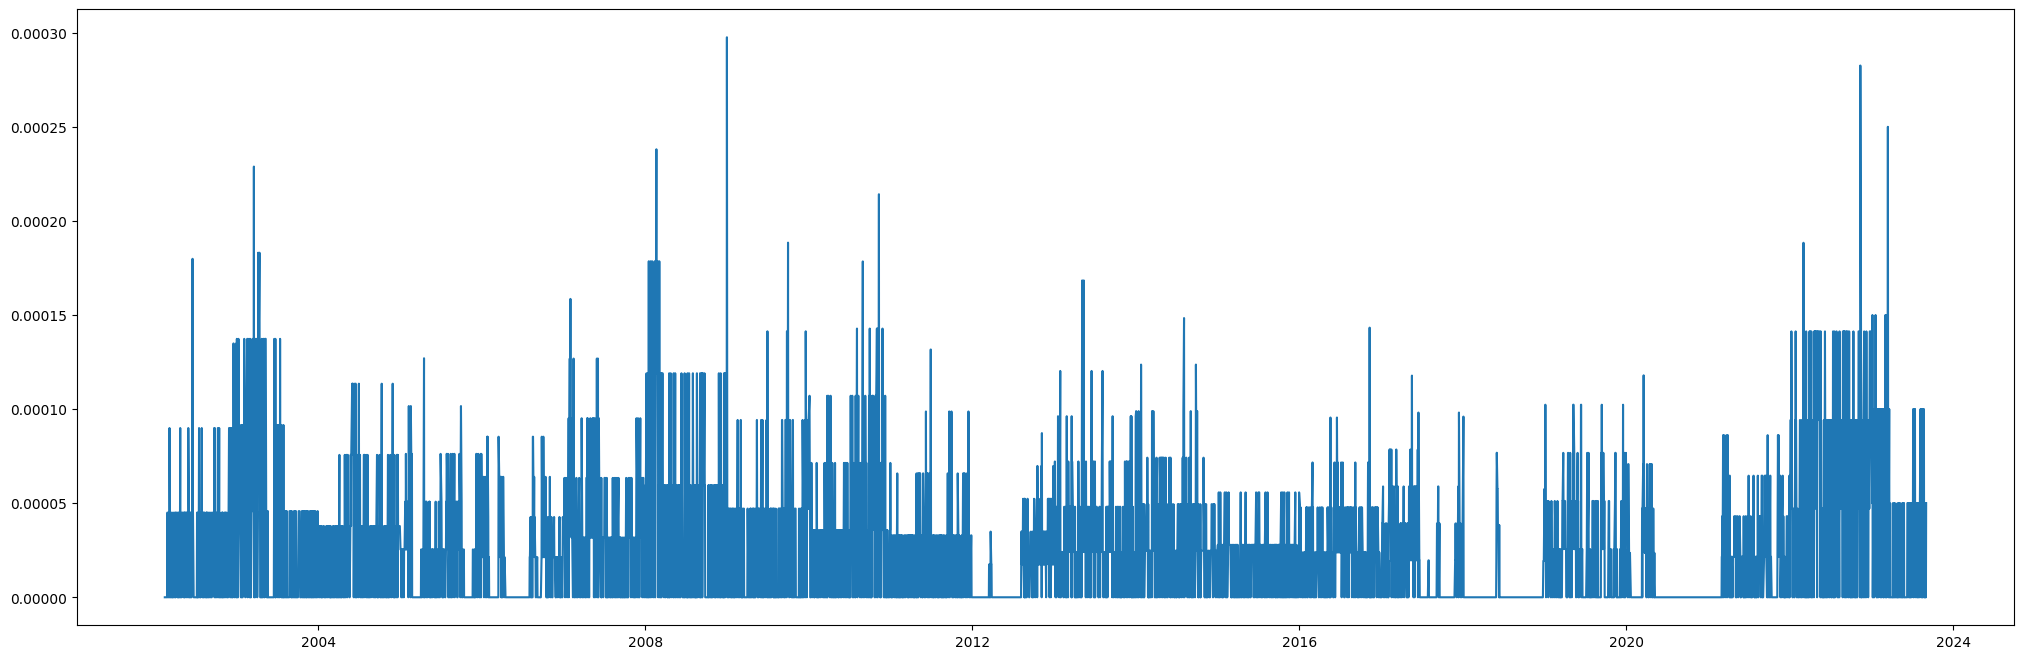

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(data_resampled_fi["FV1 Comdty"]['Costs'])

In [ ]:
fi_basket_strat={}
fi_basket_strat[f'Returns']=pd.DataFrame()
for ticker in fi:
  fi_basket_strat[f'Returns']=pd.concat([fi_basket_strat[f'Returns'],data_resampled_fi[ticker][f'{ticker}_Strategy']],axis=1)
n=len(fi_basket_strat[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=fi_basket_strat[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
fi_basket_strat[f'Returns'][f'BONDS_strategy_returns']=np.dot((optimal_W),fi_basket_strat[f'Returns'].values.T)
#fi_basket_strat[f'Returns'][f'BONDS_strategy_returns']=fi_basket_strat[f'Returns'][f'BONDS_strategy_returns']/norm_factor
basket_final=pd.concat([basket_final,fi_basket_strat[f'Returns'][f'BONDS_strategy_returns']],axis=1)
basket_final

BONDS_strategy_returns
2002-02-14                0.001610
2002-02-15               -0.001909
2002-02-19                0.001030
2002-02-20               -0.002053
2002-02-21                0.003041
...                            ...
2023-08-28               -0.001897
2023-08-29               -0.019039
2023-08-30               -0.000719
2023-08-31               -0.009641
2023-09-01                0.008625

[5435 rows x 1 columns]

In [ ]:
basket_final1=pd.DataFrame()

In [ ]:
fi_basket_strat1={}
fi_basket_strat1[f'Returns']=pd.DataFrame()
for ticker in fi:
  fi_basket_strat1[f'Returns']=pd.concat([fi_basket_strat1[f'Returns'],data_resampled_fi[ticker][f'{ticker}_Strategy1']],axis=1)
n=len(fi_basket_strat1[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=fi_basket_strat1[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
fi_basket_strat1[f'Returns'][f'BONDS_strategy_returns']=np.dot((optimal_W),fi_basket_strat1[f'Returns'].values.T)
#fi_basket_strat1[f'Returns'][f'BONDS_strategy_returns']=fi_basket_strat1[f'Returns'][f'BONDS_strategy_returns']/norm_factor
basket_final1=pd.concat([basket_final1,fi_basket_strat1[f'Returns'][f'BONDS_strategy_returns']],axis=1)
basket_final1

BONDS_strategy_returns
2002-02-14                     NaN
2002-02-15               -0.001909
2002-02-19                0.001030
2002-02-20               -0.002053
2002-02-21                0.003041
...                            ...
2023-08-28               -0.001897
2023-08-29               -0.019039
2023-08-30               -0.000720
2023-08-31               -0.009641
2023-09-01                0.008625

[5435 rows x 1 columns]

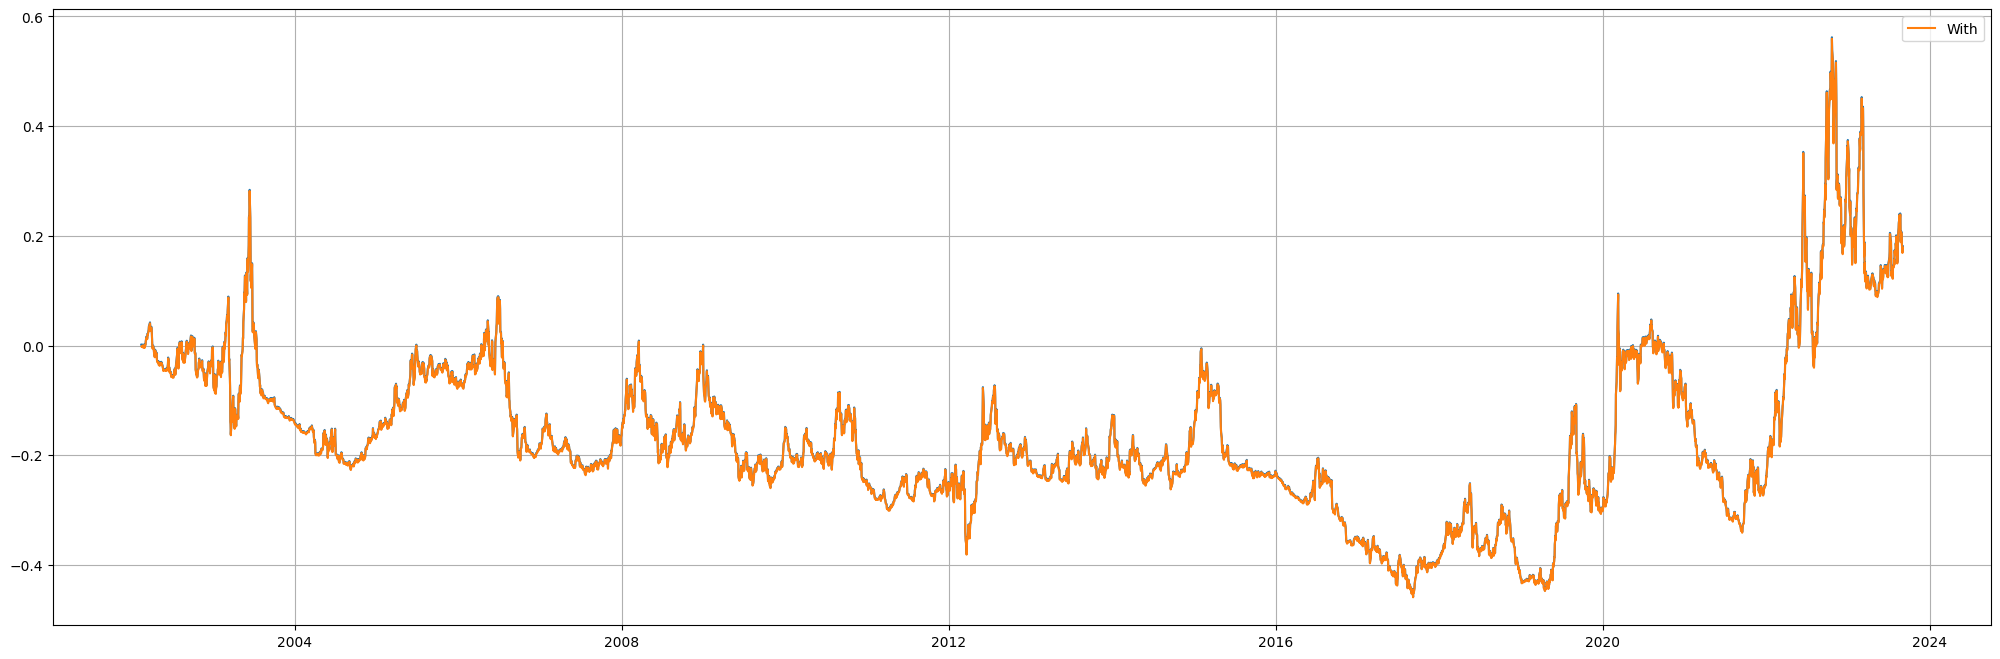

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+basket_final.loc[basket_final.index>pd.to_datetime('2002-01-01'),f'BONDS_strategy_returns'])-1)
plt.plot(np.cumprod(1+basket_final1.loc[basket_final1.index>pd.to_datetime('2002-01-01'),f'BONDS_strategy_returns'])-1,label='With')
plt.grid()
plt.legend()

In [ ]:
np.cumprod(1+basket_final.loc[basket_final.index>pd.to_datetime('2002-01-01'),f'BONDS_strategy_returns'])-1

2002-02-14    0.001610
2002-02-15   -0.000302
2002-02-19    0.000728
2002-02-20   -0.001327
2002-02-21    0.001710
                ...   
2023-08-28    0.205975
2023-08-29    0.183014
2023-08-30    0.182162
2023-08-31    0.170765
2023-09-01    0.180862
Name: BONDS_strategy_returns, Length: 5435, dtype: float64

In [ ]:
np.cumprod(1+basket_final1.loc[basket_final1.index>pd.to_datetime('2002-01-01'),f'BONDS_strategy_returns'])-1

2002-02-14         NaN
2002-02-15   -0.001909
2002-02-19   -0.000881
2002-02-20   -0.002933
2002-02-21    0.000099
                ...   
2023-08-28    0.203908
2023-08-29    0.180987
2023-08-30    0.180137
2023-08-31    0.168759
2023-09-01    0.178839
Name: BONDS_strategy_returns, Length: 5435, dtype: float64

In [ ]:
data_resampled_agri={}
data_agri={}
portfolio_df=pd.DataFrame()
fp1=pd.DataFrame()
list_vol=[]

for ticker in agri:
  #data consolidation
  data_agri[ticker]=pd.DataFrame(agri_p.loc[:,ticker])
  data_resampled_agri[ticker] = data_agri[ticker]
  data_resampled_agri[ticker][f'Daily Returns_lag{1}']=data_resampled_agri[ticker][ticker].shift(1)
  data_resampled_agri[ticker][f'Daily Returns_lag{20}']=(data_resampled_agri[ticker][f'Daily Returns_lag{1}']).rolling(window=20).mean()
  data_resampled_agri[ticker][f'Vol']=calc_vol(data_resampled_agri[ticker][f'Daily Returns_lag{1}'])['Vol']

  data_resampled_agri[ticker][f'Daily_signal_lag{20}']=(data_resampled_agri[ticker][f'Daily Returns_lag{20}']/(data_resampled_agri[ticker][f'Vol']))*np.sqrt(20)
  data_resampled_agri[ticker][f'Daily_signal_lag_norm{20}'] = np.clip(data_resampled_agri[ticker][f'Daily_signal_lag{20}'], -2, 2)
  #Gearing for the short term trend
  data_resampled_agri[ticker][f'gearing_20']=0.08/(np.sqrt(252)*data_resampled_agri[ticker][f'Vol'])

  #Gearing for the combined signal
  data_resampled_agri[ticker][f'gearing'] = 0.3/(np.sqrt(252)*data_resampled_agri[ticker][f'Vol'])

  #Gearing up the short term signal
  data_resampled_agri[ticker][f'Daily_signal_lag_norm{20}']=data_resampled_agri[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_agri[ticker][f'gearing_20']

  for i in lags:
    data_resampled_agri[ticker][f'Daily Returns_lag{i}']=(data_resampled_agri[ticker][f'Daily Returns_lag{1}']).rolling(window=i).mean()
  data_resampled_agri[ticker]=data_resampled_agri[ticker].dropna()

  #Calculating Signals
  for i in lags:
    data_resampled_agri[ticker][f'Daily_signal_lag{i}']=(data_resampled_agri[ticker][f'Daily Returns_lag{i}']/(data_resampled_agri[ticker][f'Vol']))*np.sqrt(i)
    data_resampled_agri[ticker][f'Daily_signal_lag_norm{i}'] = np.clip(data_resampled_agri[ticker][f'Daily_signal_lag{i}'], -2, 2)



  #Combining the signal
  cs=pd.DataFrame(data_resampled_agri[ticker][f'Daily_signal_lag_norm{lags[0]}']*optimal_weights[0]+data_resampled_agri[ticker][f'Daily_signal_lag_norm{lags[1]}']*optimal_weights[1]+data_resampled_agri[ticker][f'Daily_signal_lag_norm{lags[2]}']*optimal_weights[2]+data_resampled_agri[ticker][f'Daily_signal_lag_norm{lags[3]}']*optimal_weights[3]+data_resampled_agri[ticker][f'Daily_signal_lag_norm{lags[4]}']*optimal_weights[4],columns=['Final Signal'])

  cs=signal_boost(cs,vix_f)
  data_resampled_agri[ticker]=pd.concat([data_resampled_agri[ticker],cs],axis=1)

  #Gearing up the final signal
  data_resampled_agri[ticker][f'Final Signal']=data_resampled_agri[ticker][f'Final Signal']*data_resampled_agri[ticker][f'gearing']
  data_resampled_agri[ticker][f'Final Signal']=np.round(np.clip(data_resampled_agri[ticker][f'Final Signal'], -15, 15))
  data_resampled_agri[ticker]['Costs']=[costs[ticker]]*len(data_resampled_agri[ticker])
  for i in data_resampled_agri[ticker].index.year.unique():
    data_resampled_agri[ticker].loc[data_resampled_agri[ticker].index.year==i,'Costs']=data_resampled_agri[ticker].loc[data_resampled_agri[ticker].index.year==i,'Costs']*((data_resampled_agri[ticker].loc[data_resampled_agri[ticker].index.year==i,ticker].std()*np.sqrt(252))/(data_resampled_agri[ticker].loc[data_resampled_agri[ticker].index.year==2023,ticker].std()*np.sqrt(252)))
  data_resampled_agri[ticker]['Costs']=data_resampled_agri[ticker]['Costs']*((data_resampled_agri[ticker][f'Final Signal']).diff().abs())
  #Replacing the signal

  #Response Function
  data_resampled_agri[ticker][f'{ticker}_Strategy']=data_resampled_agri[ticker]['Final Signal']*data_resampled_agri[ticker][ticker]
  data_resampled_agri[ticker][f'{ticker}_Strategy1']=data_resampled_agri[ticker]['Final Signal']*data_resampled_agri[ticker][ticker]-data_resampled_agri[ticker]['Costs']

  #Storing the signal
  signals[ticker]=data_resampled_agri[ticker][['Final Signal',f'{ticker}','gearing',f'{ticker}_Strategy']]

In [ ]:
  #Autocorrelation adjustment
  data_resampled_agri[ticker][f'{ticker}_Strategy_{20}']=data_resampled_agri[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_agri[ticker][ticker]
  data_resampled_agri[ticker][f'{ticker}_ACF_{20}']=data_resampled_agri[ticker][f'{ticker}_Strategy_{20}'].rolling(10).apply(lambda x: x.autocorr(), raw=False)
  mean_value = data_resampled_agri[ticker][f'{ticker}_ACF_{20}'].mean()
  std_dev = data_resampled_agri[ticker][f'{ticker}_ACF_{20}'].std()
  #Normalising the autocorrelation
  data_resampled_agri[ticker][f'{ticker}_ACF_{20}'] = (data_resampled_agri[ticker][f'{ticker}_ACF_{20}'] - mean_value) / std_dev
  data_resampled_agri[ticker][f'{ticker}_ACF_{20}']=data_resampled_agri[ticker][f'{ticker}_ACF_{20}'].shift(1)

#Replacing the signal
for i in data_resampled_agri[ticker].index:
  if(np.sign(data_resampled_agri[ticker].loc[i,f'{ticker}_ACF_{20}'])==1.0):
    data_resampled_agri[ticker].at[i,f'Final Signal']=1.5*data_resampled_agri[ticker].loc[i,f'Daily_signal_lag_norm{20}']
data_resampled_agri[ticker][f'{ticker}_Strategy'] = data_resampled_agri[ticker][f'Final Signal']*data_resampled_agri[ticker][ticker]



  data_resampled_agri[ticker]['Pos Ret']=(data_resampled_agri[ticker][f'{ticker}_Strategy']>0).astype(int)
  data_resampled_agri[ticker]['Rolling_Pos']=data_resampled_agri[ticker]['Pos Ret'].rolling(window=20).sum()
  data_resampled_agri[ticker]['Roll_Win_Ratio']=data_resampled_agri[ticker]['Rolling_Pos']/20
  data_resampled_agri[ticker]['Roll_Win_Ratio']=data_resampled_agri[ticker]['Roll_Win_Ratio'].shift(1)
  data_resampled_agri[ticker]=data_resampled_agri[ticker].dropna()
  data_resampled_agri[ticker]['Confidence']=np.where(data_resampled_agri[ticker]['Roll_Win_Ratio']<0.6,sigmoid(data_resampled_agri[ticker]['Roll_Win_Ratio']),1)
  data_resampled_agri[ticker][f'{ticker}_Strategy']=data_resampled_agri[ticker]['Final Signal']*data_resampled_agri[ticker]['Confidence']*data_resampled_agri[ticker][ticker]

In [ ]:
agri_basket_strat={}
agri_basket_strat[f'Returns']=pd.DataFrame()
for ticker in agri:
  agri_basket_strat[f'Returns']=pd.concat([agri_basket_strat[f'Returns'],data_resampled_agri[ticker][f'{ticker}_Strategy']],axis=1)
n=len(agri_basket_strat[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=agri_basket_strat[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
agri_basket_strat[f'Returns'][f'AGRI_strategy_returns']=np.dot((optimal_W),agri_basket_strat[f'Returns'].values.T)
#agri_basket_strat[f'Returns'][f'AGRI_strategy_returns']=agri_basket_strat[f'Returns'][f'AGRI_strategy_returns']/norm_factor
basket_final=pd.concat([basket_final,agri_basket_strat[f'Returns'][f'AGRI_strategy_returns']],axis=1)
basket_final

BONDS_strategy_returns  AGRI_strategy_returns
2002-02-14                0.001610              -0.001959
2002-02-15               -0.001909               0.004814
2002-02-19                0.001030               0.004399
2002-02-20               -0.002053              -0.004447
2002-02-21                0.003041               0.005709
...                            ...                    ...
2023-08-28               -0.001897               0.008018
2023-08-29               -0.019039               0.014366
2023-08-30               -0.000719               0.000278
2023-08-31               -0.009641               0.002135
2023-09-01                0.008625              -0.004696

[5435 rows x 2 columns]

In [ ]:
agri_basket_strat1={}
agri_basket_strat1[f'Returns']=pd.DataFrame()
for ticker in agri:
  agri_basket_strat1[f'Returns']=pd.concat([agri_basket_strat1[f'Returns'],data_resampled_agri[ticker][f'{ticker}_Strategy1']],axis=1)
n=len(agri_basket_strat1[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=agri_basket_strat1[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
agri_basket_strat1[f'Returns'][f'AGRI_strategy_returns']=np.dot((optimal_W),agri_basket_strat1[f'Returns'].values.T)
#agri_basket_strat1[f'Returns'][f'AGRI_strategy_returns']=agri_basket_strat1[f'Returns'][f'AGRI_strategy_returns']/norm_factor
basket_final1=pd.concat([basket_final1,agri_basket_strat1[f'Returns'][f'AGRI_strategy_returns']],axis=1)
basket_final1

BONDS_strategy_returns  AGRI_strategy_returns
2002-02-14                     NaN                    NaN
2002-02-15               -0.001922               0.004814
2002-02-19                0.001008               0.004373
2002-02-20               -0.002080              -0.004474
2002-02-21                0.003041               0.005709
...                            ...                    ...
2023-08-28               -0.001931               0.007988
2023-08-29               -0.019039               0.014366
2023-08-30               -0.000754               0.000278
2023-08-31               -0.009648               0.002134
2023-09-01                0.008605              -0.004826

[5435 rows x 2 columns]

In [ ]:
basket_final[f'AGRI_strategy_returns'].std()*np.sqrt(252)

0.139411340947798

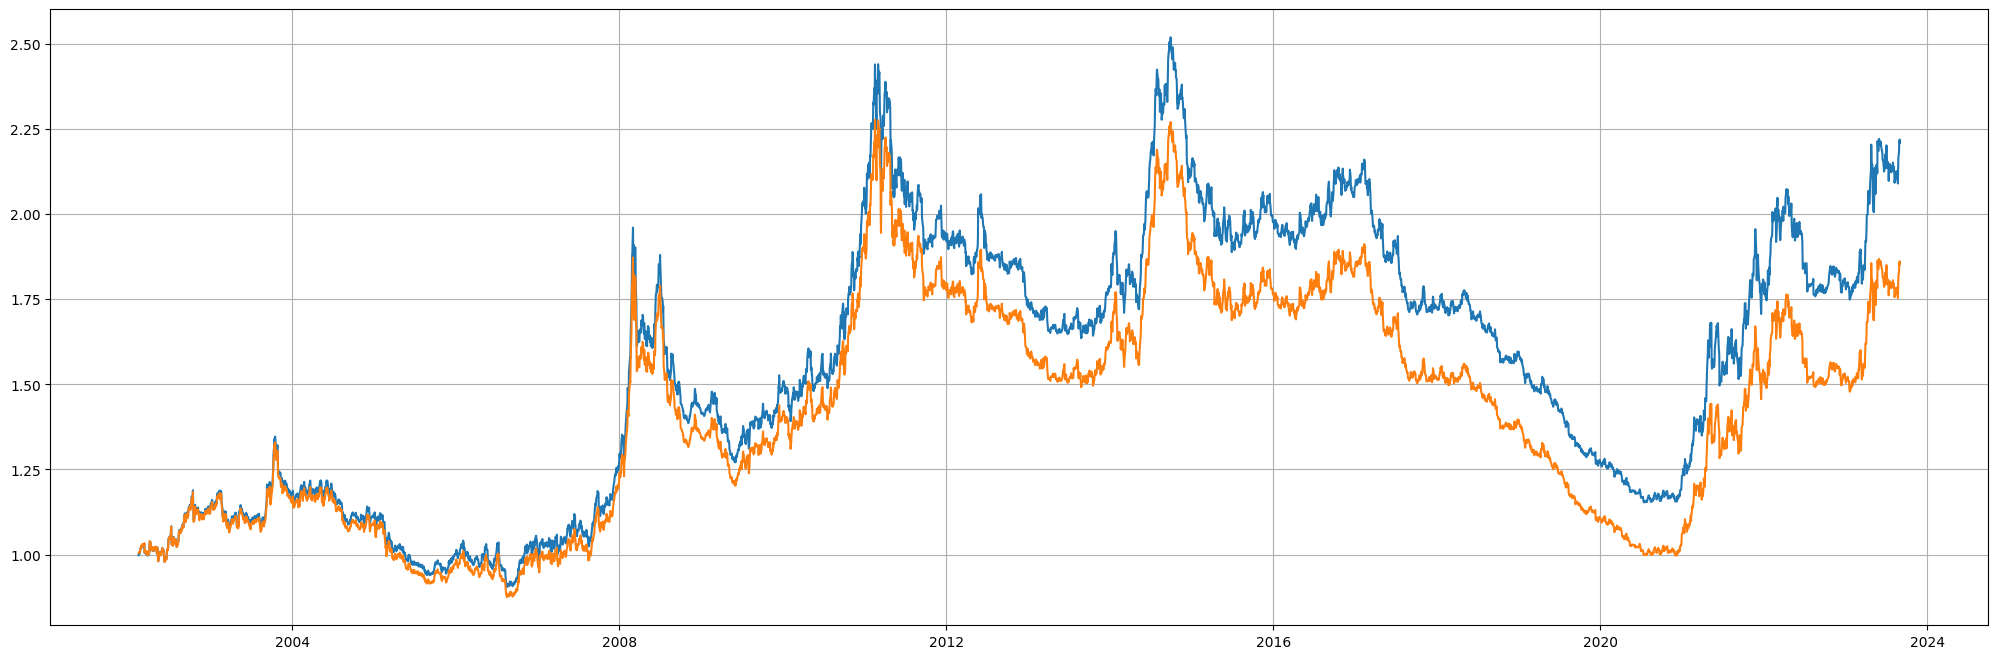

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+basket_final[f'AGRI_strategy_returns']))
plt.plot(np.cumprod(1+basket_final1[f'AGRI_strategy_returns']))
plt.grid()

In [ ]:
basket_final[f'AGRI_strategy_returns'].std()*np.sqrt(252)

0.13746800731680034

In [ ]:
data_resampled_ener={}
data_ener={}
portfolio_df=pd.DataFrame()
fp1=pd.DataFrame()
list_vol=[]

for ticker in ener:
  #data consolidation
  data_ener[ticker]=pd.DataFrame(ener_p.loc[:,ticker])
  data_resampled_ener[ticker] = data_ener[ticker]
  data_resampled_ener[ticker][f'Daily Returns_lag{1}']=data_resampled_ener[ticker][ticker].shift(1)
  data_resampled_ener[ticker][f'Daily Returns_lag{20}']=(data_resampled_ener[ticker][f'Daily Returns_lag{1}']).rolling(window=20).mean()
  data_resampled_ener[ticker][f'Vol']=calc_vol(data_resampled_ener[ticker][f'Daily Returns_lag{1}'])['Vol']

  data_resampled_ener[ticker][f'Daily_signal_lag{20}']=(data_resampled_ener[ticker][f'Daily Returns_lag{20}']/(data_resampled_ener[ticker][f'Vol']))*np.sqrt(20)
  data_resampled_ener[ticker][f'Daily_signal_lag_norm{20}'] = np.clip(data_resampled_ener[ticker][f'Daily_signal_lag{20}'], -2, 2)
  #Gearing for the short term trend
  data_resampled_ener[ticker][f'gearing_20']=0.08/(np.sqrt(252)*data_resampled_ener[ticker][f'Vol'])

  #Gearing for the combined signal
  data_resampled_ener[ticker][f'gearing'] = 0.3/(np.sqrt(252)*data_resampled_ener[ticker][f'Vol'])

  #Gearing up the short term signal
  data_resampled_ener[ticker][f'Daily_signal_lag_norm{20}']=data_resampled_ener[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_ener[ticker][f'gearing_20']

  for i in lags:
    data_resampled_ener[ticker][f'Daily Returns_lag{i}']=(data_resampled_ener[ticker][f'Daily Returns_lag{1}']).rolling(window=i).mean()
  data_resampled_ener[ticker]=data_resampled_ener[ticker].dropna()

  #Calculating Signals
  for i in lags:
    data_resampled_ener[ticker][f'Daily_signal_lag{i}']=(data_resampled_ener[ticker][f'Daily Returns_lag{i}']/(data_resampled_ener[ticker][f'Vol']))*np.sqrt(i)
    data_resampled_ener[ticker][f'Daily_signal_lag_norm{i}'] = np.clip(data_resampled_ener[ticker][f'Daily_signal_lag{i}'], -2, 2)


  #Combining the signal
  cs=pd.DataFrame(data_resampled_ener[ticker][f'Daily_signal_lag_norm{lags[0]}']*optimal_weights[0]+data_resampled_ener[ticker][f'Daily_signal_lag_norm{lags[1]}']*optimal_weights[1]+data_resampled_ener[ticker][f'Daily_signal_lag_norm{lags[2]}']*optimal_weights[2]+data_resampled_ener[ticker][f'Daily_signal_lag_norm{lags[3]}']*optimal_weights[3]+data_resampled_ener[ticker][f'Daily_signal_lag_norm{lags[4]}']*optimal_weights[4],columns=['Final Signal'])

  cs=signal_boost(cs,vix_f)
  data_resampled_ener[ticker]=pd.concat([data_resampled_ener[ticker],cs],axis=1)

  #Gearing up the final signal
  data_resampled_ener[ticker][f'Final Signal']=data_resampled_ener[ticker][f'Final Signal']*data_resampled_ener[ticker][f'gearing']
  data_resampled_ener[ticker][f'Final Signal']=np.round(np.clip(data_resampled_ener[ticker][f'Final Signal'], -15, 15))
  data_resampled_ener[ticker]['Costs']=[costs[ticker]]*len(data_resampled_ener[ticker])
  for i in data_resampled_ener[ticker].index.year.unique():
    data_resampled_ener[ticker].loc[data_resampled_ener[ticker].index.year==i,'Costs']=data_resampled_ener[ticker].loc[data_resampled_ener[ticker].index.year==i,'Costs']*((data_resampled_ener[ticker].loc[data_resampled_ener[ticker].index.year==i,ticker].std()*np.sqrt(252))/(data_resampled_ener[ticker].loc[data_resampled_ener[ticker].index.year==2023,ticker].std()*np.sqrt(252)))
  data_resampled_ener[ticker]['Costs']=data_resampled_ener[ticker]['Costs']*((data_resampled_ener[ticker][f'Final Signal']).diff().abs())

  data_resampled_ener[ticker][f'{ticker}_Strategy'] = data_resampled_ener[ticker][f'Final Signal']*data_resampled_ener[ticker][ticker]
  data_resampled_ener[ticker][f'{ticker}_Strategy1'] = data_resampled_ener[ticker][f'Final Signal']*data_resampled_ener[ticker][ticker]-data_resampled_ener[ticker]['Costs']
  #Storing the signal
  signals[ticker]=data_resampled_ener[ticker][['Final Signal',f'{ticker}','gearing',f'{ticker}_Strategy']]

In [ ]:

#Autocorrelation adjustment
  data_resampled_ener[ticker][f'{ticker}_Strategy_{20}']=data_resampled_ener[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_ener[ticker][ticker]
  data_resampled_ener[ticker][f'{ticker}_ACF_{20}']=data_resampled_ener[ticker][f'{ticker}_Strategy_{20}'].rolling(10).apply(lambda x: x.autocorr(), raw=False)
  mean_value = data_resampled_ener[ticker][f'{ticker}_ACF_{20}'].mean()
  std_dev = data_resampled_ener[ticker][f'{ticker}_ACF_{20}'].std()
  #Normalising the autocorrelation
  data_resampled_ener[ticker][f'{ticker}_ACF_{20}'] = (data_resampled_ener[ticker][f'{ticker}_ACF_{20}'] - mean_value) / std_dev
  data_resampled_ener[ticker][f'{ticker}_ACF_{20}']=data_resampled_ener[ticker][f'{ticker}_ACF_{20}'].shift(1)

   #Replacing the signal
  for i in data_resampled_ener[ticker].index:
    if(np.sign(data_resampled_ener[ticker].loc[i,f'{ticker}_ACF_{20}'])==1.0):
      data_resampled_ener[ticker].at[i,f'Final Signal']=1.5*data_resampled_ener[ticker].loc[i,f'Daily_signal_lag_norm{20}']

In [ ]:
ener_basket_strat={}
ener_basket_strat[f'Returns']=pd.DataFrame()
for ticker in ener:
  ener_basket_strat[f'Returns']=pd.concat([ener_basket_strat[f'Returns'],data_resampled_ener[ticker][f'{ticker}_Strategy']],axis=1)
n=len(ener_basket_strat[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=ener_basket_strat[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
ener_basket_strat[f'Returns'][f'ENER_strategy_returns']=np.dot((optimal_W),ener_basket_strat[f'Returns'].values.T)
#ener_basket_strat[f'Returns'][f'ENER_strategy_returns']=ener_basket_strat[f'Returns'][f'ENER_strategy_returns']/norm_factor
basket_final=pd.concat([basket_final,ener_basket_strat[f'Returns'][f'ENER_strategy_returns']],axis=1)
basket_final

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                0.001610              -0.001959   
2002-02-15               -0.001909               0.004814   
2002-02-19                0.001030               0.004399   
2002-02-20               -0.002053              -0.004447   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001897               0.008018   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000719               0.000278   
2023-08-31               -0.009641               0.002135   
2023-09-01                0.008625              -0.004696   

            ENER_strategy_returns  
2002-02-14               0.004236  
2002-02-15              -0.002987  
2002-02-19              -0.018525  
2002-02-20               0.017355  
2002-02-21              -0.026097  
...                           ...  
2023-08-28              -0.009843  
2023-08-29               0.000225  
2023-08-30              -0.010068  
2023-08-31               0.002003  
2023-09-01              -0.008435  

[5435 rows x 3 columns]

In [ ]:
ener_basket_strat1={}
ener_basket_strat1[f'Returns']=pd.DataFrame()
for ticker in ener:
  ener_basket_strat1[f'Returns']=pd.concat([ener_basket_strat1[f'Returns'],data_resampled_ener[ticker][f'{ticker}_Strategy1']],axis=1)
n=len(ener_basket_strat1[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=ener_basket_strat1[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
ener_basket_strat1[f'Returns'][f'ENER_strategy_returns']=np.dot((optimal_W),ener_basket_strat1[f'Returns'].values.T)
#ener_basket_strat1[f'Returns'][f'ENER_strategy_returns']=ener_basket_strat1[f'Returns'][f'ENER_strategy_returns']/norm_factor
basket_final1=pd.concat([basket_final1,ener_basket_strat1[f'Returns'][f'ENER_strategy_returns']],axis=1)
basket_final1

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                     NaN                    NaN   
2002-02-15               -0.001922               0.004814   
2002-02-19                0.001008               0.004373   
2002-02-20               -0.002080              -0.004474   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001931               0.007988   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000754               0.000278   
2023-08-31               -0.009648               0.002134   
2023-09-01                0.008605              -0.004826   

            ENER_strategy_returns  
2002-02-14                    NaN  
2002-02-15              -0.002987  
2002-02-19              -0.018608  
2002-02-20               0.017272  
2002-02-21              -0.026122  
...                           ...  
2023-08-28              -0.009869  
2023-08-29               0.000225  
2023-08-30              -0.010068  
2023-08-31               0.002003  
2023-09-01              -0.008487  

[5435 rows x 3 columns]

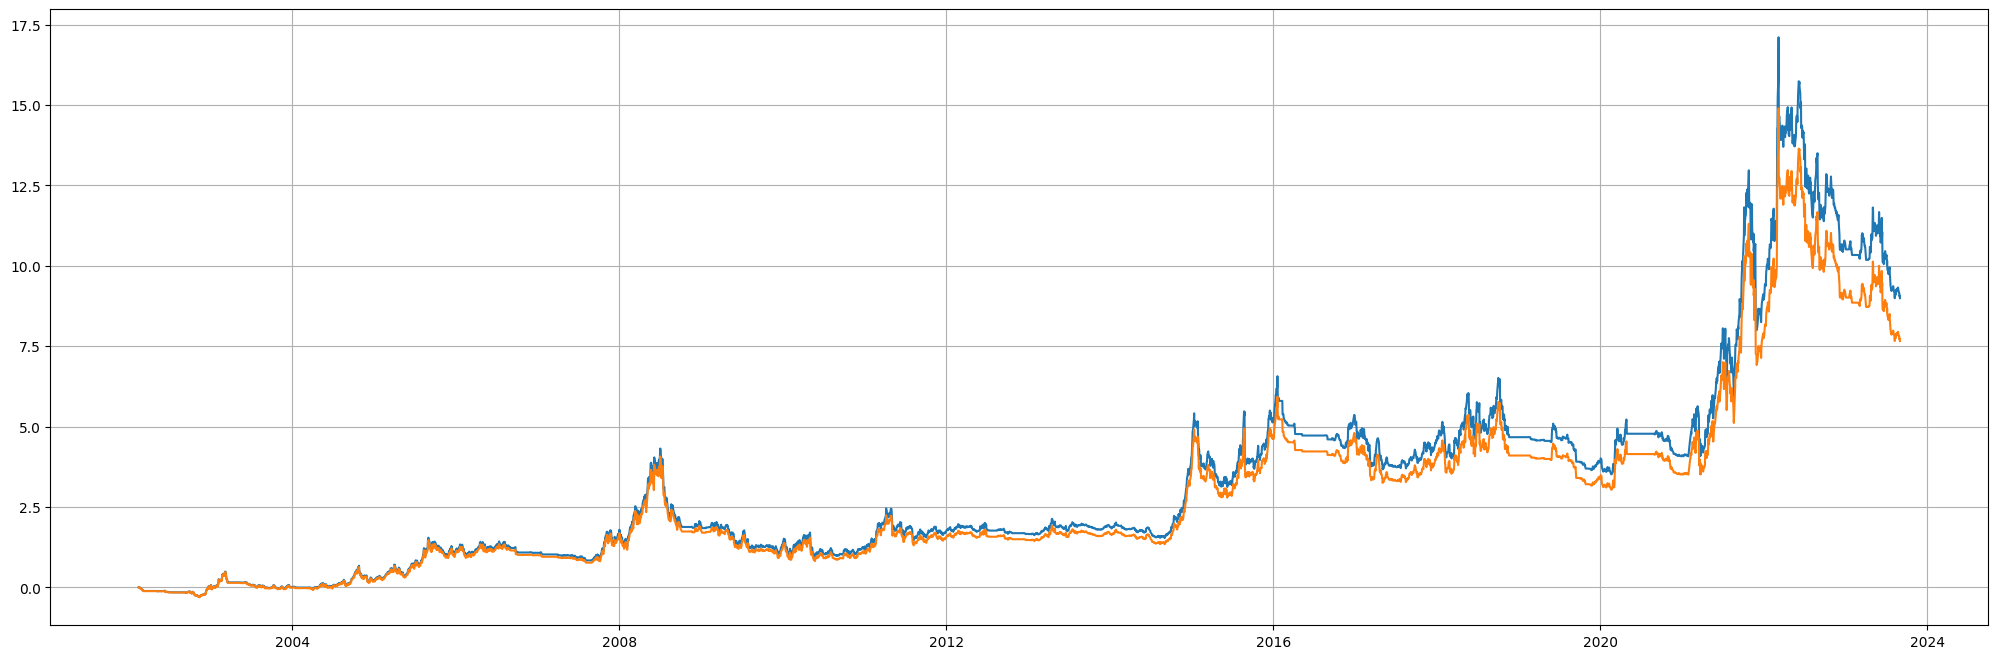

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+basket_final[f'ENER_strategy_returns'])-1)
plt.plot(np.cumprod(1+basket_final1[f'ENER_strategy_returns'])-1)
plt.grid()

In [ ]:
basket_final1[f'ENER_strategy_returns'].std()*np.sqrt(252)

0.30133852545811374

In [ ]:
data_resampled_met={}
data_met={}
portfolio_df=pd.DataFrame()
fp1=pd.DataFrame()
list_vol=[]

for ticker in met:
  #data consolidation
  data_met[ticker]=pd.DataFrame(met_p.loc[:,ticker])
  data_resampled_met[ticker] = data_met[ticker]
  data_resampled_met[ticker][f'Daily Returns_lag{1}']=data_resampled_met[ticker][ticker].shift(1)
  data_resampled_met[ticker][f'Daily Returns_lag{20}']=(data_resampled_met[ticker][f'Daily Returns_lag{1}']).rolling(window=20).mean()
  data_resampled_met[ticker][f'Vol']=calc_vol(data_resampled_met[ticker][f'Daily Returns_lag{1}'])['Vol']

  data_resampled_met[ticker][f'Daily_signal_lag{20}']=(data_resampled_met[ticker][f'Daily Returns_lag{20}']/(data_resampled_met[ticker][f'Vol']))*np.sqrt(20)
  data_resampled_met[ticker][f'Daily_signal_lag_norm{20}'] = np.clip(data_resampled_met[ticker][f'Daily_signal_lag{20}'], -2, 2)
  #Gearing for the short term trend
  data_resampled_met[ticker][f'gearing_20']=0.08/(np.sqrt(252)*data_resampled_met[ticker][f'Vol'])

  #Gearing for the combined signal
  data_resampled_met[ticker][f'gearing'] = 0.3/(np.sqrt(252)*data_resampled_met[ticker][f'Vol'])

  #Gearing up the short term signal
  data_resampled_met[ticker][f'Daily_signal_lag_norm{20}']=data_resampled_met[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_met[ticker][f'gearing_20']

  for i in lags:
    data_resampled_met[ticker][f'Daily Returns_lag{i}']=(data_resampled_met[ticker][f'Daily Returns_lag{1}']).rolling(window=i).mean()
  data_resampled_met[ticker]=data_resampled_met[ticker].dropna()

  #Calculating Signals
  for i in lags:
    data_resampled_met[ticker][f'Daily_signal_lag{i}']=(data_resampled_met[ticker][f'Daily Returns_lag{i}']/(data_resampled_met[ticker][f'Vol']))*np.sqrt(i)
    data_resampled_met[ticker][f'Daily_signal_lag_norm{i}'] = np.clip(data_resampled_met[ticker][f'Daily_signal_lag{i}'], -2, 2)


  #Combining the signal
  cs=pd.DataFrame(data_resampled_met[ticker][f'Daily_signal_lag_norm{lags[0]}']*optimal_weights[0]+data_resampled_met[ticker][f'Daily_signal_lag_norm{lags[1]}']*optimal_weights[1]+data_resampled_met[ticker][f'Daily_signal_lag_norm{lags[2]}']*optimal_weights[2]+data_resampled_met[ticker][f'Daily_signal_lag_norm{lags[3]}']*optimal_weights[3]+data_resampled_met[ticker][f'Daily_signal_lag_norm{lags[4]}']*optimal_weights[4],columns=['Final Signal'])

  cs=signal_boost2(cs,vix_f)
  data_resampled_met[ticker]=pd.concat([data_resampled_met[ticker],cs],axis=1)

  #Gearing up the final signal
  data_resampled_met[ticker][f'Final Signal']=data_resampled_met[ticker][f'Final Signal']*data_resampled_met[ticker][f'gearing']
  data_resampled_met[ticker][f'Final Signal']=np.round(np.clip(data_resampled_met[ticker][f'Final Signal'], -15, 15))
  data_resampled_met[ticker]['Costs']=[costs[ticker]]*len(data_resampled_met[ticker])
  for i in data_resampled_met[ticker].index.year.unique():
    data_resampled_met[ticker].loc[data_resampled_met[ticker].index.year==i,'Costs']=data_resampled_met[ticker].loc[data_resampled_met[ticker].index.year==i,'Costs']*((data_resampled_met[ticker].loc[data_resampled_met[ticker].index.year==i,ticker].std()*np.sqrt(252))/(data_resampled_met[ticker].loc[data_resampled_met[ticker].index.year==2023,ticker].std()*np.sqrt(252)))
  data_resampled_met[ticker]['Costs']=data_resampled_met[ticker]['Costs']*((data_resampled_met[ticker][f'Final Signal']).diff().abs())

  #Replacing the signal


  data_resampled_met[ticker][f'{ticker}_Strategy'] = data_resampled_met[ticker][f'Final Signal']*data_resampled_met[ticker][ticker]
  data_resampled_met[ticker][f'{ticker}_Strategy1'] = data_resampled_met[ticker][f'Final Signal']*data_resampled_met[ticker][ticker]-data_resampled_met[ticker]['Costs']

  #Storing the signal
  signals[ticker]=data_resampled_met[ticker][['Final Signal',f'{ticker}','gearing',f'{ticker}_Strategy']]

In [ ]:
 #Autocorrelation adjustment
  data_resampled_met[ticker][f'{ticker}_Strategy_{20}']=data_resampled_met[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_met[ticker][ticker]
  data_resampled_met[ticker][f'{ticker}_ACF_{20}']=data_resampled_met[ticker][f'{ticker}_Strategy_{20}'].rolling(10).apply(lambda x: x.autocorr(), raw=False)
  mean_value = data_resampled_met[ticker][f'{ticker}_ACF_{20}'].mean()
  std_dev = data_resampled_met[ticker][f'{ticker}_ACF_{20}'].std()
  #Normalising the autocorrelation
  data_resampled_met[ticker][f'{ticker}_ACF_{20}'] = (data_resampled_met[ticker][f'{ticker}_ACF_{20}'] - mean_value) / std_dev
  data_resampled_met[ticker][f'{ticker}_ACF_{20}']=data_resampled_met[ticker][f'{ticker}_ACF_{20}'].shift(1)

  for i in data_resampled_met[ticker].index:
    if(np.sign(data_resampled_met[ticker].loc[i,f'{ticker}_ACF_{20}'])==1.0):
      data_resampled_met[ticker].at[i,f'Final Signal']=1.5*data_resampled_met[ticker].loc[i,f'Daily_signal_lag_norm{20}']

data_resampled_met[ticker]['Pos Ret']=(data_resampled_met[ticker][f'{ticker}_Strategy']>0).astype(int)
data_resampled_met[ticker]['Rolling_Pos']=data_resampled_met[ticker]['Pos Ret'].rolling(window=20).sum()
data_resampled_met[ticker]['Roll_Win_Ratio']=data_resampled_met[ticker]['Rolling_Pos']/20
data_resampled_met[ticker]['Roll_Win_Ratio']=data_resampled_met[ticker]['Roll_Win_Ratio'].shift(1)
data_resampled_met[ticker]=data_resampled_met[ticker].dropna()
data_resampled_met[ticker]['Confidence']=np.where(data_resampled_met[ticker]['Roll_Win_Ratio']<0.6,sigmoid(data_resampled_met[ticker]['Roll_Win_Ratio']),1)
data_resampled_met[ticker][f'{ticker}_Strategy']=data_resampled_met[ticker]['Final Signal']*data_resampled_met[ticker]['Confidence']*data_resampled_met[ticker][ticker]

In [ ]:
met_basket_strat={}
met_basket_strat[f'Returns']=pd.DataFrame()
for ticker in met:
  met_basket_strat[f'Returns']=pd.concat([met_basket_strat[f'Returns'],data_resampled_met[ticker][f'{ticker}_Strategy']],axis=1)
n=len(met_basket_strat[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=met_basket_strat[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
met_basket_strat[f'Returns'][f'MET_strategy_returns']=np.dot((optimal_W),met_basket_strat[f'Returns'].values.T)
#met_basket_strat[f'Returns'][f'MET_strategy_returns']=met_basket_strat[f'Returns'][f'MET_strategy_returns']/norm_factor
basket_final=pd.concat([basket_final,met_basket_strat[f'Returns'][f'MET_strategy_returns']],axis=1)
basket_final

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                0.001610              -0.001959   
2002-02-15               -0.001909               0.004814   
2002-02-19                0.001030               0.004399   
2002-02-20               -0.002053              -0.004447   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001897               0.008018   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000719               0.000278   
2023-08-31               -0.009641               0.002135   
2023-09-01                0.008625              -0.004696   

            ENER_strategy_returns  MET_strategy_returns  
2002-02-14               0.004236             -0.002543  
2002-02-15              -0.002987              0.007230  
2002-02-19              -0.018525              0.008941  
2002-02-20               0.017355              0.003459  
2002-02-21              -0.026097             -0.009302  
...                           ...                   ...  
2023-08-28              -0.009843              0.004784  
2023-08-29               0.000225              0.011719  
2023-08-30              -0.010068              0.006487  
2023-08-31               0.002003             -0.006676  
2023-09-01              -0.008435             -0.006994  

[5435 rows x 4 columns]

In [ ]:
met_basket_strat1={}
met_basket_strat1[f'Returns']=pd.DataFrame()
for ticker in met:
  met_basket_strat1[f'Returns']=pd.concat([met_basket_strat1[f'Returns'],data_resampled_met[ticker][f'{ticker}_Strategy1']],axis=1)
n=len(met_basket_strat1[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=met_basket_strat1[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
met_basket_strat1[f'Returns'][f'MET_strategy_returns']=np.dot((optimal_W),met_basket_strat1[f'Returns'].values.T)
#met_basket_strat1[f'Returns'][f'MET_strategy_returns']=met_basket_strat1[f'Returns'][f'MET_strategy_returns']/norm_factor
basket_final1=pd.concat([basket_final1,met_basket_strat1[f'Returns'][f'MET_strategy_returns']],axis=1)
basket_final1

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                     NaN                    NaN   
2002-02-15               -0.001922               0.004814   
2002-02-19                0.001008               0.004373   
2002-02-20               -0.002080              -0.004474   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001931               0.007988   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000754               0.000278   
2023-08-31               -0.009648               0.002134   
2023-09-01                0.008605              -0.004826   

            ENER_strategy_returns  MET_strategy_returns  
2002-02-14                    NaN                   NaN  
2002-02-15              -0.002987              0.007187  
2002-02-19              -0.018608              0.008896  
2002-02-20               0.017272              0.003459  
2002-02-21              -0.026122             -0.009302  
...                           ...                   ...  
2023-08-28              -0.009869              0.004784  
2023-08-29               0.000225              0.011562  
2023-08-30              -0.010068              0.006479  
2023-08-31               0.002003             -0.006676  
2023-09-01              -0.008487             -0.007124  

[5435 rows x 4 columns]

In [ ]:
basket_final[f'MET_strategy_returns'].std()*np.sqrt(252)

0.24497763018952737

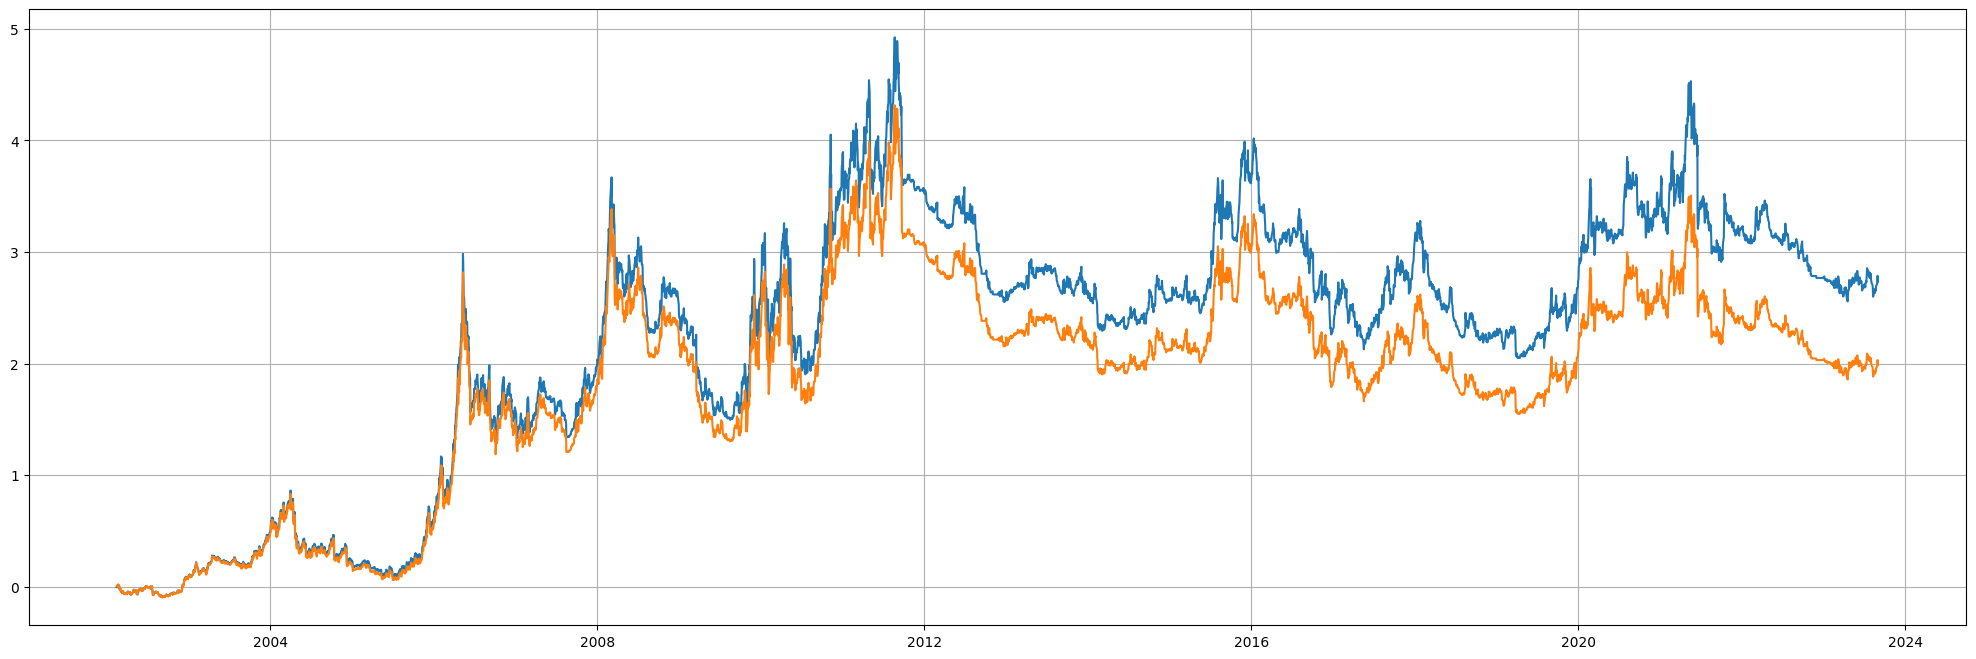

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+basket_final[f'MET_strategy_returns'])-1)
plt.plot(np.cumprod(1+basket_final1[f'MET_strategy_returns'])-1)
plt.grid()

In [ ]:
data_resampled_cur={}
data_cur={}
portfolio_df=pd.DataFrame()
fp1=pd.DataFrame()
list_vol=[]

for ticker in curncy:
  #data consolidation
  data_cur[ticker]=pd.DataFrame(cur_p.loc[:,ticker])
  data_resampled_cur[ticker] = data_cur[ticker]
  data_resampled_cur[ticker][f'Daily Returns_lag{1}']=data_resampled_cur[ticker][ticker].shift(1)
  data_resampled_cur[ticker][f'Daily Returns_lag{20}']=(data_resampled_cur[ticker][f'Daily Returns_lag{1}']).rolling(window=20).mean()
  data_resampled_cur[ticker][f'Vol']=calc_vol(data_resampled_cur[ticker][f'Daily Returns_lag{1}'])['Vol']

  data_resampled_cur[ticker][f'Daily_signal_lag{20}']=(data_resampled_cur[ticker][f'Daily Returns_lag{20}']/(data_resampled_cur[ticker][f'Vol']))*np.sqrt(20)
  data_resampled_cur[ticker][f'Daily_signal_lag_norm{20}'] = np.clip(data_resampled_cur[ticker][f'Daily_signal_lag{20}'], -2, 2)
  #Gearing for the short term trend
  data_resampled_cur[ticker][f'gearing_20']=0.08/(np.sqrt(252)*data_resampled_cur[ticker][f'Vol'])

  #Gearing for the combined signal
  data_resampled_cur[ticker][f'gearing'] = 0.3/(np.sqrt(252)*data_resampled_cur[ticker][f'Vol'])

  #Gearing up the short term signal
  data_resampled_cur[ticker][f'Daily_signal_lag_norm{20}']=data_resampled_cur[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_cur[ticker][f'gearing_20']

  for i in lags:
    data_resampled_cur[ticker][f'Daily Returns_lag{i}']=(data_resampled_cur[ticker][f'Daily Returns_lag{1}']).rolling(window=i).mean()
  data_resampled_cur[ticker]=data_resampled_cur[ticker].dropna()

  #Calculating Signals
  for i in lags:
    data_resampled_cur[ticker][f'Daily_signal_lag{i}']=(data_resampled_cur[ticker][f'Daily Returns_lag{i}']/(data_resampled_cur[ticker][f'Vol']))*np.sqrt(i)
    data_resampled_cur[ticker][f'Daily_signal_lag_norm{i}'] = np.clip(data_resampled_cur[ticker][f'Daily_signal_lag{i}'], -2, 2)


  #Combining the signal
  cs=pd.DataFrame(data_resampled_cur[ticker][f'Daily_signal_lag_norm{lags[0]}']*optimal_weights[0]+data_resampled_cur[ticker][f'Daily_signal_lag_norm{lags[1]}']*optimal_weights[1]+data_resampled_cur[ticker][f'Daily_signal_lag_norm{lags[2]}']*optimal_weights[2]+data_resampled_cur[ticker][f'Daily_signal_lag_norm{lags[3]}']*optimal_weights[3]+data_resampled_cur[ticker][f'Daily_signal_lag_norm{lags[4]}']*optimal_weights[4],columns=['Final Signal'])

  cs=signal_boost(cs,vix_f)
  data_resampled_cur[ticker]=pd.concat([data_resampled_cur[ticker],cs],axis=1)

  #Gearing up the final signal
  data_resampled_cur[ticker][f'Final Signal']=data_resampled_cur[ticker][f'Final Signal']*data_resampled_cur[ticker][f'gearing']
  data_resampled_cur[ticker][f'Final Signal']=np.round(np.clip(data_resampled_cur[ticker][f'Final Signal'], -15, 15))
  data_resampled_cur[ticker]['Costs']=[costs[ticker]]*len(data_resampled_cur[ticker])
  for i in data_resampled_cur[ticker].index.year.unique():
    data_resampled_cur[ticker].loc[data_resampled_cur[ticker].index.year==i,'Costs']=data_resampled_cur[ticker].loc[data_resampled_cur[ticker].index.year==i,'Costs']*((data_resampled_cur[ticker].loc[data_resampled_cur[ticker].index.year==i,ticker].std()*np.sqrt(252))/(data_resampled_cur[ticker].loc[data_resampled_cur[ticker].index.year==2023,ticker].std()*np.sqrt(252)))
  data_resampled_cur[ticker]['Costs']=data_resampled_cur[ticker]['Costs']*((data_resampled_cur[ticker][f'Final Signal']).diff().abs())
  data_resampled_cur[ticker][f'{ticker}_Strategy1'] = data_resampled_cur[ticker][f'Final Signal']*data_resampled_cur[ticker][ticker]-data_resampled_cur[ticker]['Costs']
  data_resampled_cur[ticker][f'{ticker}_Strategy'] = data_resampled_cur[ticker][f'Final Signal']*data_resampled_cur[ticker][ticker]
  #Storing the signal
  signals[ticker]=data_resampled_cur[ticker][['Final Signal',f'{ticker}','gearing',f'{ticker}_Strategy']]

In [ ]:
#Autocorrelation adjustment
  data_resampled_cur[ticker][f'{ticker}_Strategy_{20}']=data_resampled_cur[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_cur[ticker][ticker]
  data_resampled_cur[ticker][f'{ticker}_ACF_{20}']=data_resampled_cur[ticker][f'{ticker}_Strategy_{20}'].rolling(10).apply(lambda x: x.autocorr(), raw=False)
  mean_value = data_resampled_cur[ticker][f'{ticker}_ACF_{20}'].mean()
  std_dev = data_resampled_cur[ticker][f'{ticker}_ACF_{20}'].std()
  #Normalising the autocorrelation
  data_resampled_cur[ticker][f'{ticker}_ACF_{20}'] = (data_resampled_cur[ticker][f'{ticker}_ACF_{20}'] - mean_value) / std_dev
  data_resampled_cur[ticker][f'{ticker}_ACF_{20}']=data_resampled_cur[ticker][f'{ticker}_ACF_{20}'].shift(1)

#Replacing the signal
  for i in data_resampled_cur[ticker].index:
    if(np.sign(data_resampled_cur[ticker].loc[i,f'{ticker}_ACF_{20}'])==1.0):
      data_resampled_cur[ticker].at[i,f'Final Signal']=1.5*data_resampled_cur[ticker].loc[i,f'Daily_signal_lag_norm{20}']


data_resampled_cur[ticker]['Pos Ret']=(data_resampled_cur[ticker][f'{ticker}_Strategy']>0).astype(int)
data_resampled_cur[ticker]['Rolling_Pos']=data_resampled_cur[ticker]['Pos Ret'].rolling(window=20).sum()
data_resampled_cur[ticker]['Roll_Win_Ratio']=data_resampled_cur[ticker]['Rolling_Pos']/20
data_resampled_cur[ticker]['Roll_Win_Ratio']=data_resampled_cur[ticker]['Roll_Win_Ratio'].shift(1)
data_resampled_cur[ticker]=data_resampled_cur[ticker].dropna()
data_resampled_cur[ticker]['Confidence']=np.where(data_resampled_cur[ticker]['Roll_Win_Ratio']<0.6,sigmoid(data_resampled_cur[ticker]['Roll_Win_Ratio']),1)
data_resampled_cur[ticker][f'{ticker}_Strategy']=data_resampled_cur[ticker]['Final Signal']*data_resampled_cur[ticker]['Confidence']*data_resampled_cur[ticker][ticker]

In [ ]:
cur_basket_strat={}
cur_basket_strat[f'Returns']=pd.DataFrame()
for ticker in curncy:
  cur_basket_strat[f'Returns']=pd.concat([cur_basket_strat[f'Returns'],data_resampled_cur[ticker][f'{ticker}_Strategy']],axis=1)
n=len(cur_basket_strat[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=cur_basket_strat[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
cur_basket_strat[f'Returns'][f'CUR_strategy_returns']=np.dot((optimal_W),cur_basket_strat[f'Returns'].values.T)
#cur_basket_strat[f'Returns'][f'CUR_strategy_returns']=cur_basket_strat[f'Returns'][f'CUR_strategy_returns']/norm_factor
basket_final=pd.concat([basket_final,cur_basket_strat[f'Returns'][f'CUR_strategy_returns']],axis=1)
basket_final

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                0.001610              -0.001959   
2002-02-15               -0.001909               0.004814   
2002-02-19                0.001030               0.004399   
2002-02-20               -0.002053              -0.004447   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001897               0.008018   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000719               0.000278   
2023-08-31               -0.009641               0.002135   
2023-09-01                0.008625              -0.004696   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  
2002-02-14               0.004236             -0.002543             -0.011283  
2002-02-15              -0.002987              0.007230             -0.003964  
2002-02-19              -0.018525              0.008941             -0.000803  
2002-02-20               0.017355              0.003459              0.007377  
2002-02-21              -0.026097             -0.009302              0.001600  
...                           ...                   ...                   ...  
2023-08-28              -0.009843              0.004784             -0.000565  
2023-08-29               0.000225              0.011719              0.006208  
2023-08-30              -0.010068              0.006487              0.006271  
2023-08-31               0.002003             -0.006676             -0.011337  
2023-09-01              -0.008435             -0.006994             -0.010976  

[5435 rows x 5 columns]

In [ ]:
cur_basket_strat1={}
cur_basket_strat1[f'Returns']=pd.DataFrame()
for ticker in curncy:
  cur_basket_strat1[f'Returns']=pd.concat([cur_basket_strat1[f'Returns'],data_resampled_cur[ticker][f'{ticker}_Strategy1']],axis=1)
n=len(cur_basket_strat1[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=cur_basket_strat1[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
cur_basket_strat1[f'Returns'][f'CUR_strategy_returns']=np.dot((optimal_W),cur_basket_strat1[f'Returns'].values.T)
#cur_basket_strat1[f'Returns'][f'CUR_strategy_returns']=cur_basket_strat1[f'Returns'][f'CUR_strategy_returns']/norm_factor
basket_final1=pd.concat([basket_final1,cur_basket_strat1[f'Returns'][f'CUR_strategy_returns']],axis=1)
basket_final1

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                     NaN                    NaN   
2002-02-15               -0.001922               0.004814   
2002-02-19                0.001008               0.004373   
2002-02-20               -0.002080              -0.004474   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001931               0.007988   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000754               0.000278   
2023-08-31               -0.009648               0.002134   
2023-09-01                0.008605              -0.004826   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  
2002-02-14                    NaN                   NaN                   NaN  
2002-02-15              -0.002987              0.007187             -0.004155  
2002-02-19              -0.018608              0.008896             -0.001299  
2002-02-20               0.017272              0.003459              0.007067  
2002-02-21              -0.026122             -0.009302              0.001588  
...                           ...                   ...                   ...  
2023-08-28              -0.009869              0.004784             -0.000736  
2023-08-29               0.000225              0.011562              0.006180  
2023-08-30              -0.010068              0.006479              0.006240  
2023-08-31               0.002003             -0.006676             -0.011487  
2023-09-01              -0.008487             -0.007124             -0.011538  

[5435 rows x 5 columns]

In [ ]:
main_fwd=signals['KRW3M Curncy']
x=main_fwd[['KRW3M Curncy_Strategy','Final Signal']]
y=pd.DataFrame(main_fwd['KRW3M Curncy'])
x=pd.concat([x,forwards['KRW3M Curncy']],axis=1)
x=x.dropna()
x['KRW3M Curncy']=x['KRW3M Curncy'].shift(1)
x=x.dropna()
x['Z_Carry']=(x['KRW3M Curncy'] - x['KRW3M Curncy'].rolling(window=252).mean()) /x ['KRW3M Curncy'].rolling(window=252).std()
x['Z_Signal']=(x['Final Signal'] - x['Final Signal'].rolling(window=252).mean()) / x['Final Signal'].rolling(window=252).std()
x['Carry_Mean']=x['Z_Carry'].rolling(window=504).mean()
x['NewSignal'] = x.apply(lambda row: row['Final Signal'] if row['Z_Carry'] <row['Carry_Mean'] else 0, axis=1)
x

KRW3M Curncy_Strategy  Final Signal  KRW3M Curncy   Z_Carry  \
2002-02-15              -0.008070      2.124726   1316.500905       NaN   
2002-02-19               0.008016      1.503028   1311.500905       NaN   
2002-02-20              -0.000818      2.158143   1319.500930       NaN   
2002-02-21               0.000842      2.221320   1319.000930       NaN   
2002-02-22               0.003141      2.072163   1319.500875       NaN   
...                           ...           ...           ...       ...   
2023-08-28               0.000842     -0.656066   1324.999330  0.073985   
2023-08-29               0.000685     -0.604024   1323.299310  0.045524   
2023-08-30              -0.000990     -0.769959   1321.799303  0.020922   
2023-08-31               0.000507     -0.789614   1323.499319  0.057966   
2023-09-01               0.004505     -1.527928   1322.649319  0.046282   

            Z_Signal  Carry_Mean  NewSignal  
2002-02-15       NaN         NaN   0.000000  
2002-02-19       NaN         NaN   0.000000  
2002-02-20       NaN         NaN   0.000000  
2002-02-21       NaN         NaN   0.000000  
2002-02-22       NaN         NaN   0.000000  
...              ...         ...        ...  
2023-08-28 -1.215135    1.080492  -0.656066  
2023-08-29 -1.185703    1.077228  -0.604024  
2023-08-30 -1.257718    1.073913  -0.769959  
2023-08-31 -1.258826    1.070085  -0.789614  
2023-09-01 -1.599569    1.066642  -1.527928  

[5434 rows x 7 columns]

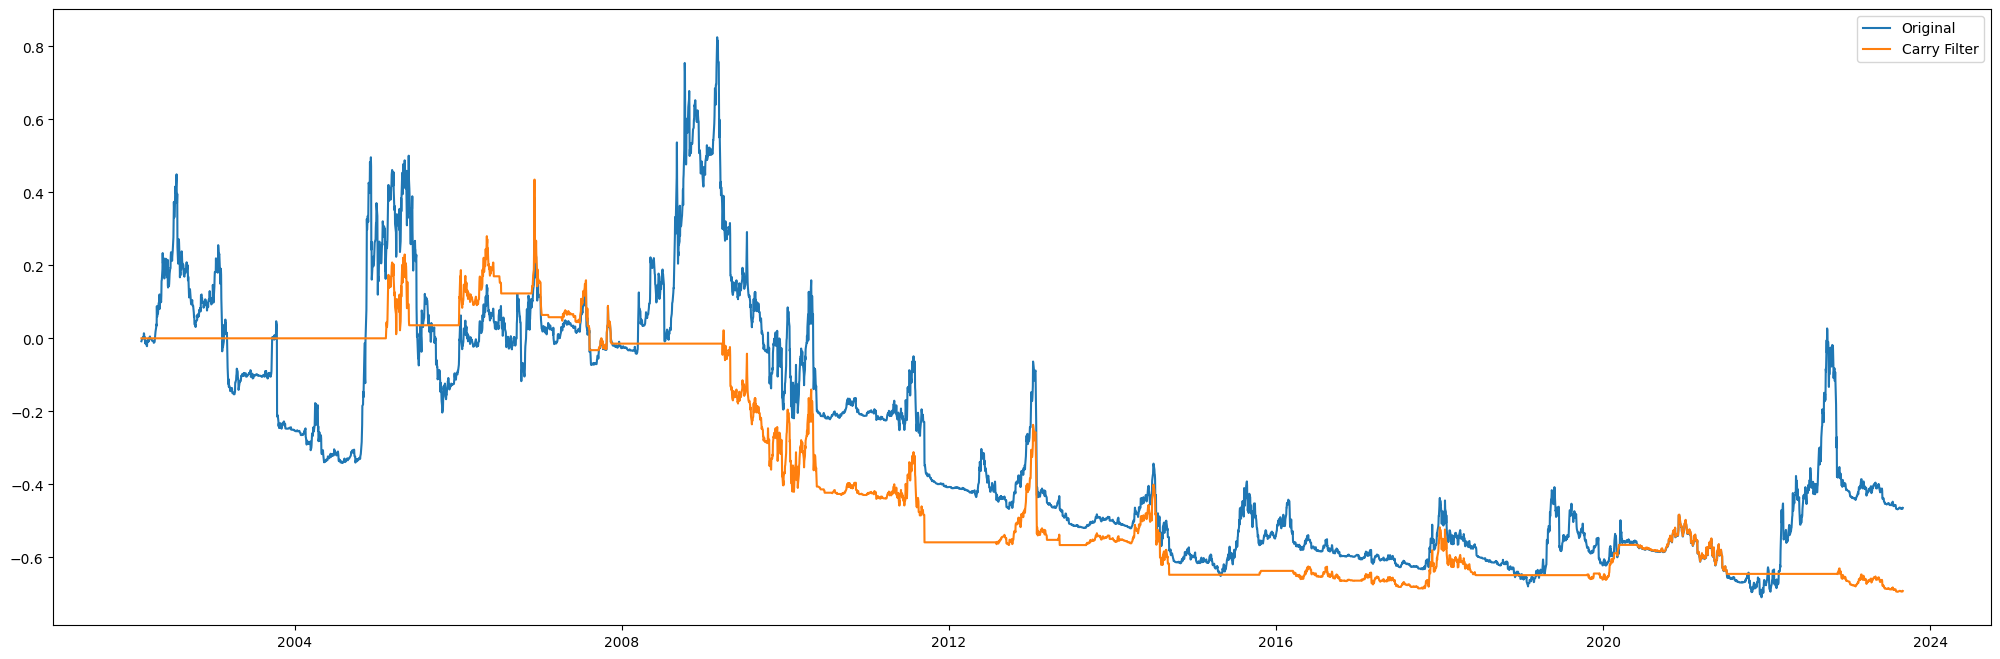

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+x.loc[:,'KRW3M Curncy_Strategy'])-1,label='Original')
plt.plot(np.cumprod(1+(x.loc[:,'NewSignal']*y.loc[:,'KRW3M Curncy']))-1,label='Carry Filter')
plt.legend()

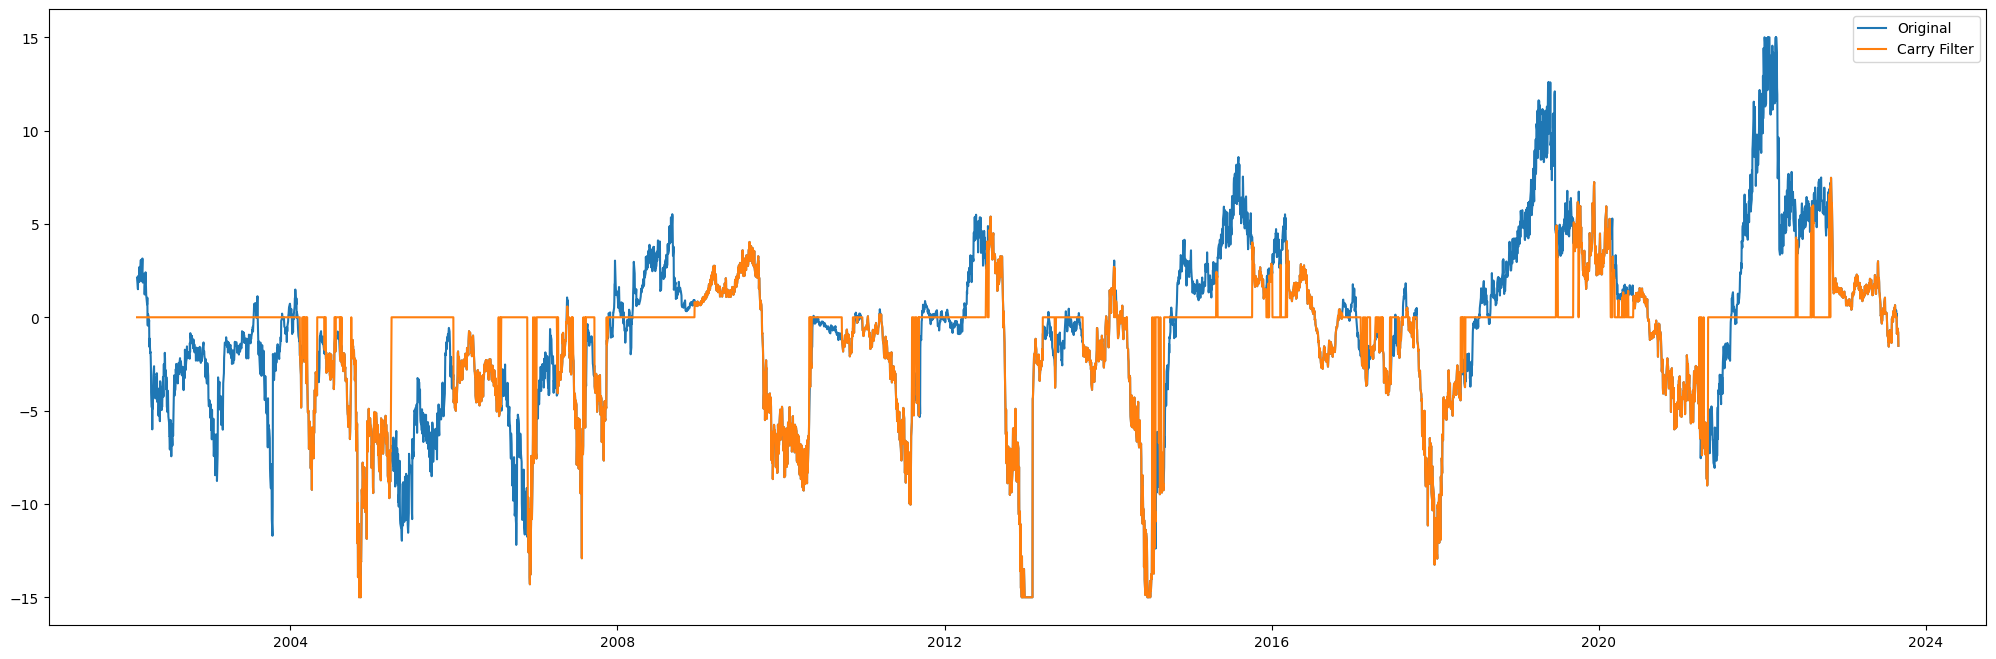

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(x.loc[:,'Final Signal'],label='Original')
plt.plot(x.loc[:,'NewSignal'],label='Carry Filter')
plt.legend()

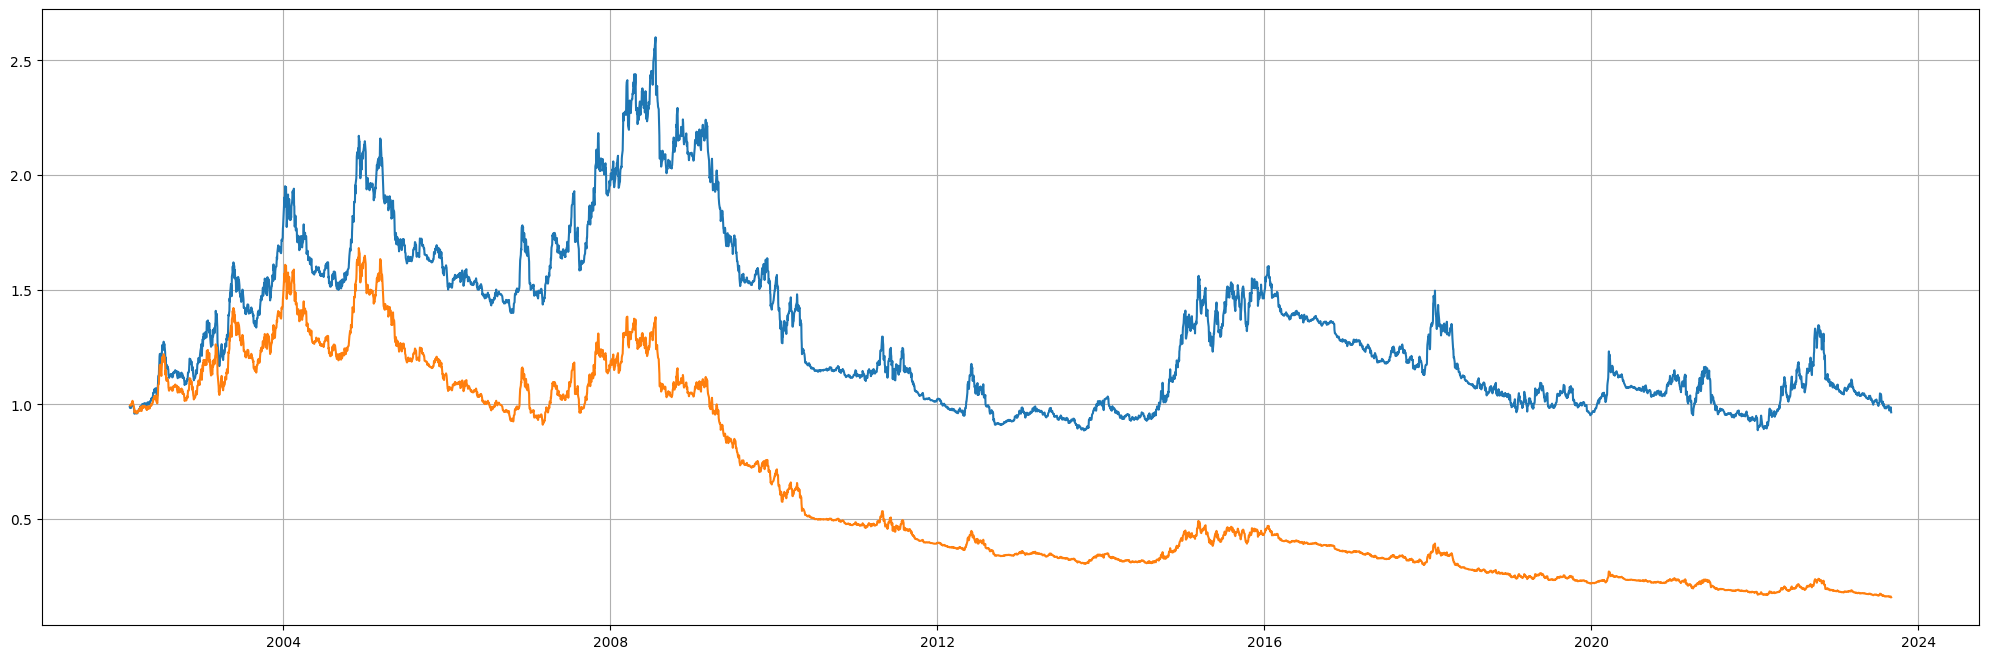

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+basket_final[f'CUR_strategy_returns']))
plt.plot(np.cumprod(1+basket_final1[f'CUR_strategy_returns']))
plt.grid()

In [ ]:
data_resampled_eq={}
data_eq={}
portfolio_df=pd.DataFrame()
fp1=pd.DataFrame()
list_vol=[]

for ticker in eq:
  #data consolidation
  data_eq[ticker]=pd.DataFrame(eq_p.loc[:,ticker])
  data_resampled_eq[ticker] = data_eq[ticker]
  data_resampled_eq[ticker][f'Daily Returns_lag{1}']=data_resampled_eq[ticker][ticker].shift(1)
  data_resampled_eq[ticker][f'Daily Returns_lag{20}']=(data_resampled_eq[ticker][f'Daily Returns_lag{1}']).rolling(window=20).mean()
  data_resampled_eq[ticker][f'Vol']=calc_vol(data_resampled_eq[ticker][f'Daily Returns_lag{1}'])['Vol']

  data_resampled_eq[ticker][f'Daily_signal_lag{20}']=(data_resampled_eq[ticker][f'Daily Returns_lag{20}']/(data_resampled_eq[ticker][f'Vol']))*np.sqrt(20)
  data_resampled_eq[ticker][f'Daily_signal_lag_norm{20}'] = np.clip(data_resampled_eq[ticker][f'Daily_signal_lag{20}'], -2, 2)
  #Gearing for the short term trend
  data_resampled_eq[ticker][f'gearing_20']=0.08/(np.sqrt(252)*data_resampled_eq[ticker][f'Vol'])

  #Gearing for the combined signal
  data_resampled_eq[ticker][f'gearing'] = 0.3/(np.sqrt(252)*data_resampled_eq[ticker][f'Vol'])

  #Gearing up the short term signal
  data_resampled_eq[ticker][f'Daily_signal_lag_norm{20}']=data_resampled_eq[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_eq[ticker][f'gearing_20']

  for i in lags:
    data_resampled_eq[ticker][f'Daily Returns_lag{i}']=(data_resampled_eq[ticker][f'Daily Returns_lag{1}']).rolling(window=i).mean()
  data_resampled_eq[ticker]=data_resampled_eq[ticker].dropna()

  #Calculating Signals
  for i in lags:
    data_resampled_eq[ticker][f'Daily_signal_lag{i}']=(data_resampled_eq[ticker][f'Daily Returns_lag{i}']/(data_resampled_eq[ticker][f'Vol']))*np.sqrt(i)
    data_resampled_eq[ticker][f'Daily_signal_lag_norm{i}'] = np.clip(data_resampled_eq[ticker][f'Daily_signal_lag{i}'], -2, 2)

  #Autocorrelation adjustment

  #Combining the signal
  cs=pd.DataFrame(data_resampled_eq[ticker][f'Daily_signal_lag_norm{lags[0]}']*optimal_weights[0]+data_resampled_eq[ticker][f'Daily_signal_lag_norm{lags[1]}']*optimal_weights[1]+data_resampled_eq[ticker][f'Daily_signal_lag_norm{lags[2]}']*optimal_weights[2]+data_resampled_eq[ticker][f'Daily_signal_lag_norm{lags[3]}']*optimal_weights[3]+data_resampled_eq[ticker][f'Daily_signal_lag_norm{lags[4]}']*optimal_weights[4],columns=['Final Signal'])

  cs=signal_boost2(cs,vix_f)
  data_resampled_eq[ticker]=pd.concat([data_resampled_eq[ticker],cs],axis=1)

  #Gearing up the final signal
  data_resampled_eq[ticker][f'Final Signal']=data_resampled_eq[ticker][f'Final Signal']*data_resampled_eq[ticker][f'gearing']
  data_resampled_eq[ticker][f'Final Signal']=np.round(np.clip(data_resampled_eq[ticker][f'Final Signal'], -15, 15))
  data_resampled_eq[ticker]['Costs']=[costs[ticker]]*len(data_resampled_eq[ticker])
  for i in data_resampled_eq[ticker].index.year.unique():
    data_resampled_eq[ticker].loc[data_resampled_eq[ticker].index.year==i,'Costs']=data_resampled_eq[ticker].loc[data_resampled_eq[ticker].index.year==i,'Costs']*((data_resampled_eq[ticker].loc[data_resampled_eq[ticker].index.year==i,ticker].std()*np.sqrt(252))/(data_resampled_eq[ticker].loc[data_resampled_eq[ticker].index.year==2023,ticker].std()*np.sqrt(252)))
  data_resampled_eq[ticker]['Costs']=data_resampled_eq[ticker]['Costs']*((data_resampled_eq[ticker][f'Final Signal']).diff().abs())

  #Replacing the signal


  data_resampled_eq[ticker][f'{ticker}_Strategy'] = data_resampled_eq[ticker][f'Final Signal']*data_resampled_eq[ticker][ticker]
  data_resampled_eq[ticker][f'{ticker}_Strategy1'] = data_resampled_eq[ticker][f'Final Signal']*data_resampled_eq[ticker][ticker]-data_resampled_eq[ticker]['Costs']


  data_resampled_eq[ticker][f'{ticker}_Strategy'] = data_resampled_eq[ticker][f'Final Signal']*data_resampled_eq[ticker][ticker]

  #Storing the signal
  signals[ticker]=data_resampled_eq[ticker][['Final Signal',f'{ticker}','gearing',f'{ticker}_Strategy']]

In [ ]:
data_resampled_eq[ticker]['Pos Ret']=(data_resampled_eq[ticker][f'{ticker}_Strategy']>0).astype(int)
data_resampled_eq[ticker]['Rolling_Pos']=data_resampled_eq[ticker]['Pos Ret'].rolling(window=20).sum()
data_resampled_eq[ticker]['Roll_Win_Ratio']=data_resampled_eq[ticker]['Rolling_Pos']/20
data_resampled_eq[ticker]['Roll_Win_Ratio']=data_resampled_eq[ticker]['Roll_Win_Ratio'].shift(1)
data_resampled_eq[ticker]=data_resampled_eq[ticker].dropna()
data_resampled_eq[ticker]['Confidence']=np.where(data_resampled_eq[ticker]['Roll_Win_Ratio']<0.6,sigmoid(data_resampled_eq[ticker]['Roll_Win_Ratio']),1)
data_resampled_eq[ticker][f'{ticker}_Strategy']=data_resampled_eq[ticker]['Final Signal']*data_resampled_eq[ticker]['Confidence']*data_resampled_eq[ticker][ticker]

In [ ]:
eq_basket_strat={}
eq_basket_strat[f'Returns']=pd.DataFrame()
for ticker in eq:
  eq_basket_strat[f'Returns']=pd.concat([eq_basket_strat[f'Returns'],data_resampled_eq[ticker][f'{ticker}_Strategy']],axis=1)
n=len(eq_basket_strat[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=eq_basket_strat[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
eq_basket_strat[f'Returns'][f'EQ_strategy_returns']=np.dot((optimal_W),eq_basket_strat[f'Returns'].values.T)
#eq_basket_strat[f'Returns'][f'EQ_strategy_returns']=eq_basket_strat[f'Returns'][f'EQ_strategy_returns']/norm_factor
basket_final=pd.concat([basket_final,eq_basket_strat[f'Returns'][f'EQ_strategy_returns']],axis=1)
basket_final

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                0.001610              -0.001959   
2002-02-15               -0.001909               0.004814   
2002-02-19                0.001030               0.004399   
2002-02-20               -0.002053              -0.004447   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001897               0.008018   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000719               0.000278   
2023-08-31               -0.009641               0.002135   
2023-09-01                0.008625              -0.004696   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2002-02-14               0.004236             -0.002543             -0.011283   
2002-02-15              -0.002987              0.007230             -0.003964   
2002-02-19              -0.018525              0.008941             -0.000803   
2002-02-20               0.017355              0.003459              0.007377   
2002-02-21              -0.026097             -0.009302              0.001600   
...                           ...                   ...                   ...   
2023-08-28              -0.009843              0.004784             -0.000565   
2023-08-29               0.000225              0.011719              0.006208   
2023-08-30              -0.010068              0.006487              0.006271   
2023-08-31               0.002003             -0.006676             -0.011337   
2023-09-01              -0.008435             -0.006994             -0.010976   

            EQ_strategy_returns  
2002-02-14            -0.002726  
2002-02-15             0.003671  
2002-02-19             0.024407  
2002-02-20            -0.000647  
2002-02-21            -0.001885  
...                         ...  
2023-08-28             0.017988  
2023-08-29             0.021744  
2023-08-30             0.000014  
2023-08-31            -0.001099  
2023-09-01            -0.006404  

[5435 rows x 6 columns]

In [ ]:
eq_basket_strat1={}
eq_basket_strat1[f'Returns']=pd.DataFrame()
for ticker in eq:
  eq_basket_strat1[f'Returns']=pd.concat([eq_basket_strat1[f'Returns'],data_resampled_eq[ticker][f'{ticker}_Strategy1']],axis=1)
n=len(eq_basket_strat1[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=eq_basket_strat1[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
eq_basket_strat1[f'Returns'][f'EQ_strategy_returns']=np.dot((optimal_W),eq_basket_strat1[f'Returns'].values.T)
#eq_basket_strat1[f'Returns'][f'EQ_strategy_returns']=eq_basket_strat1[f'Returns'][f'EQ_strategy_returns']/norm_factor
basket_final1=pd.concat([basket_final1,eq_basket_strat1[f'Returns'][f'EQ_strategy_returns']],axis=1)
basket_final1

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                     NaN                    NaN   
2002-02-15               -0.001922               0.004814   
2002-02-19                0.001008               0.004373   
2002-02-20               -0.002080              -0.004474   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001931               0.007988   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000754               0.000278   
2023-08-31               -0.009648               0.002134   
2023-09-01                0.008605              -0.004826   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2002-02-14                    NaN                   NaN                   NaN   
2002-02-15              -0.002987              0.007187             -0.004155   
2002-02-19              -0.018608              0.008896             -0.001299   
2002-02-20               0.017272              0.003459              0.007067   
2002-02-21              -0.026122             -0.009302              0.001588   
...                           ...                   ...                   ...   
2023-08-28              -0.009869              0.004784             -0.000736   
2023-08-29               0.000225              0.011562              0.006180   
2023-08-30              -0.010068              0.006479              0.006240   
2023-08-31               0.002003             -0.006676             -0.011487   
2023-09-01              -0.008487             -0.007124             -0.011538   

            EQ_strategy_returns  
2002-02-14                  NaN  
2002-02-15             0.003671  
2002-02-19             0.024316  
2002-02-20            -0.000685  
2002-02-21            -0.001885  
...                         ...  
2023-08-28             0.017979  
2023-08-29             0.021682  
2023-08-30             0.000009  
2023-08-31            -0.001106  
2023-09-01            -0.006411  

[5435 rows x 6 columns]

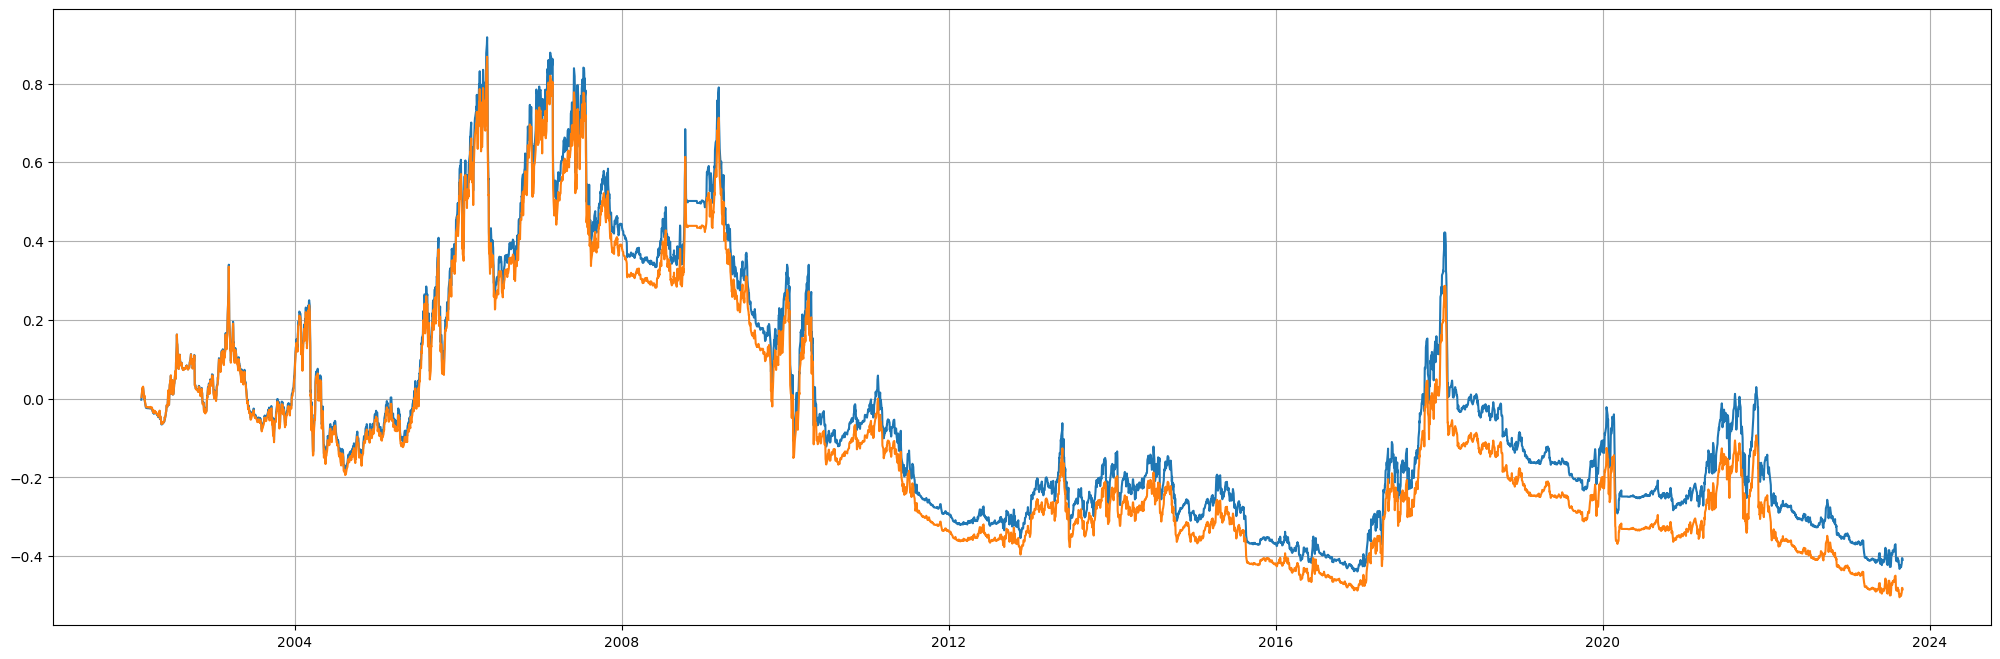

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+basket_final[f'EQ_strategy_returns'])-1)
plt.plot(np.cumprod(1+basket_final1[f'EQ_strategy_returns'])-1)
plt.grid()

In [ ]:
data_resampled_rates={}
data_rates={}
portfolio_df=pd.DataFrame()
fp1=pd.DataFrame()
list_vol=[]

for ticker in rates:
  #data consolidation
  data_rates[ticker]=pd.DataFrame(rates_p.loc[:,ticker])
  data_resampled_rates[ticker] = data_rates[ticker]
  data_resampled_rates[ticker][f'Daily Returns_lag{1}']=data_resampled_rates[ticker][ticker].shift(1)
  data_resampled_rates[ticker][f'Daily Returns_lag{20}']=(data_resampled_rates[ticker][f'Daily Returns_lag{1}']).rolling(window=20).mean()
  data_resampled_rates[ticker][f'Vol']=calc_vol(data_resampled_rates[ticker][f'Daily Returns_lag{1}'])['Vol']

  data_resampled_rates[ticker][f'Daily_signal_lag{20}']=(data_resampled_rates[ticker][f'Daily Returns_lag{20}']/(data_resampled_rates[ticker][f'Vol']))*np.sqrt(20)
  data_resampled_rates[ticker][f'Daily_signal_lag_norm{20}'] = np.clip(data_resampled_rates[ticker][f'Daily_signal_lag{20}'], -2, 2)
  #Gearing for the short term trend
  data_resampled_rates[ticker][f'gearing_20']=0.08/(np.sqrt(252)*data_resampled_rates[ticker][f'Vol'])

  #Gearing for the combined signal
  data_resampled_rates[ticker][f'gearing'] = 0.3/(np.sqrt(252)*data_resampled_rates[ticker][f'Vol'])

  #Gearing up the short term signal
  data_resampled_rates[ticker][f'Daily_signal_lag_norm{20}']=data_resampled_rates[ticker][f'Daily_signal_lag_norm{20}']*data_resampled_rates[ticker][f'gearing_20']

  for i in lags:
    data_resampled_rates[ticker][f'Daily Returns_lag{i}']=(data_resampled_rates[ticker][f'Daily Returns_lag{1}']).rolling(window=i).mean()
  data_resampled_rates[ticker]=data_resampled_rates[ticker].dropna()

  #Calculating Signals
  for i in lags:
    data_resampled_rates[ticker][f'Daily_signal_lag{i}']=(data_resampled_rates[ticker][f'Daily Returns_lag{i}']/(data_resampled_rates[ticker][f'Vol']))*np.sqrt(i)
    data_resampled_rates[ticker][f'Daily_signal_lag_norm{i}'] = np.clip(data_resampled_rates[ticker][f'Daily_signal_lag{i}'], -2, 2)

  #Autocorrelation adjustment

  #Combining the signal
  cs=pd.DataFrame(data_resampled_rates[ticker][f'Daily_signal_lag_norm{lags[0]}']*optimal_weights[0]+data_resampled_rates[ticker][f'Daily_signal_lag_norm{lags[1]}']*optimal_weights[1]+data_resampled_rates[ticker][f'Daily_signal_lag_norm{lags[2]}']*optimal_weights[2]+data_resampled_rates[ticker][f'Daily_signal_lag_norm{lags[3]}']*optimal_weights[3]+data_resampled_rates[ticker][f'Daily_signal_lag_norm{lags[4]}']*optimal_weights[4],columns=['Final Signal'])

  cs=signal_boost(cs,vix_f)
  data_resampled_rates[ticker]=pd.concat([data_resampled_rates[ticker],cs],axis=1)

  #Gearing up the final signal
  data_resampled_rates[ticker][f'Final Signal']=data_resampled_rates[ticker][f'Final Signal']*data_resampled_rates[ticker][f'gearing']
  data_resampled_rates[ticker][f'Final Signal']=np.clip(data_resampled_rates[ticker][f'Final Signal'], -15, 15)
  data_resampled_rates[ticker]['Costs']=[costs[ticker]]*len(data_resampled_rates[ticker])
  for i in data_resampled_rates[ticker].index.year.unique():
    data_resampled_rates[ticker].loc[data_resampled_rates[ticker].index.year==i,'Costs']=data_resampled_rates[ticker].loc[data_resampled_rates[ticker].index.year==i,'Costs']*((data_resampled_rates[ticker].loc[data_resampled_rates[ticker].index.year==i,ticker].std()*np.sqrt(252))/(data_resampled_rates[ticker].loc[data_resampled_rates[ticker].index.year==2023,ticker].std()*np.sqrt(252)))
  data_resampled_rates[ticker]['Costs']=data_resampled_rates[ticker]['Costs']*((data_resampled_rates[ticker][f'Final Signal']).diff().abs())

  #Replacing the signal


  data_resampled_rates[ticker][f'{ticker}_Strategy'] = data_resampled_rates[ticker][f'Final Signal']*data_resampled_rates[ticker][ticker]
  data_resampled_rates[ticker][f'{ticker}_Strategy1'] = data_resampled_rates[ticker][f'Final Signal']*data_resampled_rates[ticker][ticker]-data_resampled_rates[ticker]['Costs']



  #Storing the signal
  signals[ticker]=data_resampled_rates[ticker][['Final Signal',f'{ticker}','gearing',f'{ticker}_Strategy']]

In [ ]:
rates_basket_strat={}
rates_basket_strat[f'Returns']=pd.DataFrame()
for ticker in rates:
  rates_basket_strat[f'Returns']=pd.concat([rates_basket_strat[f'Returns'],data_resampled_rates[ticker][f'{ticker}_Strategy']],axis=1)
n=len(rates_basket_strat[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=rates_basket_strat[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
rates_basket_strat[f'Returns'][f'RATES_strategy_returns']=np.dot((optimal_W),rates_basket_strat[f'Returns'].values.T)
#rates_basket_strat[f'Returns'][f'rates_strategy_returns']=rates_basket_strat[f'Returns'][f'rates_strategy_returns']/norm_factor
basket_final=pd.concat([basket_final,rates_basket_strat[f'Returns'][f'RATES_strategy_returns']],axis=1)
basket_final

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                0.001610              -0.001959   
2002-02-15               -0.001909               0.004814   
2002-02-19                0.001030               0.004399   
2002-02-20               -0.002053              -0.004447   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001897               0.008018   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000719               0.000278   
2023-08-31               -0.009641               0.002135   
2023-09-01                0.008625              -0.004696   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2002-02-14               0.004236             -0.002543             -0.011283   
2002-02-15              -0.002987              0.007230             -0.003964   
2002-02-19              -0.018525              0.008941             -0.000803   
2002-02-20               0.017355              0.003459              0.007377   
2002-02-21              -0.026097             -0.009302              0.001600   
...                           ...                   ...                   ...   
2023-08-28              -0.009843              0.004784             -0.000565   
2023-08-29               0.000225              0.011719              0.006208   
2023-08-30              -0.010068              0.006487              0.006271   
2023-08-31               0.002003             -0.006676             -0.011337   
2023-09-01              -0.008435             -0.006994             -0.010976   

            EQ_strategy_returns  RATES_strategy_returns  
2002-02-14            -0.002726               -0.003255  
2002-02-15             0.003671               -0.001943  
2002-02-19             0.024407               -0.000143  
2002-02-20            -0.000647                0.000600  
2002-02-21            -0.001885               -0.000289  
...                         ...                     ...  
2023-08-28             0.017988                0.000967  
2023-08-29             0.021744               -0.006716  
2023-08-30             0.000014               -0.002466  
2023-08-31            -0.001099               -0.007961  
2023-09-01            -0.006404               -0.000722  

[5435 rows x 7 columns]

In [ ]:
rates_basket_strat1={}
rates_basket_strat1[f'Returns']=pd.DataFrame()
for ticker in rates:
  rates_basket_strat1[f'Returns']=pd.concat([rates_basket_strat1[f'Returns'],data_resampled_rates[ticker][f'{ticker}_Strategy1']],axis=1)
n=len(rates_basket_strat1[f'Returns'].columns)
optimal_W=np.ones(n)/n
correlation_matrix=rates_basket_strat1[f'Returns'].corr().values
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
rates_basket_strat1[f'Returns'][f'RATES_strategy_returns']=np.dot((optimal_W),rates_basket_strat1[f'Returns'].values.T)
#rates_basket_strat1[f'Returns'][f'rates_strategy_returns']=rates_basket_strat1[f'Returns'][f'rates_strategy_returns']/norm_factor
basket_final1=pd.concat([basket_final1,rates_basket_strat1[f'Returns'][f'RATES_strategy_returns']],axis=1)
basket_final1

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                     NaN                    NaN   
2002-02-15               -0.001922               0.004814   
2002-02-19                0.001008               0.004373   
2002-02-20               -0.002080              -0.004474   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001931               0.007988   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000754               0.000278   
2023-08-31               -0.009648               0.002134   
2023-09-01                0.008605              -0.004826   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2002-02-14                    NaN                   NaN                   NaN   
2002-02-15              -0.002987              0.007187             -0.004155   
2002-02-19              -0.018608              0.008896             -0.001299   
2002-02-20               0.017272              0.003459              0.007067   
2002-02-21              -0.026122             -0.009302              0.001588   
...                           ...                   ...                   ...   
2023-08-28              -0.009869              0.004784             -0.000736   
2023-08-29               0.000225              0.011562              0.006180   
2023-08-30              -0.010068              0.006479              0.006240   
2023-08-31               0.002003             -0.006676             -0.011487   
2023-09-01              -0.008487             -0.007124             -0.011538   

            EQ_strategy_returns  RATES_strategy_returns  
2002-02-14                  NaN                     NaN  
2002-02-15             0.003671               -0.002010  
2002-02-19             0.024316               -0.000176  
2002-02-20            -0.000685                0.000581  
2002-02-21            -0.001885               -0.000308  
...                         ...                     ...  
2023-08-28             0.017979                0.000945  
2023-08-29             0.021682               -0.006720  
2023-08-30             0.000009               -0.002495  
2023-08-31            -0.001106               -0.007967  
2023-09-01            -0.006411               -0.000739  

[5435 rows x 7 columns]

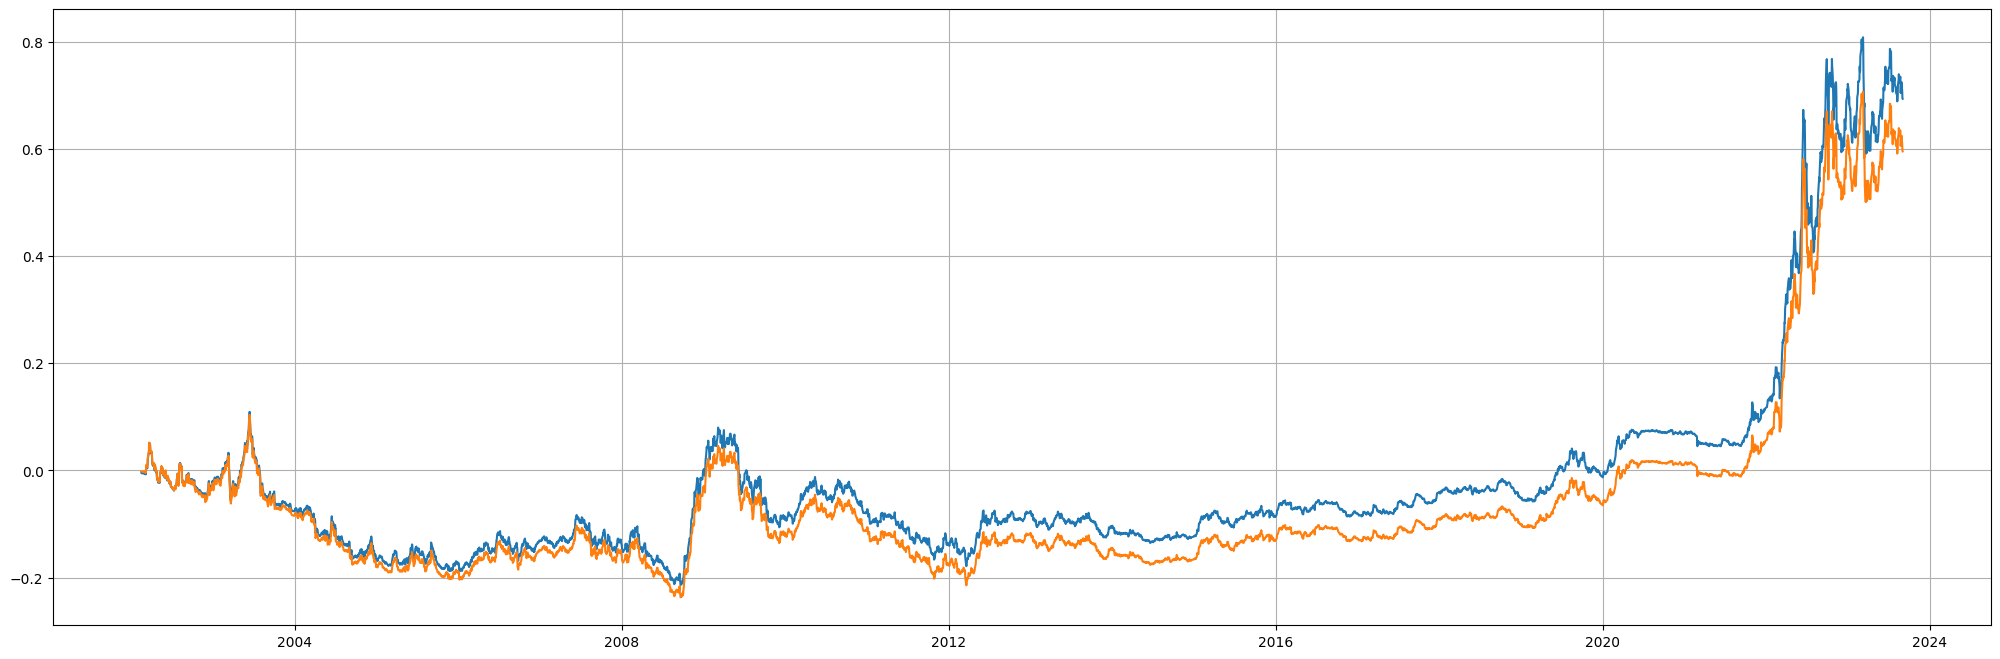

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+basket_final[f'RATES_strategy_returns'])-1)
plt.plot(np.cumprod(1+basket_final1[f'RATES_strategy_returns'])-1)
plt.grid()

In [ ]:
optimal_W=np.ones(7)/7
jr=basket_final
correlation_matrix=jr.corr()
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
basket_final=basket_final
basket_final[f'Portfolio_Ret']=np.dot(optimal_W,basket_final.T)
basket_final

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                0.001610              -0.001959   
2002-02-15               -0.001909               0.004814   
2002-02-19                0.001030               0.004399   
2002-02-20               -0.002053              -0.004447   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001897               0.008018   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000719               0.000278   
2023-08-31               -0.009641               0.002135   
2023-09-01                0.008625              -0.004696   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2002-02-14               0.004236             -0.002543             -0.011283   
2002-02-15              -0.002987              0.007230             -0.003964   
2002-02-19              -0.018525              0.008941             -0.000803   
2002-02-20               0.017355              0.003459              0.007377   
2002-02-21              -0.026097             -0.009302              0.001600   
...                           ...                   ...                   ...   
2023-08-28              -0.009843              0.004784             -0.000565   
2023-08-29               0.000225              0.011719              0.006208   
2023-08-30              -0.010068              0.006487              0.006271   
2023-08-31               0.002003             -0.006676             -0.011337   
2023-09-01              -0.008435             -0.006994             -0.010976   

            EQ_strategy_returns  RATES_strategy_returns  Portfolio_Ret  
2002-02-14            -0.002726               -0.003255      -0.002274  
2002-02-15             0.003671               -0.001943       0.000702  
2002-02-19             0.024407               -0.000143       0.002758  
2002-02-20            -0.000647                0.000600       0.003092  
2002-02-21            -0.001885               -0.000289      -0.003889  
...                         ...                     ...            ...  
2023-08-28             0.017988                0.000967       0.002779  
2023-08-29             0.021744               -0.006716       0.004072  
2023-08-30             0.000014               -0.002466      -0.000029  
2023-08-31            -0.001099               -0.007961      -0.004654  
2023-09-01            -0.006404               -0.000722      -0.004229  

[5435 rows x 8 columns]

In [ ]:
optimal_W=np.ones(7)/7
jr=basket_final1
correlation_matrix=jr.corr()
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
basket_final1=basket_final1
basket_final1[f'Portfolio_Ret']=np.dot(optimal_W,basket_final1.T)
basket_final1

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                     NaN                    NaN   
2002-02-15               -0.001922               0.004814   
2002-02-19                0.001008               0.004373   
2002-02-20               -0.002080              -0.004474   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001931               0.007988   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000754               0.000278   
2023-08-31               -0.009648               0.002134   
2023-09-01                0.008605              -0.004826   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2002-02-14                    NaN                   NaN                   NaN   
2002-02-15              -0.002987              0.007187             -0.004155   
2002-02-19              -0.018608              0.008896             -0.001299   
2002-02-20               0.017272              0.003459              0.007067   
2002-02-21              -0.026122             -0.009302              0.001588   
...                           ...                   ...                   ...   
2023-08-28              -0.009869              0.004784             -0.000736   
2023-08-29               0.000225              0.011562              0.006180   
2023-08-30              -0.010068              0.006479              0.006240   
2023-08-31               0.002003             -0.006676             -0.011487   
2023-09-01              -0.008487             -0.007124             -0.011538   

            EQ_strategy_returns  RATES_strategy_returns  Portfolio_Ret  
2002-02-14                  NaN                     NaN            NaN  
2002-02-15             0.003671               -0.002010       0.000657  
2002-02-19             0.024316               -0.000176       0.002644  
2002-02-20            -0.000685                0.000581       0.003020  
2002-02-21            -0.001885               -0.000308      -0.003897  
...                         ...                     ...            ...  
2023-08-28             0.017979                0.000945       0.002737  
2023-08-29             0.021682               -0.006720       0.004037  
2023-08-30             0.000009               -0.002495      -0.000044  
2023-08-31            -0.001106               -0.007967      -0.004678  
2023-09-01            -0.006411               -0.000739      -0.004360  

[5435 rows x 8 columns]

In [ ]:
basket_final['Cum_ret']=np.cumprod(1+basket_final[f'Portfolio_Ret'])-1
basket_final1['Cum_ret']=np.cumprod(1+basket_final1[f'Portfolio_Ret'])-1
basket_final

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                0.001610              -0.001959   
2002-02-15               -0.001909               0.004814   
2002-02-19                0.001030               0.004399   
2002-02-20               -0.002053              -0.004447   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001897               0.008018   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000719               0.000278   
2023-08-31               -0.009641               0.002135   
2023-09-01                0.008625              -0.004696   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2002-02-14               0.004236             -0.002543             -0.011283   
2002-02-15              -0.002987              0.007230             -0.003964   
2002-02-19              -0.018525              0.008941             -0.000803   
2002-02-20               0.017355              0.003459              0.007377   
2002-02-21              -0.026097             -0.009302              0.001600   
...                           ...                   ...                   ...   
2023-08-28              -0.009843              0.004784             -0.000565   
2023-08-29               0.000225              0.011719              0.006208   
2023-08-30              -0.010068              0.006487              0.006271   
2023-08-31               0.002003             -0.006676             -0.011337   
2023-09-01              -0.008435             -0.006994             -0.010976   

            EQ_strategy_returns  RATES_strategy_returns  Portfolio_Ret  \
2002-02-14            -0.002726               -0.003255      -0.002274   
2002-02-15             0.003671               -0.001943       0.000702   
2002-02-19             0.024407               -0.000143       0.002758   
2002-02-20            -0.000647                0.000600       0.003092   
2002-02-21            -0.001885               -0.000289      -0.003889   
...                         ...                     ...            ...   
2023-08-28             0.017988                0.000967       0.002779   
2023-08-29             0.021744               -0.006716       0.004072   
2023-08-30             0.000014               -0.002466      -0.000029   
2023-08-31            -0.001099               -0.007961      -0.004654   
2023-09-01            -0.006404               -0.000722      -0.004229   

             Cum_ret  
2002-02-14 -0.002274  
2002-02-15 -0.001574  
2002-02-19  0.001179  
2002-02-20  0.004275  
2002-02-21  0.000369  
...              ...  
2023-08-28  1.740077  
2023-08-29  1.751236  
2023-08-30  1.751156  
2023-08-31  1.738353  
2023-09-01  1.726772  

[5435 rows x 9 columns]

In [ ]:
basket_final1

BONDS_strategy_returns  AGRI_strategy_returns  \
2002-02-14                     NaN                    NaN   
2002-02-15               -0.001922               0.004814   
2002-02-19                0.001008               0.004373   
2002-02-20               -0.002080              -0.004474   
2002-02-21                0.003041               0.005709   
...                            ...                    ...   
2023-08-28               -0.001931               0.007988   
2023-08-29               -0.019039               0.014366   
2023-08-30               -0.000754               0.000278   
2023-08-31               -0.009648               0.002134   
2023-09-01                0.008605              -0.004826   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2002-02-14                    NaN                   NaN                   NaN   
2002-02-15              -0.002987              0.007187             -0.004155   
2002-02-19              -0.018608              0.008896             -0.001299   
2002-02-20               0.017272              0.003459              0.007067   
2002-02-21              -0.026122             -0.009302              0.001588   
...                           ...                   ...                   ...   
2023-08-28              -0.009869              0.004784             -0.000736   
2023-08-29               0.000225              0.011562              0.006180   
2023-08-30              -0.010068              0.006479              0.006240   
2023-08-31               0.002003             -0.006676             -0.011487   
2023-09-01              -0.008487             -0.007124             -0.011538   

            EQ_strategy_returns  RATES_strategy_returns  Portfolio_Ret  \
2002-02-14                  NaN                     NaN            NaN   
2002-02-15             0.003671               -0.002010       0.000657   
2002-02-19             0.024316               -0.000176       0.002644   
2002-02-20            -0.000685                0.000581       0.003020   
2002-02-21            -0.001885               -0.000308      -0.003897   
...                         ...                     ...            ...   
2023-08-28             0.017979                0.000945       0.002737   
2023-08-29             0.021682               -0.006720       0.004037   
2023-08-30             0.000009               -0.002495      -0.000044   
2023-08-31            -0.001106               -0.007967      -0.004678   
2023-09-01            -0.006411               -0.000739      -0.004360   

             Cum_ret  
2002-02-14       NaN  
2002-02-15  0.000657  
2002-02-19  0.003303  
2002-02-20  0.006333  
2002-02-21  0.002411  
...              ...  
2023-08-28  0.872763  
2023-08-29  0.880322  
2023-08-30  0.880239  
2023-08-31  0.871443  
2023-09-01  0.863283  

[5435 rows x 9 columns]

In [ ]:
btop=pd.read_excel('/content/NEIXCTAT.xlsx')

btop=btop.iloc[6:,:]
btop.columns=['Date','Price','Volume']
btop=btop.iloc[::-1].reset_index(drop=True)
btop.Date=pd.to_datetime(btop.Date,format="%Y-%m-%d")

btop=btop.set_index('Date')
btop.index = pd.to_datetime(btop.index,format="%Y-%m-%d")
btop_monthly=btop
btop_monthly['Daily_return']=btop_monthly['Price'].pct_change()
btop_monthly=btop_monthly.dropna()
btop_monthly

Price    Volume  Daily_return
Date                                        
2000-01-03     997.2     997.2     -0.002800
2000-01-04   970.674   970.674     -0.026600
2000-01-05   962.133   962.133     -0.008799
2000-01-06   953.473   953.473     -0.009001
2000-01-07   944.034   944.034     -0.009900
...              ...       ...           ...
2023-09-08  3860.777  3860.777      0.003296
2023-09-11  3862.454  3862.454      0.000434
2023-09-12  3873.043  3873.043      0.002742
2023-09-13  3870.621  3870.621     -0.000625
2023-09-14  3892.252  3892.252      0.005589

[6184 rows x 3 columns]

In [ ]:
btop_monthly=btop_monthly.loc[(btop_monthly.index>=pd.to_datetime("2002-02-14",format='%Y-%m-%d'))&(btop_monthly.index<=pd.to_datetime("2023-09-01",format='%Y-%m-%d'))]

btop_monthly['Cum_Ret']=np.cumprod(1+btop_monthly['Daily_return'])-1
btop_monthly=btop_monthly.dropna()
btop_monthly
btop1=btop_monthly.iloc[:int(len(btop_monthly)/2)]
btop2=btop_monthly.iloc[int(len(btop_monthly)/2):]
btop1

Price    Volume  Daily_return   Cum_Ret
Date                                                  
2002-02-14  1073.553  1073.553     -0.008200 -0.008200
2002-02-15  1073.338  1073.338     -0.000200 -0.008399
2002-02-18  1072.909  1072.909     -0.000400 -0.008795
2002-02-19  1078.273  1078.273      0.004999 -0.003840
2002-02-20   1078.92   1078.92      0.000600 -0.003242
...              ...       ...           ...       ...
2012-11-16  2166.271  2166.271      0.000435  1.001305
2012-11-19      2167      2167      0.000337  1.001979
2012-11-20  2156.409  2156.409     -0.004887  0.992194
2012-11-21  2158.142  2158.142      0.000804  0.993795
2012-11-22  2161.591  2161.591      0.001598  0.996982

[2811 rows x 4 columns]

In [ ]:
port=pd.DataFrame()
port=pd.concat([port,fi_basket_strat['Returns'].iloc[:,:-1]],axis=1)
port=pd.concat([port,ener_basket_strat['Returns'].iloc[:,:-1]],axis=1)
port=pd.concat([port,agri_basket_strat['Returns'].iloc[:,:-1]],axis=1)
port=pd.concat([port,met_basket_strat['Returns'].iloc[:,:-1]],axis=1)
port=pd.concat([port,cur_basket_strat['Returns'].iloc[:,:-1]],axis=1)
port=pd.concat([port,eq_basket_strat['Returns'].iloc[:,:-1]],axis=1)
port=pd.concat([port,rates_basket_strat['Returns'].iloc[:,:-1]],axis=1)
port=port.dropna()
port

FV1 Comdty_Strategy  TY1 Comdty_Strategy  CN1 Comdty_Strategy  \
2002-02-14             0.001467            -0.002650            -0.000481   
2002-02-15             0.003955            -0.000000            -0.007596   
2002-02-19            -0.000146             0.000000             0.000000   
2002-02-20             0.000438            -0.000000            -0.001340   
2002-02-21             0.000292            -0.000000            -0.000382   
...                         ...                  ...                  ...   
2023-08-28            -0.004806            -0.005568            -0.003380   
2023-08-29            -0.023270            -0.018811            -0.011980   
2023-08-30            -0.001471            -0.000850            -0.001929   
2023-08-31            -0.004410            -0.005522            -0.000335   
2023-09-01             0.007342             0.011023            -0.002176   

            XM1 Comdty_Strategy  TU1 Comdty_Strategy  RX1 Comdty_Strategy  \
2002-02-14             0.015170             0.001563            -0.005407   
2002-02-15            -0.015185             0.014065            -0.006694   
2002-02-19             0.000692             0.000446             0.005190   
2002-02-20            -0.007182            -0.002376            -0.001858   
2002-02-21             0.011167             0.001783             0.005384   
...                         ...                  ...                  ...   
2023-08-28            -0.002504            -0.002316             0.007192   
2023-08-29            -0.005007            -0.032425            -0.022743   
2023-08-30            -0.002815            -0.004044             0.006792   
2023-08-31            -0.004691            -0.010397            -0.032495   
2023-09-01            -0.002084             0.001154             0.036489   

            CO1 Comdty_Strategy  HO1 Comdty_Strategy  CL1 Comdty_Strategy  \
2002-02-14             0.004780            -0.003971            -0.000000   
2002-02-15            -0.002402            -0.004854            -0.000000   
2002-02-19            -0.000000             0.000000             0.000000   
2002-02-20             0.032164             0.024081             0.000000   
2002-02-21            -0.025680            -0.034846            -0.025453   
...                         ...                  ...                  ...   
2023-08-28             0.000000             0.000000            -0.000000   
2023-08-29            -0.000000            -0.000000            -0.000000   
2023-08-30             0.000000             0.000000            -0.000000   
2023-08-31            -0.000000            -0.000000            -0.000000   
2023-09-01            -0.019809             0.000000            -0.000000   

            QS1 Comdty_Strategy  ...  GX1 Index_Strategy  SM1 Index_Strategy  \
2002-02-14            -0.005908  ...           -0.000000           -0.011511   
2002-02-15             0.001468  ...            0.000000           -0.000156   
2002-02-19            -0.006042  ...            0.015021            0.024276   
2002-02-20             0.025526  ...           -0.001567            0.005297   
2002-02-21            -0.027735  ...           -0.009490           -0.003711   
...                         ...  ...                 ...                 ...   
2023-08-28            -0.000000  ...            0.040582            0.000000   
2023-08-29             0.000000  ...            0.044533            0.006154   
2023-08-30             0.000000  ...           -0.012209           -0.000720   
2023-08-31            -0.000000  ...            0.020712            0.001080   
2023-09-01            -0.023451  ...           -0.040315           -0.003687   

            NQ1 Index_Strategy  NK1 Index_Strategy  VG1 Index_Strategy  \
2002-02-14            0.000336           -0.007014           -0.000000   
2002-02-15            0.030629           -0.001990            0.000000   
2002-02-19            0.029576            0.030693    

In [ ]:
port_1=pd.DataFrame()
port_1=pd.concat([port_1,fi_basket_strat1['Returns'].iloc[:,:-1]],axis=1)
port_1=pd.concat([port_1,ener_basket_strat1['Returns'].iloc[:,:-1]],axis=1)
port_1=pd.concat([port_1,agri_basket_strat1['Returns'].iloc[:,:-1]],axis=1)
port_1=pd.concat([port_1,met_basket_strat1['Returns'].iloc[:,:-1]],axis=1)
port_1=pd.concat([port_1,cur_basket_strat1['Returns'].iloc[:,:-1]],axis=1)
port_1=pd.concat([port_1,eq_basket_strat1['Returns'].iloc[:,:-1]],axis=1)
port_1=pd.concat([port_1,rates_basket_strat1['Returns'].iloc[:,:-1]],axis=1)
port_1=port_1.dropna()
port_1

FV1 Comdty_Strategy1  TY1 Comdty_Strategy1  CN1 Comdty_Strategy1  \
2002-02-15              0.003955             -0.000076             -0.007596   
2002-02-19             -0.000146              0.000000             -0.000025   
2002-02-20              0.000438             -0.000000             -0.001366   
2002-02-21              0.000292             -0.000000             -0.000382   
2002-02-22              0.002041             -0.000000             -0.000025   
...                          ...                   ...                   ...   
2023-08-28             -0.004856             -0.005648             -0.003380   
2023-08-29             -0.023270             -0.018811             -0.011980   
2023-08-30             -0.001521             -0.000850             -0.001969   
2023-08-31             -0.004410             -0.005522             -0.000335   
2023-09-01              0.007292              0.011023             -0.002216   

            XM1 Comdty_Strategy1  TU1 Comdty_Strategy1  RX1 Comdty_Strategy1  \
2002-02-15             -0.015185              0.014065             -0.006694   
2002-02-19              0.000606              0.000421              0.005190   
2002-02-20             -0.007268             -0.002425             -0.001858   
2002-02-21              0.011167              0.001783              0.005384   
2002-02-22             -0.016763              0.002625             -0.009681   
...                          ...                   ...                   ...   
2023-08-28             -0.002544             -0.002316              0.007162   
2023-08-29             -0.005007             -0.032425             -0.022743   
2023-08-30             -0.002935             -0.004044              0.006792   
2023-08-31             -0.004731             -0.010397             -0.032495   
2023-09-01             -0.002084              0.001154              0.036459   

            CO1 Comdty_Strategy1  HO1 Comdty_Strategy1  CL1 Comdty_Strategy1  \
2002-02-15             -0.002402             -0.004854             -0.000000   
2002-02-19             -0.000123             -0.000295              0.000000   
2002-02-20              0.032041              0.023786              0.000000   
2002-02-21             -0.025680             -0.034846             -0.025579   
2002-02-22             -0.000123             -0.000295             -0.000127   
...                          ...                   ...                   ...   
2023-08-28             -0.000130              0.000000             -0.000000   
2023-08-29             -0.000000             -0.000000             -0.000000   
2023-08-30              0.000000              0.000000             -0.000000   
2023-08-31             -0.000000             -0.000000             -0.000000   
2023-09-01             -0.019939              0.000000             -0.000000   

            QS1 Comdty_Strategy1  ...  GX1 Index_Strategy1  \
2002-02-15              0.001468  ...             0.000000   
2002-02-19             -0.006042  ...             0.014857   
2002-02-20              0.025526  ...            -0.001567   
2002-02-21             -0.027735  ...            -0.009490   
2002-02-22              0.005997  ...             0.017975   
...                          ...  ...                  ...   
2023-08-28             -0.000000  ...             0.040582   
2023-08-29              0.000000  ...             0.044473   
2023-08-30              0.000000  ...            -0.012209   
2023-08-31             -0.000000  ...             0.020712   
2023-09-01             -0.023581  ...            -0.040315   

            SM1 Index_Strategy1  NQ1 Index_Strategy1  NK1 Index_Strategy1  \
2002-02-15            -0.000156             0.030629            -0.001990   
2002-02-19             0.024276             0.029576             0.030693   
2002-02-20             0.005297            -0.013266            -0.004086   
2002-02-21            -0.003711             0.046709            -0.045778   

In [ ]:
port1=port.iloc[:int(len(port)/2)]
port2=port.iloc[int(len(port)/2):]
port_11=port_1.iloc[:int(len(port_1)/2)]
port_12=port_1.iloc[int(len(port_1)/2):]

In [ ]:
beta=pd.DataFrame()
for i in port1.columns:
  beta.loc[i,0]=(pd.concat([port1[i],btop1.iloc[:,2]],axis=1).cov().iloc[0,1]/(btop1.iloc[:,2].std())**2)
beta


0
FV1 Comdty_Strategy       0.555083
TY1 Comdty_Strategy       0.640851
CN1 Comdty_Strategy       0.530854
XM1 Comdty_Strategy       0.136551
TU1 Comdty_Strategy       0.252663
RX1 Comdty_Strategy       0.770363
CO1 Comdty_Strategy       0.967003
HO1 Comdty_Strategy       0.844214
CL1 Comdty_Strategy       0.827135
QS1 Comdty_Strategy       0.762381
NG1 Comdty_Strategy       0.318525
KC1 Comdty_Strategy       0.314044
CT1 Comdty_Strategy       0.412369
C 1 Comdty_Strategy       0.336436
LH1 Comdty_Strategy       0.089627
LC1 Comdty_Strategy       0.075232
W 1 Comdty_Strategy       0.307293
SB1 Comdty_Strategy       0.213782
QC1 Comdty_Strategy       0.147957
CC1 Comdty_Strategy       0.285815
BO1 Comdty_Strategy       0.585334
FC1 Comdty_Strategy       0.173903
O 1 Comdty_Strategy       0.329809
HG1 Comdty_Strategy       0.918010
GC1 Comdty_Strategy       1.367761
PA1 Comdty_Strategy       0.635353
PL1 Comdty_Strategy       0.992676
SI1 Comdty_Strategy       1.079349
LX1 Comdty_Strategy       0.655177
CD1 Curncy_Strategy       0.814738
BP1 Curncy_Strategy       1.004589
AD1 Curncy_Strategy       1.187352
JY1 Curncy_Strategy       0.640158
SF1 Curncy_Strategy       1.135525
BRL3M Curncy_Strategy     0.306206
CZK3M Curncy_Strategy     1.009656
KRW3M Curncy_Strategy     0.338189
NOK3M Curncy_Strategy     0.930445
PLN3M Curncy_Strategy     0.617881
SEK3M Curncy_Strategy     1.058379
HUF3M Curncy_Strategy     0.955654
AUD3M Curncy_Strategy     1.089436
HKD3M Curncy_Strategy     0.027801
EURCZK3M Curncy_Strategy  0.080631
CF1 Index_Strategy        0.854064
Z 1 Index_Strategy        0.855386
IB1 Index_Strategy        0.845451
PT1 Index_Strategy        0.799387
ES1 Index_Strategy        0.853294
GX1 Index_Strategy        1.065282
SM1 Index_Strategy        0.746662
NQ1 Index_Strategy        0.768035
NK1 Index_Strategy        0.445619
VG1 Index_Strategy        0.871597
HI1 Index_Strategy        0.701531
ER4 Comdty_Strategy       0.217926
ER8 Comdty_Strategy       0.230619
IR2 Comdty_Strategy       0.050386
BA8 Comdty_Strategy       0.282401

In [ ]:
def get_summary(weights, timeseries, pct=True):
  """Returns selected summary statistics on the portfolio.
  weights: vector of (portfolio) weights
  timeseries: pandas DataFrame containing daily returns"""
  w_opt = weights
  if pct:
    d = [
        ["### Portfolio Summary ###",""],
         ["","" ],["Number of Assets:", "{:}".format(np.count_nonzero(weights.round(6)+0.0))],
          ["Expected Annual Return:", "{:.3f}\%".format((w_opt.T@_mu(timeseries))*100)],
          ["Annual Volatility:", "{:.3f}\%".format(np.sqrt(w_opt.T@get_cov(timeseries)@w_opt)*100)],
           ["Sharpe Ratio:", (w_opt.T@_mu(timeseries)/np.sqrt(
1w_opt.T@get_cov(timeseries)@w_opt)).round(3)],
154 ["Portfolio Leverage:",
155 get_port_leverage(weights).round(3)],
156 ["1-Year 95\% VaR:", "{:.3f}\%".format(100*np.sqrt(252)*
157 get_hist_VaR(get_weighted_returns(timeseries, weights)))],
158 ["1-Year 95\% CVaR:", "{:.3f}\%".format(100*np.sqrt(252)*
159 get_hist_CVaR(get_weighted_returns(timeseries, weights)))],
160 ["1-Day 95\% VaR:", "{:.3f}\%".format(100*
161 get_hist_VaR(get_weighted_returns(timeseries, weights)))],
162 ["1-Day 95\% CVaR:", "{:.3f}\%".format(100*
163 get_hist_CVaR(get_weighted_returns(timeseries, weights)))],
164 ["","" ],
165 ]


In [ ]:
x=5.000000e+01
x

50.0

# Portfolio Optimisation

In [ ]:
import cvxpy as cp


In [ ]:
w = cp.Variable(len(port1.columns),)
alpha = cp.Variable()
u = cp.Variable(len(port1)) #auxiliary var. (see Rockafellar & Uryasev)
beta = 0.95 #adjustable parameter (confidence)
cvar = alpha + 1.0 / (len(port1) * (1 - beta)) * cp.sum(u)
cvar_target = 0.01 #adjustable parameter

objective = cp.Maximize(w.T@(port1.mean()*252).values)
constraints = [cp.sum(w) == 1,u >= 0.0,
    w >= 0.0,
    port1.values@w + alpha + u >= 0.01,
    cvar <= cvar_target
    ]

prob2 = cp.Problem(objective, constraints)
prob2.solve(verbose = False)
w.value

In [ ]:
 # Minimize portfolio Sharpe for given return (ret)
z = cp.Variable(len(port1.columns),) #transformed variable
k = cp.Variable() #scalar (variable)
ret = z.T@((port1.mean()*252).values)
sigma_square = cp.quad_form(z, ((port1.cov()*252).values))
objective = cp.Minimize(sigma_square)
constraints = [
    ret == 1, #adjustable return target constraint
    cp.sum(z) == k,
    z >= 0,
    k >= 0
    ]

prob = cp.Problem(objective, constraints)

prob.solve(verbose = False)
w = (z.value / k.value)
w

array([ 4.50409633e-21,  1.38376850e-20,  2.28789971e-20,  2.74462437e-20,
        2.35718348e-01, -1.59579263e-20,  1.23604153e-20,  1.34213764e-20,
        2.87680518e-20,  5.27832054e-02,  3.30818642e-20,  1.64164976e-20,
        5.97692712e-02,  2.02155937e-20,  2.85117836e-20,  2.48856854e-20,
        2.57037868e-02,  1.17738490e-03,  7.62101832e-02,  2.38368537e-20,
        4.67638372e-02,  1.98426467e-01,  3.02267622e-20,  6.65510762e-21,
        1.58188121e-01,  2.54184084e-20,  1.31571150e-20,  1.94537418e-20,
        3.53631277e-02,  1.40371886e-20,  1.21368726e-20,  5.00316284e-21,
        2.89956345e-20, -4.52053489e-21,  3.85138666e-20, -1.64352750e-20,
        3.69478116e-21,  2.78710446e-20,  6.34988760e-21,  9.66336838e-21,
        1.83705973e-20,  1.49373187e-20,  5.53595906e-02,  3.71821670e-02,
        1.38669989e-20,  1.69023550e-20,  7.85345778e-03,  8.16423554e-21,
        1.23106778e-20,  4.62442483e-21, -1.21796011e-22,  1.09290644e-20,
        1.68157958e-20,  

In [ ]:
port1.columns

Index(['FV1 Comdty_Strategy', 'TY1 Comdty_Strategy', 'CN1 Comdty_Strategy',
       'XM1 Comdty_Strategy', 'TU1 Comdty_Strategy', 'RX1 Comdty_Strategy',
       'CO1 Comdty_Strategy', 'HO1 Comdty_Strategy', 'CL1 Comdty_Strategy',
       'QS1 Comdty_Strategy', 'NG1 Comdty_Strategy', 'KC1 Comdty_Strategy',
       'CT1 Comdty_Strategy', 'C 1 Comdty_Strategy', 'LH1 Comdty_Strategy',
       'LC1 Comdty_Strategy', 'W 1 Comdty_Strategy', 'SB1 Comdty_Strategy',
       'QC1 Comdty_Strategy', 'CC1 Comdty_Strategy', 'BO1 Comdty_Strategy',
       'FC1 Comdty_Strategy', 'O 1 Comdty_Strategy', 'HG1 Comdty_Strategy',
       'GC1 Comdty_Strategy', 'PA1 Comdty_Strategy', 'PL1 Comdty_Strategy',
       'SI1 Comdty_Strategy', 'LX1 Comdty_Strategy', 'CD1 Curncy_Strategy',
       'BP1 Curncy_Strategy', 'AD1 Curncy_Strategy', 'JY1 Curncy_Strategy',
       'SF1 Curncy_Strategy', 'BRL3M Curncy_Strategy', 'CZK3M Curncy_Strategy',
       'KRW3M Curncy_Strategy', 'NOK3M Curncy_Strategy',
       'PLN3M Curncy_Strate

In [ ]:
optimized_weights=w
optimized_weights

array([ 4.50409633e-21,  1.38376850e-20,  2.28789971e-20,  2.74462437e-20,
        2.35718348e-01, -1.59579263e-20,  1.23604153e-20,  1.34213764e-20,
        2.87680518e-20,  5.27832054e-02,  3.30818642e-20,  1.64164976e-20,
        5.97692712e-02,  2.02155937e-20,  2.85117836e-20,  2.48856854e-20,
        2.57037868e-02,  1.17738490e-03,  7.62101832e-02,  2.38368537e-20,
        4.67638372e-02,  1.98426467e-01,  3.02267622e-20,  6.65510762e-21,
        1.58188121e-01,  2.54184084e-20,  1.31571150e-20,  1.94537418e-20,
        3.53631277e-02,  1.40371886e-20,  1.21368726e-20,  5.00316284e-21,
        2.89956345e-20, -4.52053489e-21,  3.85138666e-20, -1.64352750e-20,
        3.69478116e-21,  2.78710446e-20,  6.34988760e-21,  9.66336838e-21,
        1.83705973e-20,  1.49373187e-20,  5.53595906e-02,  3.71821670e-02,
        1.38669989e-20,  1.69023550e-20,  7.85345778e-03,  8.16423554e-21,
        1.23106778e-20,  4.62442483e-21, -1.21796011e-22,  1.09290644e-20,
        1.68157958e-20,  

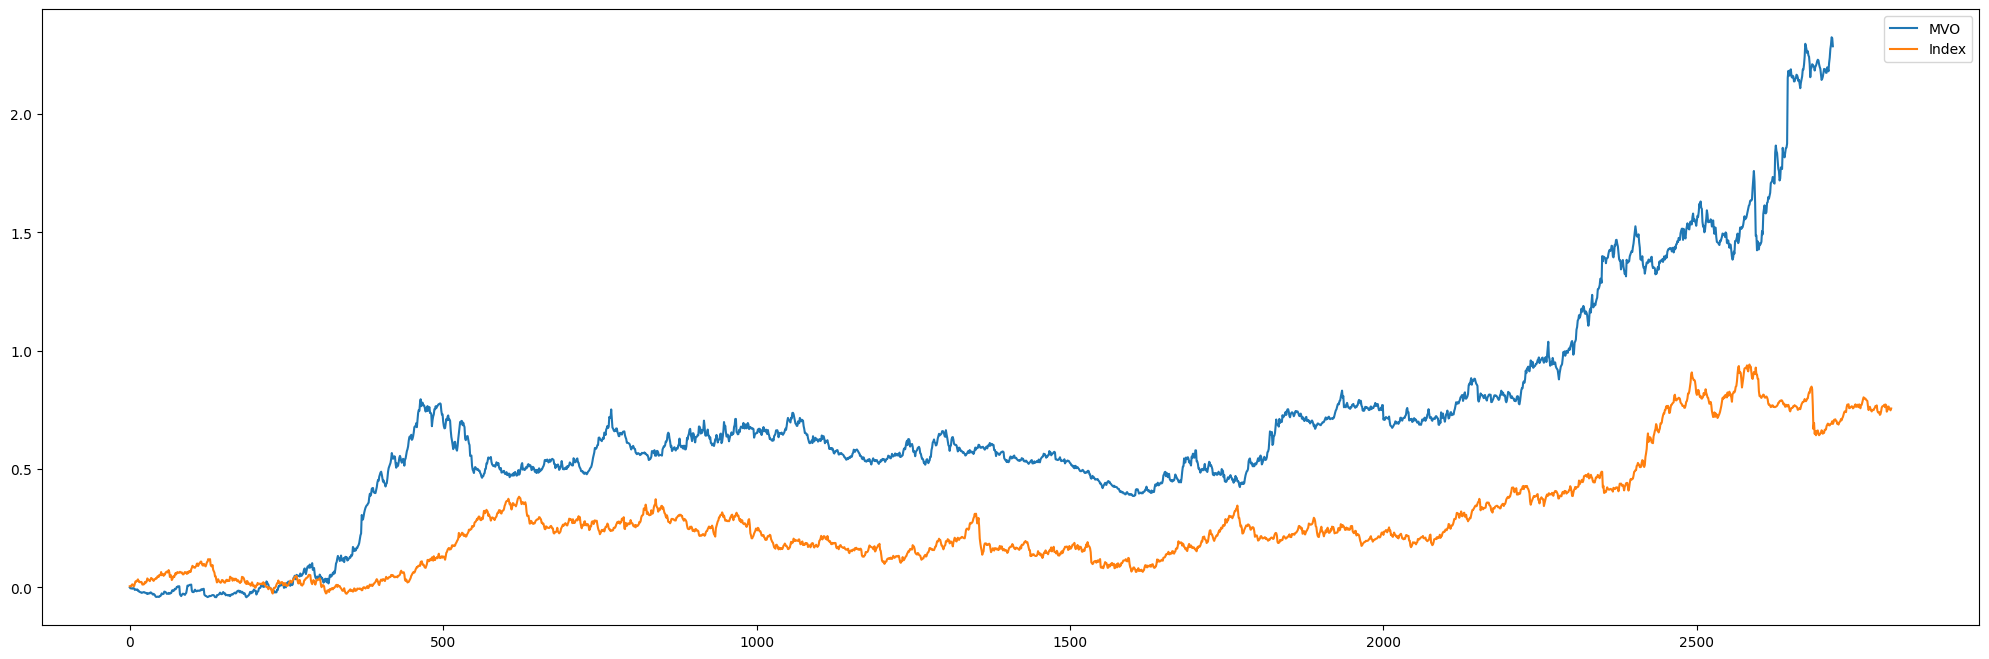

In [ ]:
ret2=np.dot(w,port2.T)
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+ret2)-1,label='MVO')
plt.legend()

plt.plot(np.cumprod(1+btop2.iloc[:,2]).values-1,label='Index')
plt.legend()

In [ ]:
(((np.cumprod(1+ret2))[-1]**(252/len(ret2))-1))/(ret2.std()*np.sqrt(252))

0.9494628994663206

In [ ]:
final_weights=pd.DataFrame()
for i in range(1,68):
  initial_data=port2.iloc[:i*(42),:]
  z = cp.Variable(len(initial_data.columns),) #transformed variable
  k = cp.Variable() #scalar (variable)
  ret = z.T@((initial_data.mean()*252).values)
  sigma_square = cp.quad_form(z, ((initial_data.cov()*252).values))
  objective = cp.Minimize(sigma_square)
  constraints = [
      ret == 1, #adjustable return target constraint
      cp.sum(z) == k,
      z >= 0,
      k >= 0
      ]

  prob = cp.Problem(objective, constraints)

  prob.solve(verbose = False)
  w = (z.value / k.value)
  final_weights=pd.concat([final_weights,pd.DataFrame(w).T])
final_weights

ValueError: ignored

In [ ]:
port_12

Empty DataFrame
Columns: [FV1 Comdty_Strategy, TY1 Comdty_Strategy, CN1 Comdty_Strategy, XM1 Comdty_Strategy, TU1 Comdty_Strategy, RX1 Comdty_Strategy, CO1 Comdty_Strategy, HO1 Comdty_Strategy, CL1 Comdty_Strategy, QS1 Comdty_Strategy, NG1 Comdty_Strategy, KC1 Comdty_Strategy, CT1 Comdty_Strategy, C 1 Comdty_Strategy, LH1 Comdty_Strategy, LC1 Comdty_Strategy, W 1 Comdty_Strategy, SB1 Comdty_Strategy, QC1 Comdty_Strategy, CC1 Comdty_Strategy, BO1 Comdty_Strategy, FC1 Comdty_Strategy, O 1 Comdty_Strategy, HG1 Comdty_Strategy, GC1 Comdty_Strategy, PA1 Comdty_Strategy, PL1 Comdty_Strategy, SI1 Comdty_Strategy, LX1 Comdty_Strategy, CD1 Curncy_Strategy, BP1 Curncy_Strategy, AD1 Curncy_Strategy, JY1 Curncy_Strategy, SF1 Curncy_Strategy, CZK3M Curncy_Strategy, KRW3M Curncy_Strategy, NOK3M Curncy_Strategy, PLN3M Curncy_Strategy, SEK3M Curncy_Strategy, HUF3M Curncy_Strategy, AUD3M Curncy_Strategy, HKD3M Curncy_Strategy, EURCZK3M Curncy_Strategy, CF1 Index_Strategy, Z 1 Index_Strategy, IB1 Index_Strategy, PT1 Index_Strategy, ES1 Index_Strategy, GX1 Index_Strategy, SM1 Index_Strategy, NQ1 Index_Strategy, NK1 Index_Strategy, VG1 Index_Strategy, HI1 Index_Strategy]
Index: []

[0 rows x 54 columns]

In [ ]:
initial_data=pd.concat([port1,port2.loc[port2.index<=pd.to_datetime('2014-12-31')]])
test=port2.loc[(port2.index>pd.to_datetime('2014-12-31'))&(port2.index<=pd.to_datetime('2017-09-01'))]
ind_test=btop2.loc[(btop2.index>=pd.to_datetime('2014-12-31'))&(btop2.index<=pd.to_datetime('2017-09-01')),'Daily_return']
z = cp.Variable(len(initial_data.columns),) #transformed variable
k = cp.Variable() #scalar (variable)
ret = z.T@((initial_data.mean()*252).values)
sigma_square = cp.quad_form(z, ((initial_data.cov()*252).values))
objective = cp.Minimize(sigma_square)
constraints = [ret >= 0.03, #adjustable return target constraint
               cp.sum(z) == k,
               z >= 0,
               k >= 0,
               ]

prob = cp.Problem(objective, constraints)

prob.solve(verbose = False)
w = (z.value / k.value)
w

array([-1.39688319e-22,  1.14411490e-21,  2.67665803e-21,  1.22946532e-21,
        2.09621131e-01,  7.38829732e-03,  2.10055391e-03,  7.93451505e-22,
        1.70999536e-21,  1.09661594e-01,  2.99792075e-21,  2.47820283e-21,
        3.92871776e-02,  3.08958672e-21,  4.39402531e-21,  3.51211327e-21,
        2.38169080e-21,  2.81030047e-21,  7.58369552e-02,  2.46884838e-21,
        5.65834670e-02,  2.26865554e-01,  3.70815939e-21,  9.04832876e-24,
        1.28637291e-01,  1.90821481e-21, -2.52505382e-22,  1.78148375e-21,
        2.56024888e-02,  1.77139467e-21,  3.08805715e-21,  4.65381814e-22,
        2.43830708e-02,  1.70029604e-21,  2.56016263e-21,  2.04115950e-02,
        2.27300668e-21,  3.43548432e-21,  2.48973217e-21,  2.71309765e-21,
        3.42247626e-21,  5.86042828e-22,  3.21745821e-21,  4.78878094e-02,
        1.58053717e-21,  1.57942345e-21,  5.62810209e-22,  5.00120209e-22,
        1.48418096e-22,  1.53278771e-22, -1.29919031e-22,  2.64786057e-03,
        3.44744334e-03,  

In [ ]:
initial_data=port1.loc[port1.index<=pd.to_datetime('2011-12-31')]
test=port1.loc[(port1.index>pd.to_datetime('2011-12-31'))&(port1.index<=pd.to_datetime('2014-12-01'))]
ind_test=btop1.loc[(btop1.index>=pd.to_datetime('2011-12-31'))&(btop1.index<=pd.to_datetime('2014-12-01')),'Daily_return']
z = cp.Variable(len(initial_data.columns),) #transformed variable
k = cp.Variable() #scalar (variable)
ret = z.T@((initial_data.mean()*252).values)
sigma_square = cp.quad_form(z, ((initial_data.cov()*252).values))
objective = cp.Minimize(sigma_square)
constraints = [ret >= 0.03, #adjustable return target constraint
               cp.sum(z) == k,
               z >= 0,
               k >= 0,
               ]

prob = cp.Problem(objective, constraints)

prob.solve(verbose = False)
w = (z.value / k.value)
w

array([ 3.72357434e-23,  1.75506659e-22,  2.93210006e-22,  2.54501325e-22,
        2.48585806e-01,  2.46662845e-22,  3.24303558e-23,  5.58611849e-23,
        1.61739666e-22,  4.77082733e-02,  1.99588976e-22,  1.72058505e-22,
        3.90015777e-02,  1.48161974e-22,  2.51849725e-22,  1.70128538e-22,
        1.67033451e-02,  8.37923531e-03,  9.23741312e-02,  2.10171361e-22,
        5.96344028e-02,  2.13600933e-01,  2.23000565e-22,  2.37688431e-03,
        1.67837602e-01,  1.08179337e-22,  4.57943329e-23,  1.87647645e-22,
        4.92241193e-02,  1.79854059e-22,  1.82360296e-22,  1.44282570e-22,
        2.28933186e-22,  4.36602965e-03,  4.54428855e-22, -1.34169707e-23,
        2.15372706e-22,  3.30274381e-22,  2.30465537e-22,  2.08697275e-22,
        2.70458988e-22,  1.95825637e-22,  1.98760311e-22,  5.02076605e-02,
        2.24289772e-22,  2.08650334e-22,  1.66911513e-22,  1.46222594e-22,
        2.26894269e-22,  1.55900275e-22,  1.35553241e-22,  2.32801706e-22,
        2.04803676e-22,  

In [ ]:
initial_data=pd.concat([port1,port2.loc[port2.index<=pd.to_datetime('2017-12-31')]])
test=port2.loc[(port2.index>pd.to_datetime('2017-12-31'))&(port2.index<=pd.to_datetime('2020-09-01'))]
ind_train=btop2.loc[(btop2.index<=pd.to_datetime('2017-12-31')),'Daily_return']
ind_test=btop2.loc[(btop2.index>=pd.to_datetime('2017-12-31'))&(btop2.index<=pd.to_datetime('2020-09-01')),'Daily_return']
w = cp.Variable(len(initial_data.columns),)
ret = w.T@(initial_data.mean()*252).values
sigma_square = cp.quad_form(w, (initial_data.cov()*252).values)
objective = cp.Maximize(ret)
constraints = [
ret>=0.03,
sigma_square <= ((ind_train.std())**2*(252)),
cp.sum(w) == 1,
w >= 0,
w<=0.08
]

prob = cp.Problem(objective, constraints)
prob.solve(verbose = False)
w=w.value
w.sum()

1.0000000000000717

In [ ]:
initial_data1=pd.concat([port_11,port_12.loc[port_12.index<=pd.to_datetime('2017-12-31')]])
test1=port_12.loc[(port_12.index>pd.to_datetime('2017-12-31'))&(port_12.index<=pd.to_datetime('2020-09-01'))]
ind_train=btop2.loc[(btop2.index<=pd.to_datetime('2017-12-31')),'Daily_return']
ind_test=btop2.loc[(btop2.index>=pd.to_datetime('2017-12-31'))&(btop2.index<=pd.to_datetime('2020-09-01')),'Daily_return']
w1 = cp.Variable(len(initial_data1.columns),)
ret = w1.T@(initial_data1.mean()*252).values
sigma_square = cp.quad_form(w1, (initial_data1.cov()*252).values)
objective = cp.Maximize(ret)
constraints = [
ret>=0.03,
sigma_square <= ((ind_train.std())**2*(252)),
cp.sum(w1) == 1,
w1 >= 0,
w1<=0.08
]

prob = cp.Problem(objective, constraints)
prob.solve(verbose = False)
w1=w1.value
w1.sum()

0.9999999999999905

0.010458191402713634

In [ ]:
initial_data=port_11.loc[port_11.index<=pd.to_datetime('2011-12-31')]
test=port_11.loc[(port_11.index>pd.to_datetime('2011-12-31'))&(port_11.index<=pd.to_datetime('2014-12-01'))]
ind_train=btop1.loc[(btop1.index<=pd.to_datetime('2011-12-31')),'Daily_return']
ind_test=btop1.loc[(btop1.index>=pd.to_datetime('2011-12-31'))&(btop1.index<=pd.to_datetime('2014-12-01')),'Daily_return']
w = cp.Variable(len(initial_data.columns),)
ret = w.T@(initial_data.mean()*252).values
sigma_square = cp.quad_form(w, (initial_data.cov()*252).values)
objective = cp.Maximize(ret)
constraints = [
ret>=1.0,
sigma_square <= ((ind_train.std())**2*(252)),
cp.sum(w) == 1,
w >= 0,
w<=0.08
]

prob = cp.Problem(objective, constraints)
prob.solve(verbose = False)
w=w.value
w.sum()

AttributeError: ignored

In [ ]:
w

array([7.97764867e-11, 1.74685470e-11, 1.50789314e-11, 9.97424594e-11,
       8.00000000e-02, 6.57283407e-11, 6.33825280e-02, 4.27567264e-11,
       1.69593506e-11, 6.22661275e-02, 1.78458081e-10, 3.76930954e-11,
       2.96129710e-02, 1.29616014e-11, 4.36701556e-11, 2.70547710e-03,
       5.09804815e-10, 3.69880901e-11, 5.75030786e-02, 1.92478604e-11,
       5.85022019e-02, 8.00000000e-02, 1.07841478e-11, 1.80701853e-02,
       7.14461346e-02, 6.42941771e-03, 6.73105582e-11, 1.37383874e-11,
       1.51485900e-10, 4.67544772e-11, 1.47778427e-11, 1.83355004e-11,
       8.57147005e-03, 9.97831375e-12, 3.40503364e-02, 1.51325909e-10,
       1.18038896e-11, 3.02091847e-11, 2.10925989e-11, 1.62937628e-11,
       1.62507622e-11, 7.99999996e-02, 5.96770780e-02, 1.02611223e-11,
       1.16760343e-11, 5.01040129e-11, 3.25200189e-11, 3.54236922e-02,
       7.15232386e-11, 2.39981383e-10, 6.71552954e-03, 3.82622440e-02,
       7.64899535e-12, 1.49585654e-10, 7.99999998e-02, 5.36342642e-10,
      

In [ ]:
w1

array([1.36467688e-10, 2.64093576e-11, 2.43022703e-11, 1.34350760e-10,
       8.00000000e-02, 1.09954548e-10, 6.81550207e-02, 7.03336068e-11,
       2.89611643e-11, 6.50283822e-02, 3.75059316e-10, 4.18150719e-11,
       3.69943465e-02, 1.84232264e-11, 6.52734432e-11, 1.39325803e-03,
       3.86177646e-10, 5.31290157e-11, 6.22305715e-02, 3.27565915e-11,
       6.28046084e-02, 8.00000000e-02, 1.76070910e-11, 2.02286669e-02,
       7.83537106e-02, 9.23247209e-03, 9.76570469e-11, 2.19933378e-11,
       8.38997467e-11, 1.11429047e-10, 2.63688831e-11, 3.58511428e-11,
       1.65247114e-02, 2.02688767e-11, 7.75615199e-12, 4.28251898e-12,
       1.85909509e-11, 2.70481998e-10, 3.84886703e-11, 1.48985022e-11,
       3.23019633e-11, 7.35431510e-02, 5.34396785e-13, 1.73463029e-11,
       2.02746005e-11, 1.30958188e-10, 4.99684491e-11, 3.36862676e-02,
       1.68619474e-10, 8.27414950e-10, 1.15654918e-02, 3.95550802e-02,
       1.16561960e-11, 9.80718879e-10, 7.99999997e-02, 4.78498887e-02,
      

In [ ]:
test_ret=test.mul(w, axis=1).sum(axis=1)
test_ret

2018-01-02    0.008786
2018-01-03    0.005810
2018-01-04    0.009741
2018-01-05   -0.001355
2018-01-08   -0.003528
                ...   
2020-08-26    0.003584
2020-08-27   -0.000404
2020-08-28    0.002023
2020-08-31    0.000744
2020-09-01    0.000603
Length: 672, dtype: float64

In [ ]:
test_ret1=test1.mul(w1, axis=1).sum(axis=1)
test_ret1

2018-01-02    0.007661
2018-01-03    0.007197
2018-01-04    0.009379
2018-01-05    0.000163
2018-01-08   -0.000480
                ...   
2020-08-26    0.003876
2020-08-27   -0.000601
2020-08-28    0.002941
2020-08-31    0.000733
2020-09-01    0.000942
Length: 672, dtype: float64

In [ ]:
len(test_ret1)

672

In [ ]:
ind_test

Date
2018-01-01    0.000058
2018-01-02   -0.000915
2018-01-03    0.011732
2018-01-04    0.016382
2018-01-05    0.004845
                ...   
2020-08-26    0.002797
2020-08-27   -0.006042
2020-08-28    0.009231
2020-08-31    0.002222
2020-09-01    0.002827
Name: Daily_return, Length: 697, dtype: float64

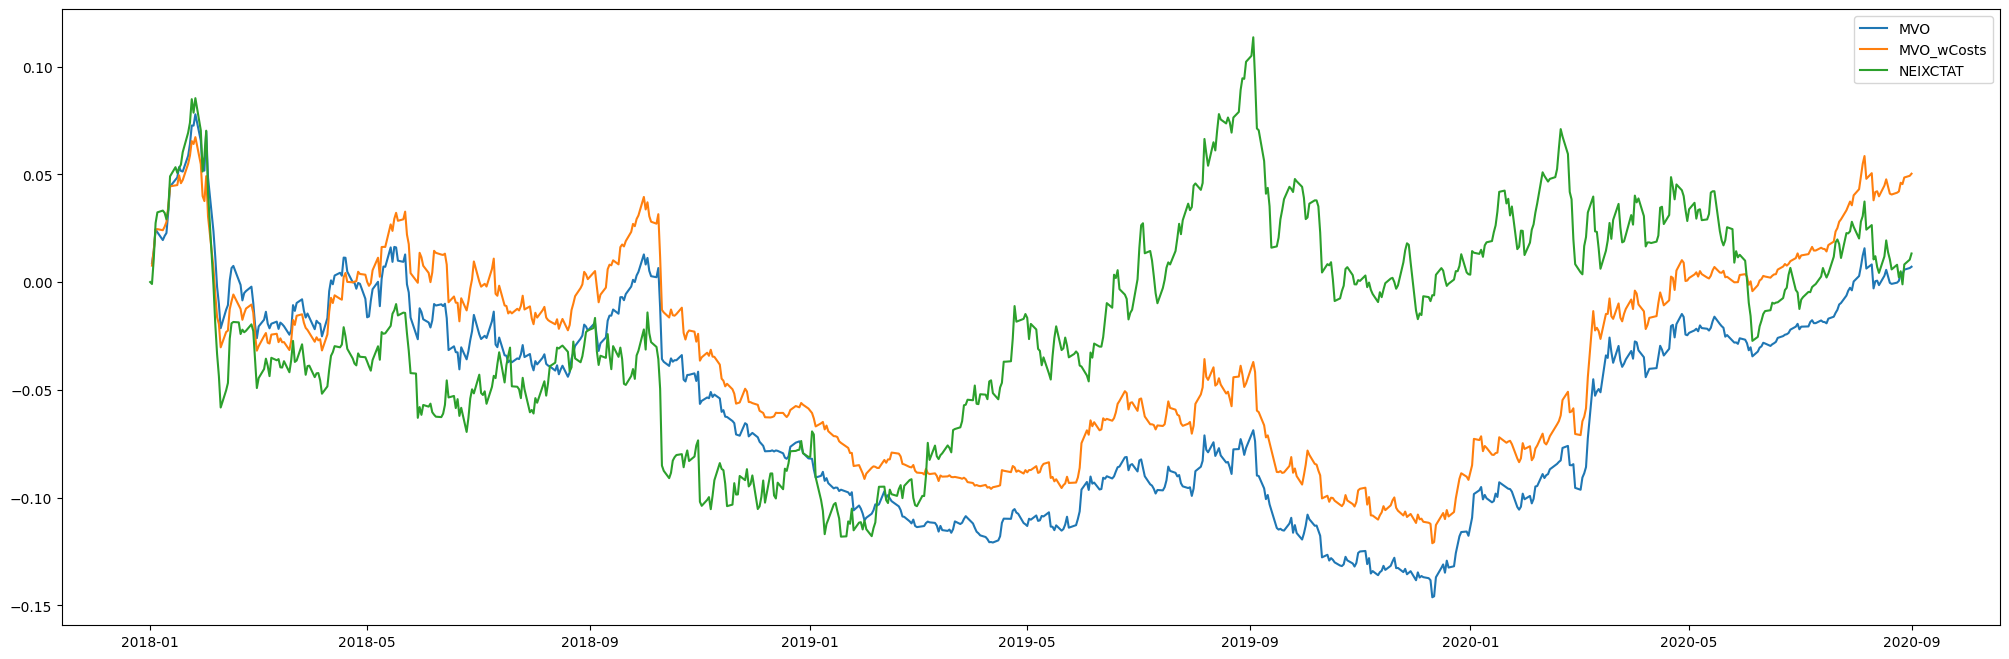

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+test_ret)-1,label='MVO')
plt.plot(np.cumprod(1+test_ret1)-1,label='MVO_wCosts')
plt.plot(np.cumprod(1+ind_test)-1,label='NEIXCTAT')
plt.legend()

Date
2018-01-01    0.000058
2018-01-02   -0.000915
2018-01-03    0.011732
2018-01-04    0.016382
2018-01-05    0.004845
                ...   
2020-08-26    0.002797
2020-08-27   -0.006042
2020-08-28    0.009231
2020-08-31    0.002222
2020-09-01    0.002827
Name: Daily_return, Length: 697, dtype: float64

In [ ]:
np.cumprod(1+test_ret)-1

array([ 8.78563303e-03,  1.46470468e-02,  2.45311401e-02,  2.31425191e-02,
        1.95328431e-02,  2.14474246e-02,  2.28026033e-02,  3.25699936e-02,
        4.43775196e-02,  4.85932571e-02,  5.33910345e-02,  5.16353890e-02,
        5.13290394e-02,  5.86620689e-02,  6.40534695e-02,  7.26877823e-02,
        7.26628699e-02,  7.79191725e-02,  6.56701052e-02,  5.20815466e-02,
        5.17677611e-02,  7.00164979e-02,  4.85384400e-02,  2.35781587e-02,
        1.17107881e-02, -2.15110283e-03, -1.00810354e-02, -2.13842730e-02,
       -1.28345043e-02, -1.06503907e-02,  8.00181913e-04,  6.55588502e-03,
        7.53205788e-03, -1.29807598e-03, -8.46860859e-03, -5.08563644e-03,
       -4.13278569e-03, -2.09994121e-03, -9.58769638e-03, -1.97420196e-02,
       -2.60172569e-02, -2.05514335e-02, -1.74133330e-02, -1.37420853e-02,
       -1.92484894e-02, -2.14341182e-02, -1.93058652e-02, -1.83221976e-02,
       -2.16945903e-02, -1.87837390e-02, -1.95097991e-02, -2.04763972e-02,
       -2.43897381e-02, -

In [ ]:
final_weights=final_weights.reset_index(drop=True)
final_weights

0             1             2             3             4   \
0   7.483557e-03 -4.242817e-23  7.383024e-23  1.506240e-22  4.660131e-23   
1   3.780354e-03 -4.958882e-23  5.469402e-23  1.262200e-22  3.134025e-23   
2   6.104767e-23  6.241219e-23  1.062206e-22  1.526161e-22  1.125141e-22   
3   1.532341e-02 -4.765282e-23  8.893382e-23  2.238201e-22  7.466985e-23   
4   3.833572e-02 -2.989246e-23  3.759719e-23  9.082824e-23  3.124181e-23   
..           ...           ...           ...           ...           ...   
62  5.706094e-02  1.322931e-21  1.463158e-21  1.219777e-21  2.582585e-01   
63  5.116596e-02  1.239933e-21  1.429298e-21  1.186416e-21  2.602889e-01   
64  6.980507e-02  1.229748e-21  1.510441e-21  1.362399e-21  2.172745e-01   
65  6.682733e-02  1.156487e-21  1.287607e-21  1.059403e-21  2.245825e-01   
66  6.716539e-02  1.172649e-21  1.312452e-21  1.074988e-21  2.296779e-01   

          5             6             7             8         9   ...  \
0   0.108428  6.901314e-23  8.770962e-23  1.208329e-22  0.106347  ...   
1   0.098316  5.209044e-23  6.931006e-23  9.188614e-23  0.104994  ...   
2   0.092443  7.669613e-23  7.757985e-23  1.152856e-22  0.108154  ...   
3   0.087874  9.595171e-23  9.510227e-23  1.677570e-22  0.105143  ...   
4   0.080746  5.061831e-23  6.422724e-23  8.314247e-23  0.108529  ...   
..       ...           ...           ...           ...       ...  ...   
62  0.021116  9.887316e-03  9.565816e-23  1.028945e-02  0.190654  ...   
63  0.020256  4.516253e-03  8.588966e-23  1.104728e-02  0.189305  ...   
64  0.013578  9.522878e-04  4.782341e-23  1.268185e-02  0.197334  ...   
65  0.013065  9.024833e-04 -1.627794e-24  1.103403e-02  0.203446  ...   
66  0.012556  1.062502e-22  1.018148e-22  1.147370e-02  0.206816  ...   

          21            22            23            24            25  \
0   0.262909  6.305559e-23  9.441869e-23  8.714748e-23  8.145589e-23   
1   0.257799  5.261258e-23  7.198956e-23  6.937855e-23  6.868954e-23   
2   0.218252  5.201409e-23  6.846719e-23  4.548350e-23  5.945947e-23   
3   0.222270  9.729409e-23  1.113021e-22  1.074447e-22  8.362556e-23   
4   0.221856  5.767127e-23  6.390431e-23  4.714691e-23  4.598939e-23   
..       ...           ...           ...           ...           ...   
62  0.187017  9.455843e-22  5.277262e-22  3.098309e-22  2.933206e-22   
63  0.186949  9.447014e-22  5.173237e-22  3.156805e-22  3.115292e-22   
64  0.191614  1.031946e-21  5.652510e-22  3.953274e-22  3.612071e-22   
65  0.189393  8.300119e-22  4.433367e-22  2.792151e-22  2.974482e-22   
66  0.192461  8.082752e-22  4.663543e-22  3.037226e-22  3.071814e-22   

              26            27            28            29        30  
0   1.149118e-22  1.392742e-01  9.234798e-23  8.780756e-23  0.047457  
1   4.647745e-23  1.145338e-01  8.480249e-23  7.499722e-23  0.106759  
2   8.178850e-03  9.024668e-02  1.153054e-22  1.009291e-22  0.137803  
3   4.052494e-03  7.915028e-02  1.613226e-22  1.264193e-22  0.129637  
4   2.669720e-23  7.546886e-02  7.569001e-23  5.719327e-23  0.132247  
..           ...           ...           ...           ...       ...  
62  2.517354e-02  1.366981e-21  1.015690e-21  1.524650e-21  0.062323  
63  2.631559e-02  1.353086e-21  9.828363e-22  1.441368e-21  0.058590  
64  2.877425e-02  1.532618e-21  1.002915e-21  1.574767e-21  0.056414  
65  2.656083e-02  1.127139e-21  8.185455e-22  1.256508e-21  0.076262  
66  2.297121e-02  1.136919e-21  8.389537e-22  1.284473e-21  0.079932  

[67 rows x 31 columns]

In [ ]:
oos_ret=pd.DataFrame()
for i in range(1,68):
  temp_data=port2.iloc[i*(42):(i+1)*(42),:]
  ret=np.dot(np.array(final_weights.iloc[i-1,:]),temp_data.T.values)
  oos_ret=pd.concat([oos_ret,pd.Series(ret)])
oos_ret

0
0   0.008652
1  -0.011707
2  -0.004830
3   0.004287
4   0.000622
..       ...
16  0.004090
17 -0.012779
18 -0.005444
19 -0.000042
20  0.008659

[2793 rows x 1 columns]

In [ ]:
oos_ret=oos_ret.reset_index(drop=True)
oos_ret

0
0     0.008652
1    -0.011707
2    -0.004830
3     0.004287
4     0.000622
...        ...
2788  0.004090
2789 -0.012779
2790 -0.005444
2791 -0.000042
2792  0.008659

[2793 rows x 1 columns]

In [ ]:
btop2.iloc[42:,2]

Date
2012-12-19    0.001634
2012-12-20   -0.001359
2012-12-21   -0.009550
2012-12-24   -0.000180
2012-12-25    0.000467
                ...   
2023-08-28    0.000277
2023-08-29   -0.005373
2023-08-30   -0.000968
2023-08-31   -0.002674
2023-09-01    0.004465
Name: Daily_return, Length: 2793, dtype: float64

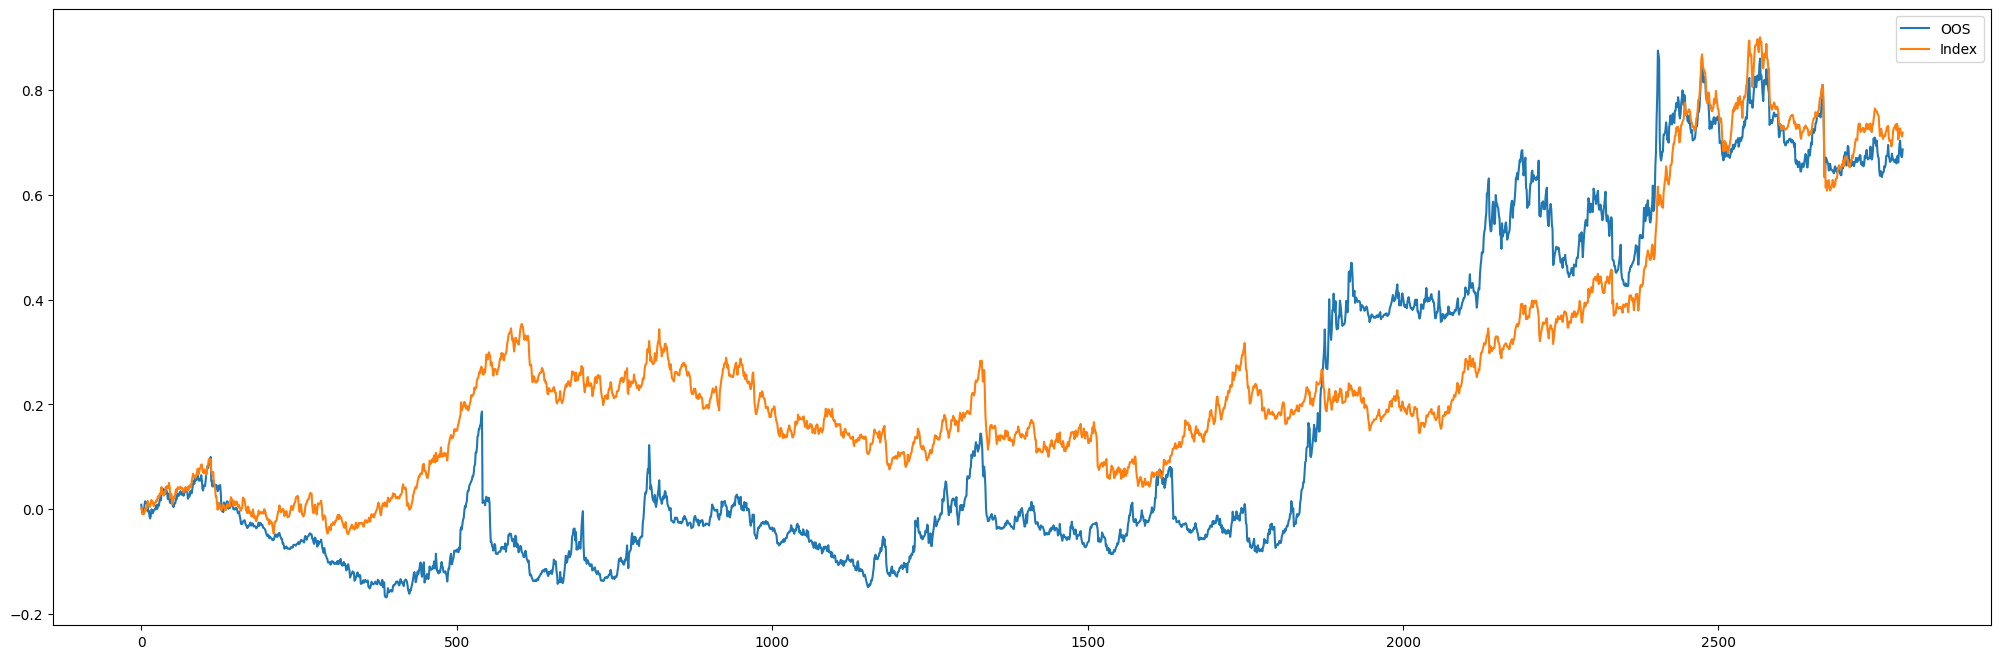

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+oos_ret)-1,label='OOS')
plt.plot(np.cumprod(1+btop2.iloc[42:,2]).values-1,label='Index')
plt.legend()

In [ ]:
cum_ret=np.cumprod(1+btop2.iloc[:,2]).iloc[len(btop2.iloc[:,2])-1]
ann_ret=((cum_ret)**(252/len(btop2.iloc[:,2])))-1
ann_ret/(btop2.iloc[:,2].std()*np.sqrt(252))

0.45907415805295637

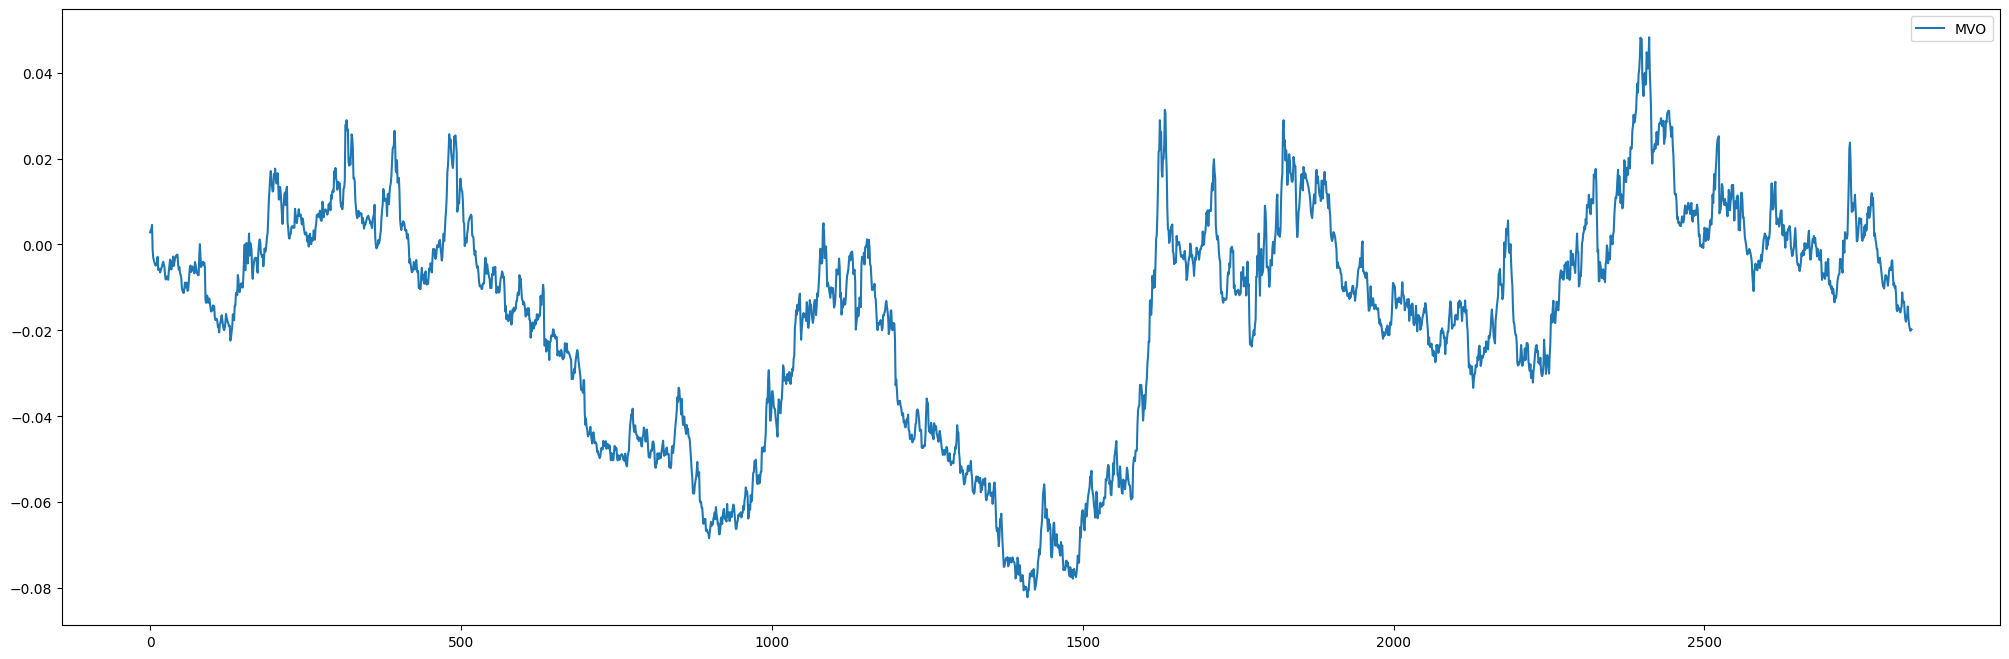

In [ ]:
ret2=np.dot(optimized_weights,port1.T)
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+ret2)-1,label='MVO')
#plt.plot(np.cumprod(1+btop1.iloc[:,2]).values-1,label='Index')
plt.legend()

0.1334886131942627

In [ ]:
import numpy as np
from scipy.optimize import minimize
optimized_weights=pd.DataFrame()
for i in range(len(port2)):
  # Define the objective function
  def objective(weights,expected_returns, returns, hurst_exponents):
    expected_return = np.dot(expected_returns,weights)
    expected_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    fractal_score = np.mean(hurst_exponents)  # Simplified for illustration

    # Define a metric that combines return, volatility, and fractal dimension (Hurst Exponent)
    portfolio_metric = -(expected_return / expected_volatility)#* fractal_score

    return portfolio_metric

  # Define the historical returns and Hurst Exponents
  # ... (Assuming you have these precomputed)
  rf=0.03
  if(i==0):
    ind_ret=btop2.iloc[:(i),2].mean()
  else:
    ind_ret=btop2.iloc[:(i-1),2].mean()
  returns=port2[:(i)]
  expected_returns=[0]*31
  for i in range(len(beta)):
    expected_returns[i]=rf+beta.iloc[i,0]*(ind_ret-rf)
  initial_weights = np.ones(len(returns.columns)) / len(returns.columns)
  hurst_exponents=np.array([0.775,0.7696, 0.76859, 0.7656,0.7686,0.77062])
  # Define optimization bounds (weights between 0 and 1)
  bounds = [(0.01, 1) for _ in range(len(returns.columns))]
  constraint1 = {'type':'eq','fun':lambda weights:np.sum(weights)-1}
  constraints=[constraint1]
  # Define other constraints if necessary
  # Perform optimization
  result = minimize(
      lambda weights: objective(weights,expected_returns, returns, hurst_exponents),
      initial_weights,
      constraints = constraints,
      bounds=bounds,
      method='SLSQP'
      )

  # Extract the optimized weights
  optimized_weights = pd.concat([optimized_weights,pd.DataFrame(result.x).T])

KeyboardInterrupt: ignored

0    1.000000
0    1.000000
0    1.017443
0    1.000181
0    1.001168
       ...   
0    1.000000
0    1.000000
0    1.000000
0    1.000000
0    1.000000
Length: 1464, dtype: float64

In [ ]:
btop_monthly=btop_monthly.loc[btop_monthly.index>=pd.to_datetime("2001-12-11",format='%Y-%m-%d')]


btop_monthly['Cum_Ret']=np.cumprod(1+btop_monthly['Daily_return'])-1
btop_monthly=btop_monthly.dropna()
btop_monthly

Price    Volume  Daily_return   Cum_Ret
Date                                                  
2001-12-11  1090.108  1090.108      0.001600  0.001600
2001-12-12  1082.041  1082.041     -0.007400 -0.005812
2001-12-13  1086.045  1086.045      0.003700 -0.002133
2001-12-14  1091.584  1091.584      0.005100  0.002956
2001-12-17   1102.39   1102.39      0.009899  0.012884
...              ...       ...           ...       ...
2023-09-08  3860.777  3860.777      0.003296  2.547312
2023-09-11  3862.454  3862.454      0.000434  2.548853
2023-09-12  3873.043  3873.043      0.002742  2.558582
2023-09-13  3870.621  3870.621     -0.000625  2.556356
2023-09-14  3892.252  3892.252      0.005589  2.576231

[5678 rows x 4 columns]

In [ ]:
agri_port.corr()

AGRI_strategy_returns  Daily_return
AGRI_strategy_returns                1.00000       0.22996
Daily_return                         0.22996       1.00000

In [ ]:
final_p=pd.DataFrame(basket_final['Portfolio_Ret'])
final_p=pd.concat([final_p,btop_monthly.Daily_return],axis=1)
final_p['Index_Cum']=np.cumprod(1+final_p['Daily_return'])-1
final_p['Port_Cum']=np.cumprod(1+final_p['Portfolio_Ret'])-1
final_p=final_p.dropna()
final_p.loc[:,['Index_Cum','Port_Cum']].corr()

Index_Cum  Port_Cum
Index_Cum   1.000000  0.952725
Port_Cum    0.952725  1.000000

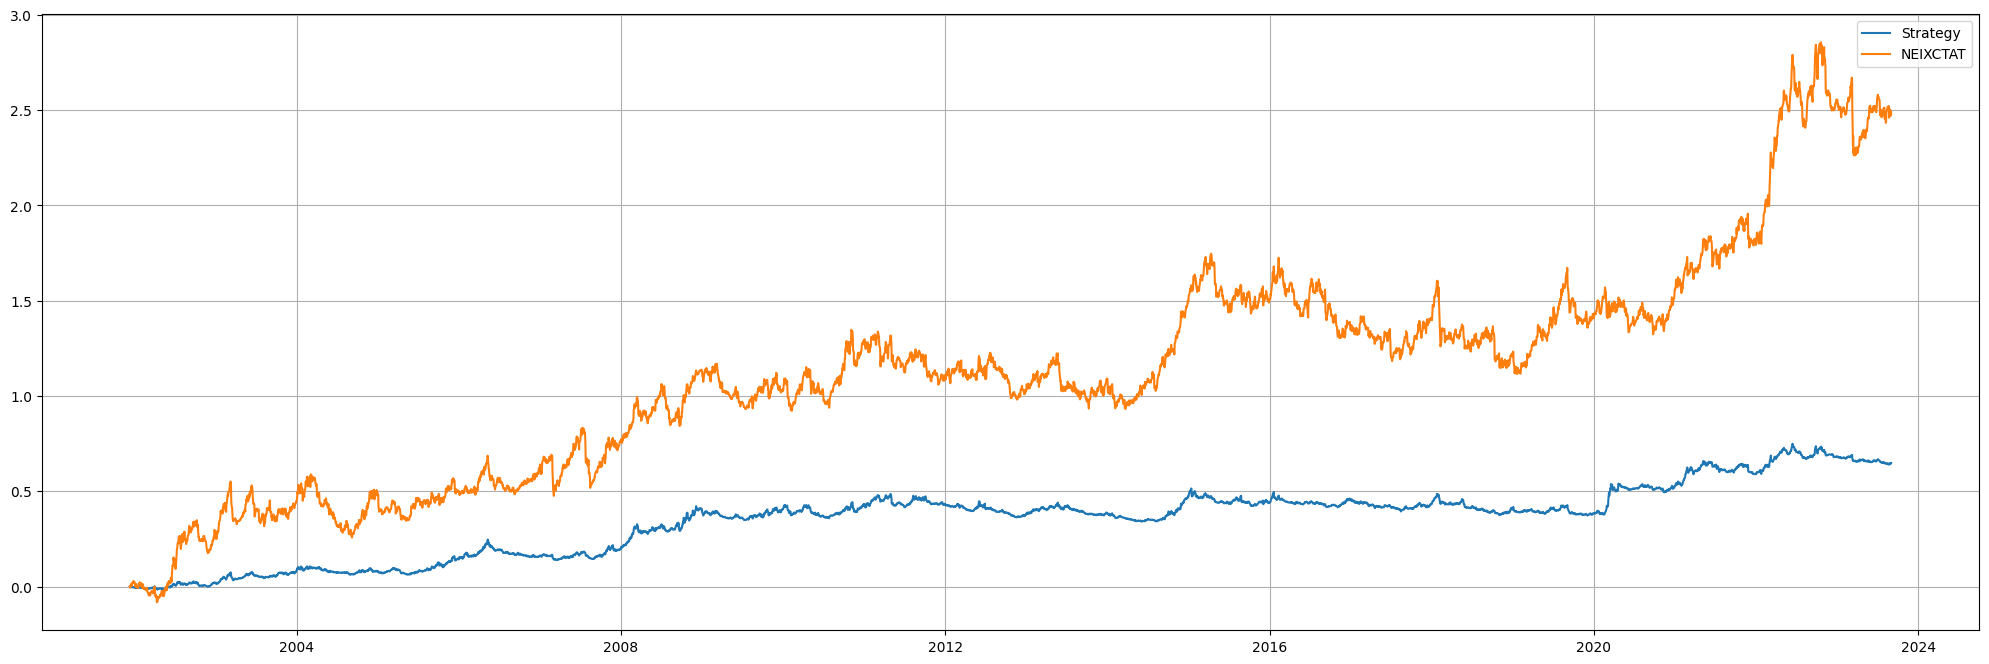

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(final_p['Port_Cum'],label='Strategy')
plt.plot(final_p['Index_Cum'],label='NEIXCTAT')
plt.legend()
plt.grid()


In [ ]:
(((1+final_p['Port_Cum'][-1])**(252/len(final_p)))-1)/(final_p['Portfolio_Ret'].std()*np.sqrt(252))

0.054205583436814475

In [ ]:
basket_final2=basket_final.iloc[:,:6]
basket_final2

BONDS_strategy_returns  AGRI_strategy_returns  \
2001-12-11                0.000917               0.010531   
2001-12-12                0.000682               0.001998   
2001-12-13               -0.004066               0.003613   
2001-12-14               -0.000270               0.001901   
2001-12-17                0.000435              -0.026036   
...                            ...                    ...   
2023-08-28               -0.002302               0.003274   
2023-08-29               -0.012289               0.009261   
2023-08-30               -0.001258              -0.001809   
2023-08-31               -0.003852               0.002973   
2023-09-01                0.001360               0.003012   

            ENER_strategy_returns  MET_strategy_returns  CUR_strategy_returns  \
2001-12-11               0.003762              0.003848             -0.000223   
2001-12-12              -0.002087              0.001618             -0.001938   
2001-12-13              -0.003423             -0.001684             -0.001773   
2001-12-14              -0.011479             -0.001039              0.006005   
2001-12-17              -0.000465             -0.000685              0.001545   
...                           ...                   ...                   ...   
2023-08-28              -0.003174             -0.001259              0.000887   
2023-08-29               0.000175              0.000885             -0.004564   
2023-08-30              -0.006566              0.002001              0.001422   
2023-08-31               0.004367             -0.000515             -0.005783   
2023-09-01               0.005313             -0.001735              0.003030   

            EQ_strategy_returns  
2001-12-11             0.001675  
2001-12-12            -0.003177  
2001-12-13             0.004046  
2001-12-14             0.002986  
2001-12-17            -0.002036  
...                         ...  
2023-08-28             0.009514  
2023-08-29             0.000561  
2023-08-30             0.001232  
2023-08-31             0.004071  
2023-09-01             0.004299  

[5669 rows x 6 columns]

In [ ]:
basket_returns2[]

In [ ]:
import numpy as np
from scipy.optimize import minimize
optimized_weights=pd.DataFrame()
for i in range(len(basket_final2)-1):
  # Define the objective function
  def objective(weights,expected_returns, returns, hurst_exponents):
    expected_return = np.dot(expected_returns,weights)
    expected_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    fractal_score = np.mean(hurst_exponents)  # Simplified for illustration

    # Define a metric that combines return, volatility, and fractal dimension (Hurst Exponent)
    portfolio_metric = -(expected_return / expected_volatility)#* fractal_score

    return portfolio_metric

  # Define the historical returns and Hurst Exponents
  # ... (Assuming you have these precomputed)
  rf=0.03
  ind_ret=btop_monthly.iloc[:(i),2].mean()
  returns=basket_final2[:(i)]
  expected_returns=np.array([rf+bond_beta*(rf-ind_ret),rf+agri_beta*(rf-ind_ret),rf+ener_beta*(rf-ind_ret),rf+met_beta*(rf-ind_ret),rf+cur_beta*(rf-ind_ret),rf+eq_beta*(rf-ind_ret)])
  # Set an initial guess for the weights
  initial_weights = np.ones(len(returns.columns)) / len(returns.columns)
  hurst_exponents=np.array([0.775,0.7696, 0.76859, 0.7656,0.7686,0.77062])
  # Define optimization bounds (weights between 0 and 1)
  bounds = [(0.01, 1) for _ in range(len(returns.columns))]
  constraint1 = {'type':'eq','fun':lambda weights:np.sum(weights)-1}
  constraints=[constraint1]
  # Define other constraints if necessary
  # Perform optimization
  result = minimize(
      lambda weights: objective(weights,expected_returns, returns, hurst_exponents),
      initial_weights,
      constraints = constraints,
      bounds=bounds,
      method='SLSQP'
      )

  # Extract the optimized weights
  optimized_weights = pd.concat([optimized_weights,pd.DataFrame(result.x).T])

In [ ]:


np.dot(returns.cov(), np.ones(6)/6)

array([3.05108923e-06, 4.18930280e-06, 4.06832400e-06, 5.99627863e-06,
       6.67265516e-06, 2.82877926e-06])

In [ ]:
basket_final2[:(i+1)*(126)].cov()

BONDS_strategy_returns  AGRI_strategy_returns  \
BONDS_strategy_returns            1.297767e-05           1.331821e-06   
AGRI_strategy_returns             1.331821e-06           2.854699e-05   
ENER_strategy_returns             1.109808e-06          -3.435872e-06   
MET_strategy_returns              1.881892e-06           1.679594e-06   
CUR_strategy_returns              1.248591e-06          -2.815380e-06   
EQ_strategy_returns              -2.432473e-07          -1.713331e-07   

                        ENER_strategy_returns  MET_strategy_returns  \
BONDS_strategy_returns           1.109808e-06              0.000002   
AGRI_strategy_returns           -3.435872e-06              0.000002   
ENER_strategy_returns            2.664952e-05              0.000004   
MET_strategy_returns             4.416542e-06              0.000019   
CUR_strategy_returns            -4.592154e-06              0.000006   
EQ_strategy_returns              2.620990e-07              0.000003   

                        CUR_strategy_returns  EQ_strategy_returns  
BONDS_strategy_returns              0.000001        -2.432473e-07  
AGRI_strategy_returns              -0.000003        -1.713331e-07  
ENER_strategy_returns              -0.000005         2.620990e-07  
MET_strategy_returns                0.000006         2.833883e-06  
CUR_strategy_returns                0.000036         4.776153e-06  
EQ_strategy_returns                 0.000005         9.515121e-06

In [ ]:
rf+bond_beta*(rf-ind_ret)

TypeError: ignored

In [ ]:
optimized_weights=optimized_weights.reset_index(drop=True)
optimized_weights

0         1         2         3         4         5
0     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
1     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
2     0.950000  0.010000  0.010000  0.010000  0.010000  0.010000
3     0.010000  0.010000  0.010000  0.010000  0.950000  0.010000
4     0.539512  0.010000  0.038586  0.010000  0.010000  0.391902
...        ...       ...       ...       ...       ...       ...
5663  0.230294  0.217043  0.119245  0.099837  0.101499  0.232081
5664  0.230279  0.216946  0.119179  0.099881  0.101506  0.232209
5665  0.230309  0.216936  0.119205  0.099900  0.101506  0.232144
5666  0.230268  0.216967  0.119205  0.099902  0.101493  0.232164
5667  0.230266  0.216964  0.119189  0.099910  0.101499  0.232172

[5668 rows x 6 columns]

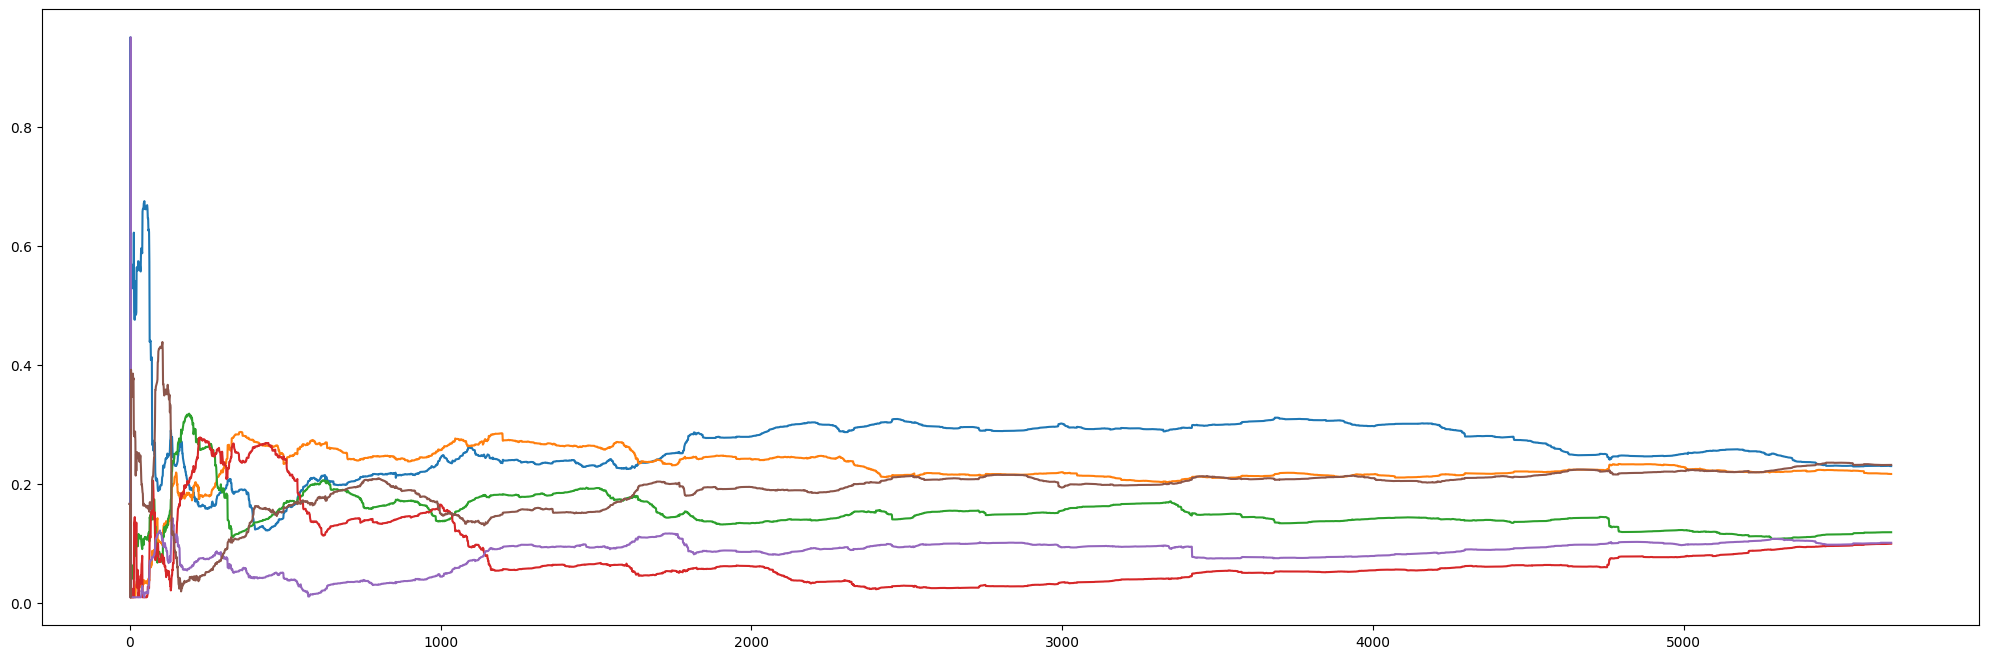

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(optimized_weights)

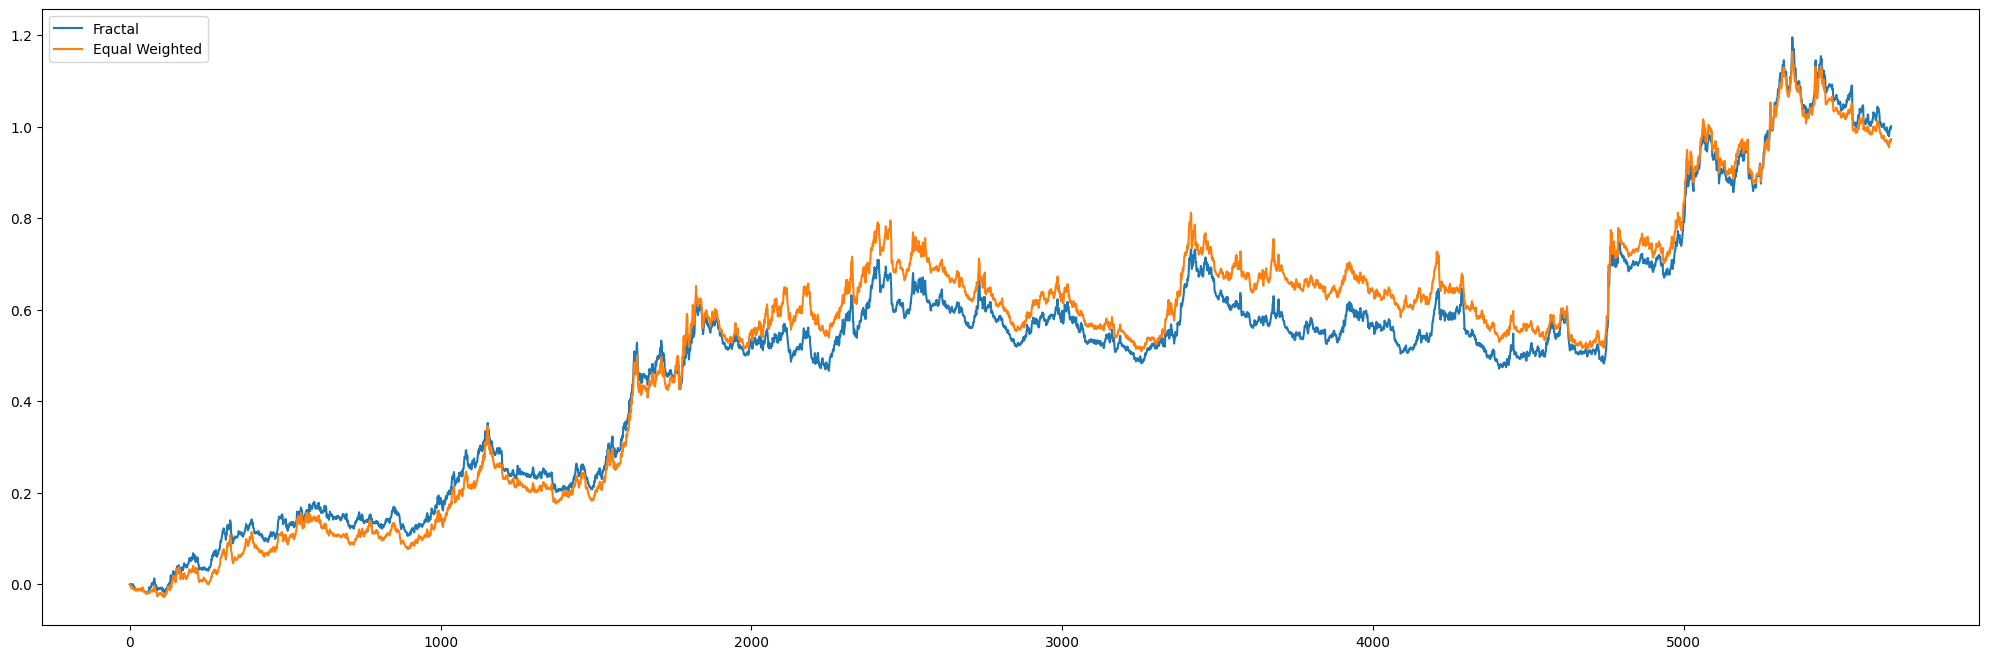

In [ ]:
pre=pd.DataFrame()
for i in range(1,len(basket_final2)):
  x=pd.Series(np.dot(np.array(optimized_weights.iloc[i-1,:]),basket_final2.iloc[i,:].values.T))
  #corr_x=basket_final2[i].corr()
  #norm_factor_x=np.sqrt(np.dot(np.array(optimized_weights.iloc[i-1,:]).T,np.dot(corr_x,np.array(optimized_weights.iloc[i-1,:]))))
  pre=pd.concat([pre,x])

pre=pre.reset_index(drop=True)
plt.figure(figsize=(25,8))
post=np.dot(initial_weights,basket_final2[1:].T)#/norm_factor
plt.plot(np.cumprod(1+pre)-1,label='Fractal')
plt.plot(np.cumprod(1+post)-1,label='Equal Weighted')
plt.legend()

In [ ]:
np.dot(np.array(optimized_weights.iloc[i-1,:]),basket_final2.iloc[i,:].values.T)

0.002727406217254957

In [ ]:
(((np.cumprod(1+pre)).iloc[5667]**(252/len(pre)))-1)

0.03067584217980701

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define expected returns and covariance matrix (example data)
returns=basket_final2.iloc[int(len(basket_final2)/4):int(len(basket_final2)/2)]
expected_returns = np.array(returns.mean())
covariance_matrix = np.array(returns.cov())

# Define the risk-free rate (example, you can set your own)
risk_free_rate = 0.03

# Define the negative of STARR ratio as the objective function
def neg_starr_ratio(weights):
    expected_return = np.sum(expected_returns * weights)
    risk = np.sqrt(np.dot(weights, np.dot(covariance_matrix, weights)))
    starr_ratio = (expected_return - risk_free_rate) / risk
    return -starr_ratio

# Define the equality constraint for weights
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Define the bounds for weights
bounds = tuple((0.01, 1) for asset in range(len(expected_returns)))

# Initialize weights
initial_weights = [1./len(expected_returns) for asset in expected_returns]

# Perform optimization
result = minimize(neg_starr_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = result.x

print(f"Optimal Weights: {optimal_weights}")

Optimal Weights: [0.01 0.01 0.01 0.95 0.01 0.01]


In [ ]:
(np.cumprod(1+returns)-1).

SyntaxError: ignored

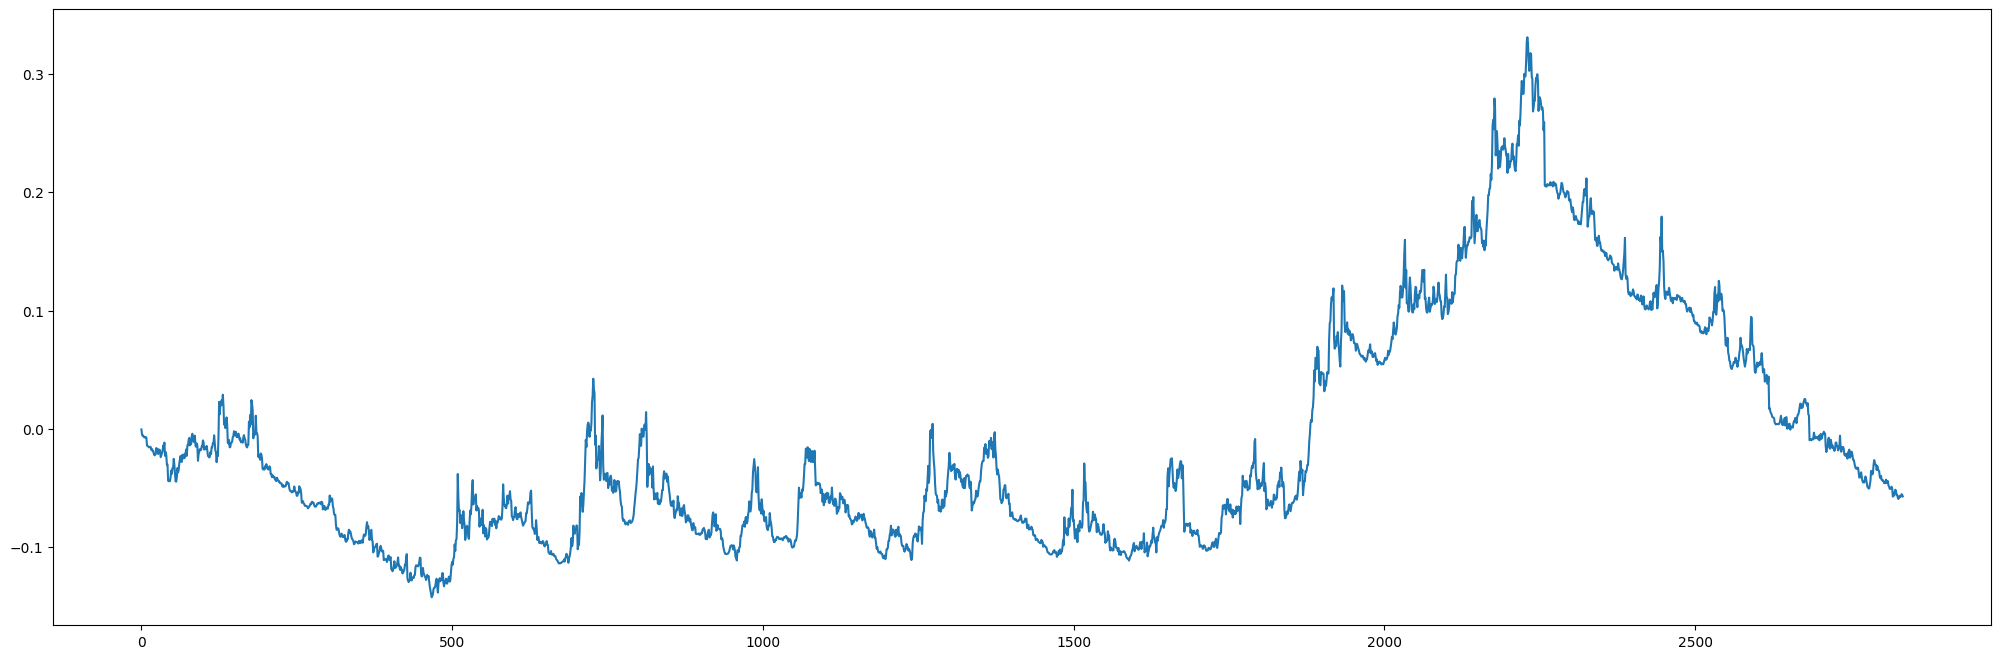

In [ ]:
beb=np.dot(optimal_weights,basket_final2.iloc[int(len(basket_final2)/2):].T)
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+beb)-1)

In [ ]:
signals3['']

In [ ]:
ret_lstm=pd.DataFrame()
ret_norm=pd.DataFrame()

In [ ]:
for i in signals3.keys():
  ret_lstm=pd.concat([ret_lstm,signals3[i][f'{i}_LSTM_Strat']],axis=1)
  ret_norm=pd.concat([ret_lstm,signals3[i][f'{i}_Strat']],axis=1)

In [ ]:
ret_lstm

FV1 Comdty_LSTM_Strat  TY1 Comdty_LSTM_Strat  \
2020-06-08              -0.000054               0.004298   
2020-06-09              -0.002819               0.000603   
2020-06-10              -0.004900               0.000932   
2020-06-11              -0.000557               0.000106   
2020-06-12              -0.000060              -0.000622   
...                           ...                    ...   
2023-08-28               0.000618               0.001342   
2023-08-29               0.001079               0.008275   
2023-08-30               0.000222              -0.000101   
2023-08-31              -0.002043              -0.000627   
2023-09-01                    NaN                    NaN   

            CN1 Comdty_LSTM_Strat  XM1 Comdty_LSTM_Strat  \
2020-06-08              -0.001971               0.002555   
2020-06-09               0.009453               0.006933   
2020-06-10               0.017240              -0.003348   
2020-06-11               0.001267               0.020885   
2020-06-12              -0.000728               0.000215   
...                           ...                    ...   
2023-08-28              -0.001870               0.000406   
2023-08-29              -0.003071               0.001546   
2023-08-30               0.004922               0.001264   
2023-08-31               0.000797               0.000458   
2023-09-01                    NaN                    NaN   

            TU1 Comdty_LSTM_Strat  RX1 Comdty_LSTM_Strat  \
2020-06-08               0.000094               0.003414   
2020-06-09              -0.000111               0.010997   
2020-06-10              -0.000425               0.003300   
2020-06-11               0.000029              -0.002824   
2020-06-12               0.000699               0.003684   
...                           ...                    ...   
2023-08-28              -0.002885              -0.002873   
2023-08-29               0.005900               0.002249   
2023-08-30              -0.000954              -0.000982   
2023-08-31               0.000332               0.008061   
2023-09-01                    NaN                    NaN   

            KC1 Comdty_LSTM_Strat  CT1 Comdty_LSTM_Strat  \
2020-06-08               0.000000               0.001206   
2020-06-09              -0.002451              -0.000363   
2020-06-10              -0.000704              -0.000020   
2020-06-11              -0.000315              -0.002125   
2020-06-12              -0.001391              -0.000302   
...                           ...                    ...   
2023-08-28               0.000154              -0.000694   
2023-08-29              -0.001036               0.000028   
2023-08-30               0.000346               0.001372   
2023-08-31              -0.000174              -0.000149   
2023-09-01                    NaN                    NaN   

            C 1 Comdty_LSTM_Strat  LH1 Comdty_LSTM_Strat  ...  \
2020-06-08               0.002275               0.001233  ...   
2020-06-09              -0.003454              -0.001808  ...   
2020-06-10              -0.000627               0.000288  ...   
2020-06-11               0.001090              -0.000291  ...   
2020-06-12               0.000091               0.000114  ...   
...                           ...                    ...  ...   
2023-08-28               0.001025               0.011228  ...   
2023-08-29              -0.002682              -0.001064  ...   
2023-08-30              -0.003270              -0.001948  ...   
2023-08-31              -0.000224              -0.008299  ...   
2023-09-01                    NaN                    NaN  ...   

            PA1 Comdty_LSTM_Strat  PL1 Comdty_LSTM_Strat  \
2020-06-08               0.001178               0.051059   
2020-06-09              -0.025756              -0.000082   
2020-06-10              -0.009258              -0.001581   
2020-06-11               0.001761               0.002021   
2020-06-12               0.002387              

In [ ]:
optimal_W=np.ones(len(ret_lstm.columns))/(len(ret_lstm.columns))
jr=ret_lstm
correlation_matrix=jr.corr()
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
ret_lstm=ret_lstm
ret_lstm[f'Portfolio_Ret']=np.dot(optimal_W,ret_lstm.T)/norm_factor
ret_lstm

FV1 Comdty_LSTM_Strat  TY1 Comdty_LSTM_Strat  \
2020-06-08              -0.000054               0.004298   
2020-06-09              -0.002819               0.000603   
2020-06-10              -0.004900               0.000932   
2020-06-11              -0.000557               0.000106   
2020-06-12              -0.000060              -0.000622   
...                           ...                    ...   
2023-08-28               0.000618               0.001342   
2023-08-29               0.001079               0.008275   
2023-08-30               0.000222              -0.000101   
2023-08-31              -0.002043              -0.000627   
2023-09-01                    NaN                    NaN   

            CN1 Comdty_LSTM_Strat  XM1 Comdty_LSTM_Strat  \
2020-06-08              -0.001971               0.002555   
2020-06-09               0.009453               0.006933   
2020-06-10               0.017240              -0.003348   
2020-06-11               0.001267               0.020885   
2020-06-12              -0.000728               0.000215   
...                           ...                    ...   
2023-08-28              -0.001870               0.000406   
2023-08-29              -0.003071               0.001546   
2023-08-30               0.004922               0.001264   
2023-08-31               0.000797               0.000458   
2023-09-01                    NaN                    NaN   

            TU1 Comdty_LSTM_Strat  RX1 Comdty_LSTM_Strat  \
2020-06-08               0.000094               0.003414   
2020-06-09              -0.000111               0.010997   
2020-06-10              -0.000425               0.003300   
2020-06-11               0.000029              -0.002824   
2020-06-12               0.000699               0.003684   
...                           ...                    ...   
2023-08-28              -0.002885              -0.002873   
2023-08-29               0.005900               0.002249   
2023-08-30              -0.000954              -0.000982   
2023-08-31               0.000332               0.008061   
2023-09-01                    NaN                    NaN   

            KC1 Comdty_LSTM_Strat  CT1 Comdty_LSTM_Strat  \
2020-06-08               0.000000               0.001206   
2020-06-09              -0.002451              -0.000363   
2020-06-10              -0.000704              -0.000020   
2020-06-11              -0.000315              -0.002125   
2020-06-12              -0.001391              -0.000302   
...                           ...                    ...   
2023-08-28               0.000154              -0.000694   
2023-08-29              -0.001036               0.000028   
2023-08-30               0.000346               0.001372   
2023-08-31              -0.000174              -0.000149   
2023-09-01                    NaN                    NaN   

            C 1 Comdty_LSTM_Strat  LH1 Comdty_LSTM_Strat  ...  \
2020-06-08               0.002275               0.001233  ...   
2020-06-09              -0.003454              -0.001808  ...   
2020-06-10              -0.000627               0.000288  ...   
2020-06-11               0.001090              -0.000291  ...   
2020-06-12               0.000091               0.000114  ...   
...                           ...                    ...  ...   
2023-08-28               0.001025               0.011228  ...   
2023-08-29              -0.002682              -0.001064  ...   
2023-08-30              -0.003270              -0.001948  ...   
2023-08-31              -0.000224              -0.008299  ...   
2023-09-01                    NaN                    NaN  ...   

            PL1 Comdty_LSTM_Strat  CD1 Curncy_LSTM_Strat  \
2020-06-08               0.051059               0.003656   
2020-06-09              -0.000082              -0.000792   
2020-06-10              -0.001581               0.002061   
2020-06-11               0.002021              -0.001715   
2020-06-12              -0.005016              

In [ ]:
ret_lstm['Cum_ret']=np.cumprod(1+ret_lstm[f'Portfolio_Ret'])-1
ret_lstm

FV1 Comdty_LSTM_Strat  TY1 Comdty_LSTM_Strat  \
2020-06-08              -0.000054               0.004298   
2020-06-09              -0.002819               0.000603   
2020-06-10              -0.004900               0.000932   
2020-06-11              -0.000557               0.000106   
2020-06-12              -0.000060              -0.000622   
...                           ...                    ...   
2023-08-28               0.000618               0.001342   
2023-08-29               0.001079               0.008275   
2023-08-30               0.000222              -0.000101   
2023-08-31              -0.002043              -0.000627   
2023-09-01                    NaN                    NaN   

            CN1 Comdty_LSTM_Strat  XM1 Comdty_LSTM_Strat  \
2020-06-08              -0.001971               0.002555   
2020-06-09               0.009453               0.006933   
2020-06-10               0.017240              -0.003348   
2020-06-11               0.001267               0.020885   
2020-06-12              -0.000728               0.000215   
...                           ...                    ...   
2023-08-28              -0.001870               0.000406   
2023-08-29              -0.003071               0.001546   
2023-08-30               0.004922               0.001264   
2023-08-31               0.000797               0.000458   
2023-09-01                    NaN                    NaN   

            TU1 Comdty_LSTM_Strat  RX1 Comdty_LSTM_Strat  \
2020-06-08               0.000094               0.003414   
2020-06-09              -0.000111               0.010997   
2020-06-10              -0.000425               0.003300   
2020-06-11               0.000029              -0.002824   
2020-06-12               0.000699               0.003684   
...                           ...                    ...   
2023-08-28              -0.002885              -0.002873   
2023-08-29               0.005900               0.002249   
2023-08-30              -0.000954              -0.000982   
2023-08-31               0.000332               0.008061   
2023-09-01                    NaN                    NaN   

            KC1 Comdty_LSTM_Strat  CT1 Comdty_LSTM_Strat  \
2020-06-08               0.000000               0.001206   
2020-06-09              -0.002451              -0.000363   
2020-06-10              -0.000704              -0.000020   
2020-06-11              -0.000315              -0.002125   
2020-06-12              -0.001391              -0.000302   
...                           ...                    ...   
2023-08-28               0.000154              -0.000694   
2023-08-29              -0.001036               0.000028   
2023-08-30               0.000346               0.001372   
2023-08-31              -0.000174              -0.000149   
2023-09-01                    NaN                    NaN   

            C 1 Comdty_LSTM_Strat  LH1 Comdty_LSTM_Strat  ...  \
2020-06-08               0.002275               0.001233  ...   
2020-06-09              -0.003454              -0.001808  ...   
2020-06-10              -0.000627               0.000288  ...   
2020-06-11               0.001090              -0.000291  ...   
2020-06-12               0.000091               0.000114  ...   
...                           ...                    ...  ...   
2023-08-28               0.001025               0.011228  ...   
2023-08-29              -0.002682              -0.001064  ...   
2023-08-30              -0.003270              -0.001948  ...   
2023-08-31              -0.000224              -0.008299  ...   
2023-09-01                    NaN                    NaN  ...   

            CD1 Curncy_LSTM_Strat  BP1 Curncy_LSTM_Strat  \
2020-06-08               0.003656              -0.000649   
2020-06-09              -0.000792              -0.000809   
2020-06-10               0.002061               0.001895   
2020-06-11              -0.001715              -0.002949   
2020-06-12               0.000357              

In [ ]:
optimal_W=np.ones(len(ret_norm.columns))/(len(ret_norm.columns))
jr=ret_norm
correlation_matrix=jr.corr()
norm_factor=np.sqrt(np.dot(optimal_W.T,np.dot(correlation_matrix,optimal_W)))
ret_norm=ret_norm
ret_norm[f'Portfolio_Ret']=np.dot(optimal_W,ret_norm.T)/norm_factor
ret_norm

FV1 Comdty_LSTM_Strat  TY1 Comdty_LSTM_Strat  \
2020-06-08              -0.000054               0.004298   
2020-06-09              -0.002819               0.000603   
2020-06-10              -0.004900               0.000932   
2020-06-11              -0.000557               0.000106   
2020-06-12              -0.000060              -0.000622   
...                           ...                    ...   
2023-08-28               0.000618               0.001342   
2023-08-29               0.001079               0.008275   
2023-08-30               0.000222              -0.000101   
2023-08-31              -0.002043              -0.000627   
2023-09-01                    NaN                    NaN   

            CN1 Comdty_LSTM_Strat  XM1 Comdty_LSTM_Strat  \
2020-06-08              -0.001971               0.002555   
2020-06-09               0.009453               0.006933   
2020-06-10               0.017240              -0.003348   
2020-06-11               0.001267               0.020885   
2020-06-12              -0.000728               0.000215   
...                           ...                    ...   
2023-08-28              -0.001870               0.000406   
2023-08-29              -0.003071               0.001546   
2023-08-30               0.004922               0.001264   
2023-08-31               0.000797               0.000458   
2023-09-01                    NaN                    NaN   

            TU1 Comdty_LSTM_Strat  RX1 Comdty_LSTM_Strat  \
2020-06-08               0.000094               0.003414   
2020-06-09              -0.000111               0.010997   
2020-06-10              -0.000425               0.003300   
2020-06-11               0.000029              -0.002824   
2020-06-12               0.000699               0.003684   
...                           ...                    ...   
2023-08-28              -0.002885              -0.002873   
2023-08-29               0.005900               0.002249   
2023-08-30              -0.000954              -0.000982   
2023-08-31               0.000332               0.008061   
2023-09-01                    NaN                    NaN   

            KC1 Comdty_LSTM_Strat  CT1 Comdty_LSTM_Strat  \
2020-06-08               0.000000               0.001206   
2020-06-09              -0.002451              -0.000363   
2020-06-10              -0.000704              -0.000020   
2020-06-11              -0.000315              -0.002125   
2020-06-12              -0.001391              -0.000302   
...                           ...                    ...   
2023-08-28               0.000154              -0.000694   
2023-08-29              -0.001036               0.000028   
2023-08-30               0.000346               0.001372   
2023-08-31              -0.000174              -0.000149   
2023-09-01                    NaN                    NaN   

            C 1 Comdty_LSTM_Strat  LH1 Comdty_LSTM_Strat  ...  \
2020-06-08               0.002275               0.001233  ...   
2020-06-09              -0.003454              -0.001808  ...   
2020-06-10              -0.000627               0.000288  ...   
2020-06-11               0.001090              -0.000291  ...   
2020-06-12               0.000091               0.000114  ...   
...                           ...                    ...  ...   
2023-08-28               0.001025               0.011228  ...   
2023-08-29              -0.002682              -0.001064  ...   
2023-08-30              -0.003270              -0.001948  ...   
2023-08-31              -0.000224              -0.008299  ...   
2023-09-01                    NaN                    NaN  ...   

            CD1 Curncy_LSTM_Strat  BP1 Curncy_LSTM_Strat  \
2020-06-08               0.003656              -0.000649   
2020-06-09              -0.000792              -0.000809   
2020-06-10               0.002061               0.001895   
2020-06-11              -0.001715              -0.002949   
2020-06-12               0.000357              

In [ ]:
ret_norm['Cum_ret']=np.cumprod(1+ret_norm[f'Portfolio_Ret'])-1
ret_norm

FV1 Comdty_LSTM_Strat  TY1 Comdty_LSTM_Strat  \
2020-06-08              -0.000054               0.004298   
2020-06-09              -0.002819               0.000603   
2020-06-10              -0.004900               0.000932   
2020-06-11              -0.000557               0.000106   
2020-06-12              -0.000060              -0.000622   
...                           ...                    ...   
2023-08-28               0.000618               0.001342   
2023-08-29               0.001079               0.008275   
2023-08-30               0.000222              -0.000101   
2023-08-31              -0.002043              -0.000627   
2023-09-01                    NaN                    NaN   

            CN1 Comdty_LSTM_Strat  XM1 Comdty_LSTM_Strat  \
2020-06-08              -0.001971               0.002555   
2020-06-09               0.009453               0.006933   
2020-06-10               0.017240              -0.003348   
2020-06-11               0.001267               0.020885   
2020-06-12              -0.000728               0.000215   
...                           ...                    ...   
2023-08-28              -0.001870               0.000406   
2023-08-29              -0.003071               0.001546   
2023-08-30               0.004922               0.001264   
2023-08-31               0.000797               0.000458   
2023-09-01                    NaN                    NaN   

            TU1 Comdty_LSTM_Strat  RX1 Comdty_LSTM_Strat  \
2020-06-08               0.000094               0.003414   
2020-06-09              -0.000111               0.010997   
2020-06-10              -0.000425               0.003300   
2020-06-11               0.000029              -0.002824   
2020-06-12               0.000699               0.003684   
...                           ...                    ...   
2023-08-28              -0.002885              -0.002873   
2023-08-29               0.005900               0.002249   
2023-08-30              -0.000954              -0.000982   
2023-08-31               0.000332               0.008061   
2023-09-01                    NaN                    NaN   

            KC1 Comdty_LSTM_Strat  CT1 Comdty_LSTM_Strat  \
2020-06-08               0.000000               0.001206   
2020-06-09              -0.002451              -0.000363   
2020-06-10              -0.000704              -0.000020   
2020-06-11              -0.000315              -0.002125   
2020-06-12              -0.001391              -0.000302   
...                           ...                    ...   
2023-08-28               0.000154              -0.000694   
2023-08-29              -0.001036               0.000028   
2023-08-30               0.000346               0.001372   
2023-08-31              -0.000174              -0.000149   
2023-09-01                    NaN                    NaN   

            C 1 Comdty_LSTM_Strat  LH1 Comdty_LSTM_Strat  ...  \
2020-06-08               0.002275               0.001233  ...   
2020-06-09              -0.003454              -0.001808  ...   
2020-06-10              -0.000627               0.000288  ...   
2020-06-11               0.001090              -0.000291  ...   
2020-06-12               0.000091               0.000114  ...   
...                           ...                    ...  ...   
2023-08-28               0.001025               0.011228  ...   
2023-08-29              -0.002682              -0.001064  ...   
2023-08-30              -0.003270              -0.001948  ...   
2023-08-31              -0.000224              -0.008299  ...   
2023-09-01                    NaN                    NaN  ...   

            BP1 Curncy_LSTM_Strat  AD1 Curncy_LSTM_Strat  \
2020-06-08              -0.000649              -0.004164   
2020-06-09              -0.000809               0.005654   
2020-06-10               0.001895               0.000297   
2020-06-11              -0.002949               0.000185   
2020-06-12               0.000513              

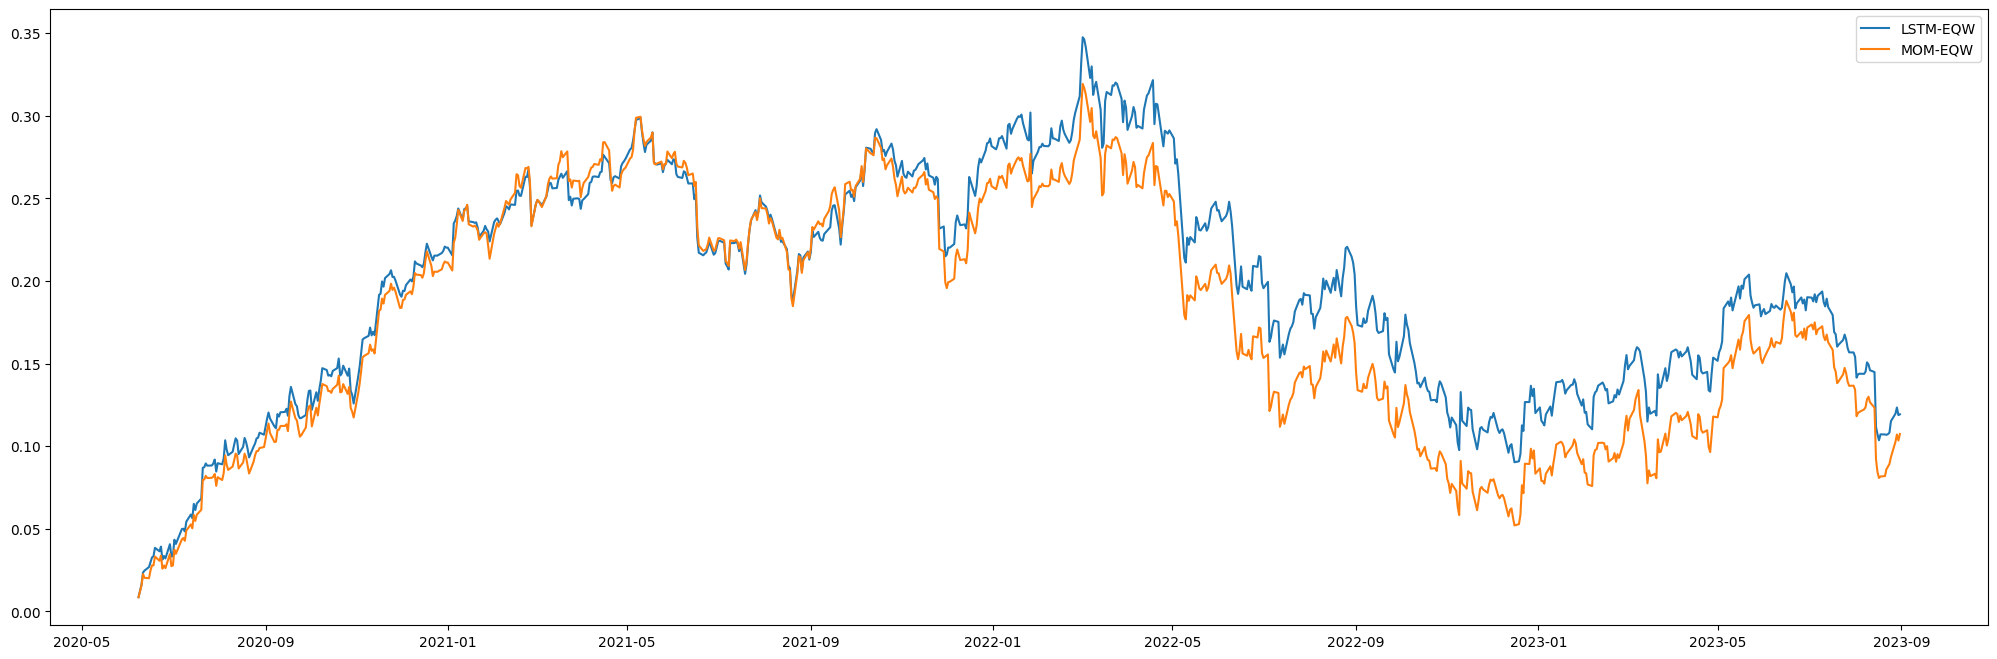

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(ret_lstm['Cum_ret'],label='LSTM-EQW')
plt.plot(ret_norm['Cum_ret'],label='MOM-EQW')
plt.legend()

In [ ]:
((1+ret_lstm['Cum_ret'][-2])**(252/len(ret_lstm))-1)


0.0341869342891139

In [ ]:
((1+ret_norm['Cum_ret'][-2])**(252/len(ret_norm))-1)

0.030899385589471473

In [ ]:
sig=pd.DataFrame(scaler.inverse_transform(predictions))
ind=data1.iloc[int(0.85*len(data1)):].index
sig.index=ind

In [ ]:
sig.columns=['LSTM Signal']
sig.min()

LSTM Signal   -3.81819
dtype: float32

In [ ]:
data2=data1.iloc[int(0.85*len(data1)):,:]
data2=pd.concat([data2,sig],axis=1)
data2['SF1 Curncy']=data2['SF1 Curncy'].shift(-1)
data2['Strat']=data2['Strat'].shift(-1)
data2

Final Signal  Roll_Win_Ratio  SF1 Curncy     Strat  LSTM Signal
2020-06-08      0.364822            0.45    0.005483  0.002000    -0.081816
2020-06-09      0.428066            0.50    0.006984  0.002989     2.013830
2020-06-10      0.502983            0.50    0.006745  0.003393     0.109419
2020-06-11      1.089114            0.55    0.000472  0.000514     0.057945
2020-06-12      0.787706            0.60   -0.011790 -0.009287     0.246148
...                  ...             ...         ...       ...          ...
2023-08-28      2.567343            0.45   -0.000088 -0.000226    -0.856570
2023-08-29      2.585724            0.45    0.005776  0.014936    -0.301401
2023-08-30      2.571705            0.50    0.000263  0.000676     0.000495
2023-08-31      2.849734            0.55   -0.006005 -0.017111     1.997060
2023-09-01      2.199900            0.50         NaN       NaN    -0.476540

[845 rows x 5 columns]

In [ ]:
((np.cumprod(1+data2['SF1 Curncy']*data2['LSTM Signal']))[-2]**(252/len(data2))-1)/((data2['SF1 Curncy']*data2['LSTM Signal']).std()*np.sqrt(252))

-0.012197783839294596

In [ ]:
!pip install dash-ag-grid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 29.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.0.0
    Uninstalling Werkzeug-3.0.0:
      Successfully uninstalled Werkzeug-3.0.0


In [ ]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
from dash_ag_grid import AgGrid
import plotly.graph_objects as go

# Sample data (replace this with your actual data)


app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='ticker-dropdown',
        options=[{'label': ticker, 'value': ticker} for ticker in signals3.keys()],
        value=next(iter(signals3)),  # Default ticker
    ),
    dcc.RadioItems(
        id='plot-selector',
        options=[
            {'label': 'Signal', 'value': 'Signal'},
            {'label': 'Returns', 'value': 'Returns'}
        ]),
    html.Div(id='graphs-container'),

    html.Div(id='display-grid')
])

@app.callback(
    [Output('graphs-container', 'children'),
     Output('display-grid', 'children')],
    [Input('ticker-dropdown', 'value'),
     Input('plot-selector', 'value')]
)

def update_graphs(ticker,selected_plot):
    df = signals3[ticker]

    graphs = []
    graphs2=[]
    if selected_plot == 'Signal':
      for col in ['Final Signal', 'Roll_Win_Ratio', 'LSTM Signal']:
        trace1 = go.Scatter(x=df.index, y=df[col], mode='lines+markers', name=col)
        trace2=go.Scatter(x=df.index, y=df['Roll_Win_Ratio'], mode='lines+markers', name='Roll_Win_ratio')
        data=[trace1,trace2]
        layout = go.Layout(title=f'{col} Chart for {ticker}', xaxis_title='Date', yaxis_title=col)
        graph = dcc.Graph(figure={'data': data, 'layout': layout})
        graphs.append(graph)
    elif selected_plot == 'Returns':
      for col in [f'{ticker}_LSTM_Strat', f'{ticker}_Strat', 'LSTM Signal']:
        trace = go.Scatter(x=df.index, y=df[col], mode='lines+markers', name=col)
        layout = go.Layout(title=f'{col} Chart for {ticker}', xaxis_title='Date', yaxis_title=col)
        graph = dcc.Graph(figure={'data': [trace], 'layout': layout})
        graphs.append(graph)


    ag_grid_data = df.reset_index().to_dict('records')
    ag_grid = AgGrid(
        id='ag-grid',
        columnDefs=[
            {'headerName': col, 'field': col} for col in df.columns
        ],
        rowData=ag_grid_data,
        style={'height': '300px'}  # Set the height of the grid
    )

    return graphs, ag_grid

if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [ ]:

trades_dict = {
'type':['irs'],
"ссу" :['HUF'],
"Generator":['HUF BUBOR A 6M*'],
"TradeId": [1],
'MtyTnr': ['5y'],
"Strike": ['a'],
'PayoutType' :['pay'],
'Nominal (m)': [100],
'SwaptionSettleTy': ['C'],
'CollateralCcy': ['USD'],
'UnderlyingClearingHouse': [None],
'SMMInstrument': ['irs'],
'PaySettleType': ['5'],
'SwaptionSettleType': ['Cash'],
'GeneratorInput': ['HUF BUBOR A 6M*'],
'StrikeDate': [40902.00],
'Nominal': [10**8]
}
trades_df = pd.DataFrame (trades_dict)
trades_df

type  ссу        Generator  TradeId MtyTnr Strike PayoutType  Nominal (m)  \
0  irs  HUF  HUF BUBOR A 6M*        1     5y      a        pay          100   

  SwaptionSettleTy CollateralCcy UnderlyingClearingHouse SMMInstrument  \
0                C           USD                    None           irs   

  PaySettleType SwaptionSettleType   GeneratorInput  StrikeDate    Nominal  
0             5               Cash  HUF BUBOR A 6M*     40902.0  100000000

In [ ]:
x=[252*5]*21
y=[0]*21
for i in range(21):
  y[i]=(x[i]-i)/252
y

[5.0,
 4.996031746031746,
 4.992063492063492,
 4.988095238095238,
 4.984126984126984,
 4.98015873015873,
 4.976190476190476,
 4.972222222222222,
 4.968253968253968,
 4.964285714285714,
 4.9603174603174605,
 4.9563492063492065,
 4.9523809523809526,
 4.948412698412699,
 4.944444444444445,
 4.940476190476191,
 4.936507936507937,
 4.932539682539683,
 4.928571428571429,
 4.924603174603175,
 4.920634920634921]

In [ ]:
def datetime_to_excel_serial_date(date):
    excel_base_date = datetime.date(1899, 12, 30)  # Excel's base date is December 30, 1899
    delta = date - excel_base_date
    excel_serial_date = delta.days + delta.seconds / (24 * 60 * 60)  # Include fraction of a day
    return excel_serial_date

In [ ]:
final_df=pd.DataFrame()
count=0
#DataFrame generally has the ids for different tenors
start_date=datetime.date(2011,1,2)
for i in range(2):
  for j in y:#y has the maturities in years
    trades_df =pd.DataFrame({
        'type':['irs'],
        "ссу" :['HUF'],
        "Generator":['HUF BUBOR A 6M*'],
        "TradeId": [1],
        'MtyTnr': [f'{j}y'],
        "Strike": ['a'],
        'PayoutType' :['pay'],
        'Nominal (m)': [100],
        'SwaptionSettleTy': ['C'],
        'CollateralCcy': ['USD'],
        'UnderlyingClearingHouse': [None],
        'SMMInstrument': ['irs'],
        'PaySettleType': ['5'],
        'SwaptionSettleType': ['Cash'],
        'GeneratorInput': ['HUF BUBOR A 6M*'],
        'StrikeDate': [datetime_to_excel_serial_date(start_date)],
        'Nominal': [10**8]
        })
    final_df=pd.concat([final_df,trades_df])
    count=count+1
  #You need a list of dates to match with the tenor So you begin with the dates and store it in the dataframe along with the tenor
  if count%21==0:
    start_date=(start_date+pd.tseries.offsets.BusinessDay(n = 21)).date()

final_df=final_df.reset_index(drop=True)

In [ ]:
xlrd.xldate_as_datetime(40574.0	, 0)-xlrd.xldate_as_datetime(40545.0	, 0)

datetime.timedelta(days=29)

In [ ]:
import xlrd
for i in final_df['StrikeDate'].unique():
  xlrd.xldate_as_datetime(i, 0).date()




2011-01-02
2011-06-27
2011-12-20
2012-06-13
2012-12-06
2013-05-31
2013-11-25
2014-05-20
2014-11-12
2015-05-07
2015-10-30
2016-04-25
2016-10-18
2017-04-12
2017-10-05
2018-03-30
2018-09-24
2019-03-19
2019-09-11
2020-03-05
2020-08-28
2021-02-22
2021-08-17
2022-02-09


In [ ]:
start_dates=[0]*3048
end_dates=[0]*3048
start_date1=datetime.date(2011,1,2)
for i in range(3048):
  start_dates[i]=start_date1
  end_dates[i]=start_date1+pd.tseries.offsets.BusinessDay(n = 1)#Adding one business day
  start_date1=start_date1+pd.tseries.offsets.BusinessDay(n = 1)#resetting the start date to next business day

start_dates=pd.DataFrame(start_dates)
start_dates.columns=['Start_Date']
end_dates=pd.DataFrame(end_dates)
end_dates.columns=['End_Date']


final_df=final_df.reset_index(drop=True)
final_df=pd.concat([final_df,start_dates],axis=1)
final_df=pd.concat([final_df,end_dates],axis=1)
final_df

type  ссу        Generator  TradeId              MtyTnr Strike  \
0     irs  HUF  HUF BUBOR A 6M*        1                5.0y      a   
1     irs  HUF  HUF BUBOR A 6M*        1  4.996031746031746y      a   
2     irs  HUF  HUF BUBOR A 6M*        1  4.992063492063492y      a   
3     irs  HUF  HUF BUBOR A 6M*        1  4.988095238095238y      a   
4     irs  HUF  HUF BUBOR A 6M*        1  4.984126984126984y      a   
...   ...  ...              ...      ...                 ...    ...   
3043  irs  HUF  HUF BUBOR A 6M*        1  4.515873015873016y      a   
3044  irs  HUF  HUF BUBOR A 6M*        1  4.511904761904762y      a   
3045  irs  HUF  HUF BUBOR A 6M*        1  4.507936507936508y      a   
3046  irs  HUF  HUF BUBOR A 6M*        1  4.503968253968254y      a   
3047  irs  HUF  HUF BUBOR A 6M*        1                4.5y      a   

     PayoutType  Nominal (m) SwaptionSettleTy CollateralCcy  \
0           pay          100                C           USD   
1           pay          100                C           USD   
2           pay          100                C           USD   
3           pay          100                C           USD   
4           pay          100                C           USD   
...         ...          ...              ...           ...   
3043        pay          100                C           USD   
3044        pay          100                C           USD   
3045        pay          100                C           USD   
3046        pay          100                C           USD   
3047        pay          100                C           USD   

     UnderlyingClearingHouse SMMInstrument PaySettleType SwaptionSettleType  \
0                       None           irs             5               Cash   
1                       None           irs             5               Cash   
2                       None           irs             5               Cash   
3                       None           irs             5               Cash   
4                       None           irs             5               Cash   
...                      ...           ...           ...                ...   
3043                    None           irs             5               Cash   
3044                    None           irs             5               Cash   
3045                    None           irs             5               Cash   
3046                    None           irs             5               Cash   
3047                    None           irs             5               Cash   

       GeneratorInput  StrikeDate    Nominal Start_Date   End_Date  
0     HUF BUBOR A 6M*     40545.0  100000000 2011-01-02 2011-01-03  
1     HUF BUBOR A 6M*     40545.0  100000000 2011-01-03 2011-01-04  
2     HUF BUBOR A 6M*     40545.0  100000000 2011-01-04 2011-01-05  
3     HUF BUBOR A 6M*     40545.0  100000000 2011-01-05 2011-01-06  
4     HUF BUBOR A 6M*     40545.0  100000000 2011-01-06 2011-01-07  
...               ...         ...        ...        ...        ...  
3043  HUF BUBOR A 6M*     44601.0  100000000 2022-08-31 2022-09-01  
3044  HUF BUBOR A 6M*     44601.0  100000000 2022-09-01 2022-09-02  
3045  HUF BUBOR A 6M*     44601.0  100000000 2022-09-02 2022-09-05  
3046  HUF BUBOR A 6M*     44601.0  100000000 2022-09-05 2022-09-06  
3047  HUF BUBOR A 6M*     44601.0  100000000 2022-09-06 2022-09-07  

[3048 rows x 19 columns]

In [ ]:
final_df.iloc[127:254,:]

type  ссу        Generator  TradeId              MtyTnr Strike PayoutType  \
127  irs  HUF  HUF BUBOR A 6M*        1                5.0y      a        pay   
128  irs  HUF  HUF BUBOR A 6M*        1  4.996031746031746y      a        pay   
129  irs  HUF  HUF BUBOR A 6M*        1  4.992063492063492y      a        pay   
130  irs  HUF  HUF BUBOR A 6M*        1  4.988095238095238y      a        pay   
131  irs  HUF  HUF BUBOR A 6M*        1  4.984126984126984y      a        pay   
..   ...  ...              ...      ...                 ...    ...        ...   
249  irs  HUF  HUF BUBOR A 6M*        1  4.515873015873016y      a        pay   
250  irs  HUF  HUF BUBOR A 6M*        1  4.511904761904762y      a        pay   
251  irs  HUF  HUF BUBOR A 6M*        1  4.507936507936508y      a        pay   
252  irs  HUF  HUF BUBOR A 6M*        1  4.503968253968254y      a        pay   
253  irs  HUF  HUF BUBOR A 6M*        1                4.5y      a        pay   

     Nominal (m) SwaptionSettleTy CollateralCcy UnderlyingClearingHouse  \
127          100                C           USD                    None   
128          100                C           USD                    None   
129          100                C           USD                    None   
130          100                C           USD                    None   
131          100                C           USD                    None   
..           ...              ...           ...                     ...   
249          100                C           USD                    None   
250          100                C           USD                    None   
251          100                C           USD                    None   
252          100                C           USD                    None   
253          100                C           USD                    None   

    SMMInstrument PaySettleType SwaptionSettleType   GeneratorInput  \
127           irs             5               Cash  HUF BUBOR A 6M*   
128           irs             5               Cash  HUF BUBOR A 6M*   
129           irs             5               Cash  HUF BUBOR A 6M*   
130           irs             5               Cash  HUF BUBOR A 6M*   
131           irs             5               Cash  HUF BUBOR A 6M*   
..            ...           ...                ...              ...   
249           irs             5               Cash  HUF BUBOR A 6M*   
250           irs             5               Cash  HUF BUBOR A 6M*   
251           irs             5               Cash  HUF BUBOR A 6M*   
252           irs             5               Cash  HUF BUBOR A 6M*   
253           irs             5               Cash  HUF BUBOR A 6M*   

     StrikeDate    Nominal Start_Date   End_Date  
127     40721.0  100000000 2011-06-28 2011-06-29  
128     40721.0  100000000 2011-06-29 2011-06-30  
129     40721.0  100000000 2011-06-30 2011-07-01  
130     40721.0  100000000 2011-07-01 2011-07-04  
131     40721.0  100000000 2011-07-04 2011-07-05  
..          ...        ...        ...        ...  
249     40721.0  100000000 2011-12-15 2011-12-16  
250     40721.0  100000000 2011-12-16 2011-12-19  
251     40721.0  100000000 2011-12-19 2011-12-20  
252     40721.0  100000000 2011-12-20 2011-12-21  
253     40721.0  100000000 2011-12-21 2011-12-22  

[127 rows x 19 columns]

In [ ]:
import xlrd
pd.Series(final_df['StrikeDate'].unique()).apply(lambda x:xlrd.xldate_as_datetime(x, 0))

0    2011-01-02
1    2011-06-27
2    2011-12-20
3    2012-06-13
4    2012-12-06
5    2013-05-31
6    2013-11-25
7    2014-05-20
8    2014-11-12
9    2015-05-07
10   2015-10-30
11   2016-04-25
12   2016-10-18
13   2017-04-12
14   2017-10-05
15   2018-03-30
16   2018-09-24
17   2019-03-19
18   2019-09-11
19   2020-03-05
20   2020-08-28
21   2021-02-22
22   2021-08-17
23   2022-02-09
dtype: datetime64[ns]

In [ ]:
for i

In [ ]:
final_df['StrikeDate'].unique()

array([40545., 40721., 40897., 41073., 41249., 41425., 41603., 41779.,
       41955., 42131., 42307., 42485., 42661., 42837., 43013., 43189.,
       43367., 43543., 43719., 43895., 44071., 44249., 44425., 44601.])

In [ ]:
for i in range(len(final_df)):
  x=pd.DataFrame(final_df.iloc[i,:17])
  start_date=final_df.iloc[i,17]
  end_date=final_df.iloc[i,18]



In [ ]:
start_dates=[0]*22
end_dates=[0]*22
for i in range(22):
    if i%21==0:
      start_dates[i]=(xlrd.xldate_as_datetime(final_df['StrikeDate'][i], 0))
    else:
      start_dates[i]+start_dates[i-1]+pd.tseries.offsets.BusinessDay(n = 1)
    end_dates[i]=start_dates[i]+pd.tseries.offsets.BusinessDay(n = 1)

start_dates

TypeError: ignored

In [ ]:
data = {'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
df = pd.DataFrame(data)

# Define the value to be added


# Find the nearest multiple of 21 greater than the current index
next_multiple_of_21 = ((final_df.index // 21) + 1) * 21

# Add the value up to the next multiple of 21
final_df['Nominal'][:next_multiple_of_21[0]] += value_to_add

final_df

<ipython-input-56-098b272914e6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Nominal'][:next_multiple_of_21[0]] += value_to_add


type  ссу        Generator  TradeId               MtyTnr Strike PayoutType  \
0   irs  HUF  HUF BUBOR A 6M*        1                 5.0y      a        pay   
1   irs  HUF  HUF BUBOR A 6M*        1   4.996031746031746y      a        pay   
2   irs  HUF  HUF BUBOR A 6M*        1   4.992063492063492y      a        pay   
3   irs  HUF  HUF BUBOR A 6M*        1   4.988095238095238y      a        pay   
4   irs  HUF  HUF BUBOR A 6M*        1   4.984126984126984y      a        pay   
5   irs  HUF  HUF BUBOR A 6M*        1    4.98015873015873y      a        pay   
6   irs  HUF  HUF BUBOR A 6M*        1   4.976190476190476y      a        pay   
7   irs  HUF  HUF BUBOR A 6M*        1   4.972222222222222y      a        pay   
8   irs  HUF  HUF BUBOR A 6M*        1   4.968253968253968y      a        pay   
9   irs  HUF  HUF BUBOR A 6M*        1   4.964285714285714y      a        pay   
10  irs  HUF  HUF BUBOR A 6M*        1  4.9603174603174605y      a        pay   
11  irs  HUF  HUF BUBOR A 6M*        1  4.9563492063492065y      a        pay   
12  irs  HUF  HUF BUBOR A 6M*        1  4.9523809523809526y      a        pay   
13  irs  HUF  HUF BUBOR A 6M*        1   4.948412698412699y      a        pay   
14  irs  HUF  HUF BUBOR A 6M*        1   4.944444444444445y      a        pay   
15  irs  HUF  HUF BUBOR A 6M*        1   4.940476190476191y      a        pay   
16  irs  HUF  HUF BUBOR A 6M*        1   4.936507936507937y      a        pay   
17  irs  HUF  HUF BUBOR A 6M*        1   4.932539682539683y      a        pay   
18  irs  HUF  HUF BUBOR A 6M*        1   4.928571428571429y      a        pay   
19  irs  HUF  HUF BUBOR A 6M*        1   4.924603174603175y      a        pay   
20  irs  HUF  HUF BUBOR A 6M*        1   4.920634920634921y      a        pay   
21  irs  HUF  HUF BUBOR A 6M*        1                 5.0y      a        pay   
22  irs  HUF  HUF BUBOR A 6M*        1   4.996031746031746y      a        pay   
23  irs  HUF  HUF BUBOR A 6M*        1   4.992063492063492y      a        pay   
24  irs  HUF  HUF BUBOR A 6M*        1   4.988095238095238y      a        pay   
25  irs  HUF  HUF BUBOR A 6M*        1   4.984126984126984y      a        pay   
26  irs  HUF  HUF BUBOR A 6M*        1    4.98015873015873y      a        pay   
27  irs  HUF  HUF BUBOR A 6M*        1   4.976190476190476y      a        pay   
28  irs  HUF  HUF BUBOR A 6M*        1   4.972222222222222y      a        pay   
29  irs  HUF  HUF BUBOR A 6M*        1   4.968253968253968y      a        pay   
30  irs  HUF  HUF BUBOR A 6M*        1   4.964285714285714y      a        pay   
31  irs  HUF  HUF BUBOR A 6M*        1  4.9603174603174605y      a        pay   
32  irs  HUF  HUF BUBOR A 6M*        1  4.9563492063492065y      a        pay   
33  irs  HUF  HUF BUBOR A 6M*        1  4.9523809523809526y      a        pay   
34  irs  HUF  HUF BUBOR A 6M*        1   4.948412698412699y      a        pay   
35  irs  HUF  HUF BUBOR A 6M*        1   4.944444444444445y      a        pay   
36  irs  HUF  HUF BUBOR A 6M*        1   4.940476190476191y      a        pay   
37  irs  HUF  HUF BUBOR A 6M*        1   4.936507936507937y      a        pay   
38  irs  HUF  HUF BUBOR A 6M*        1   4.932539682539683y      a        pay   
39  irs  HUF  HUF BUBOR A 6M*        1   4.928571428571429y      a        pay   
40  irs  HUF  HUF BUBOR A 6M*        1   4.924603174603175y      a        pay   
41  irs  HUF  HUF BUBOR A 6M*        1   4.920634920634921y      a        pay   

    Nominal (m) SwaptionSettleTy CollateralCcy UnderlyingClearingHouse  \
0           100                C           USD                    None   
1           100                C           USD                    None   
2           100                C           USD                    None   
3           100                C           USD                    None   
4           100                C           USD                    None   
5           100                C           USD                    None   
6

In [ ]:
((final_df.index // 21) + 1) * 21

Int64Index([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
            21, 21, 21, 21, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
            42, 42, 42, 42, 42, 42, 42, 42],
           dtype='int64')

In [ ]:
data = {'A': range(1, 253)}
df = pd.DataFrame(data)
df.head(23)

A
0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
8    9
9   10
10  11
11  12
12  13
13  14
14  15
15  16
16  17
17  18
18  19
19  20
20  21
21  22
22  23

In [ ]:

# Define the value to be added


# Iterate through the indices
for i in range(0, len(df), 20):
    if i > 0:
        next_multiple = min(i + 20, len(df))
        print(next_multiple) # Ensure we don't go beyond the end of the DataFrame
        df['A'][i:next_multiple] += df['A'][i-1]
df.head(23)

40
60
80
100
120
140
160
180
200
220
240
252


A
0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
8    9
9   10
10  11
11  12
12  13
13  14
14  15
15  16
16  17
17  18
18  19
19  20
20  41
21  42
22  43

In [ ]:
df.head(60)

A
0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
10   11
11   12
12   13
13   14
14   15
15   16
16   17
17   18
18   19
19   20
20   41
21   42
22   43
23   44
24   45
25   46
26   47
27   48
28   49
29   50
30   51
31   52
32   53
33   54
34   55
35   56
36   57
37   58
38   59
39   60
40  101
41  102
42  103
43  104
44  105
45  106
46  107
47  108
48  109
49  110
50  111
51  112
52  113
53  114
54  115
55  116
56  117
57  118
58  119
59  120

In [ ]:
[range(0, len(df), 21)]

[range(0, 252, 21)]

In [ ]:
final_df=final_df.reset_index(drop=True)
final_df=pd.concat([final_df,start_dates],axis=1)
final_df=pd.concat([final_df,end_dates],axis=1)
final_df

type  ссу        Generator  TradeId              MtyTnr Strike  \
0     irs  HUF  HUF BUBOR A 6M*        1                5.0y      a   
1     irs  HUF  HUF BUBOR A 6M*        1  4.996031746031746y      a   
2     irs  HUF  HUF BUBOR A 6M*        1  4.992063492063492y      a   
3     irs  HUF  HUF BUBOR A 6M*        1  4.988095238095238y      a   
4     irs  HUF  HUF BUBOR A 6M*        1  4.984126984126984y      a   
...   ...  ...              ...      ...                 ...    ...   
3043  irs  HUF  HUF BUBOR A 6M*        1  4.515873015873016y      a   
3044  irs  HUF  HUF BUBOR A 6M*        1  4.511904761904762y      a   
3045  irs  HUF  HUF BUBOR A 6M*        1  4.507936507936508y      a   
3046  irs  HUF  HUF BUBOR A 6M*        1  4.503968253968254y      a   
3047  irs  HUF  HUF BUBOR A 6M*        1                4.5y      a   

     PayoutType  Nominal (m) SwaptionSettleTy CollateralCcy  ...  \
0           pay          100                C           USD  ...   
1           pay          100                C           USD  ...   
2           pay          100                C           USD  ...   
3           pay          100                C           USD  ...   
4           pay          100                C           USD  ...   
...         ...          ...              ...           ...  ...   
3043        pay          100                C           USD  ...   
3044        pay          100                C           USD  ...   
3045        pay          100                C           USD  ...   
3046        pay          100                C           USD  ...   
3047        pay          100                C           USD  ...   

     SMMInstrument PaySettleType SwaptionSettleType   GeneratorInput  \
0              irs             5               Cash  HUF BUBOR A 6M*   
1              irs             5               Cash  HUF BUBOR A 6M*   
2              irs             5               Cash  HUF BUBOR A 6M*   
3              irs             5               Cash  HUF BUBOR A 6M*   
4              irs             5               Cash  HUF BUBOR A 6M*   
...            ...           ...                ...              ...   
3043           irs             5               Cash  HUF BUBOR A 6M*   
3044           irs             5               Cash  HUF BUBOR A 6M*   
3045           irs             5               Cash  HUF BUBOR A 6M*   
3046           irs             5               Cash  HUF BUBOR A 6M*   
3047           irs             5               Cash  HUF BUBOR A 6M*   

     StrikeDate    Nominal Start_Date   End_Date Start_Date   End_Date  
0       40545.0  100000000 2011-01-02 2011-01-03 2012-01-01 2012-01-02  
1       40545.0  100000000 2011-01-03 2011-01-04 2012-01-02 2012-01-03  
2       40545.0  100000000 2011-01-04 2011-01-05 2012-01-03 2012-01-04  
3       40545.0  100000000 2011-01-05 2011-01-06 2012-01-04 2012-01-05  
4       40545.0  100000000 2011-01-06 2011-01-07 2012-01-05 2012-01-06  
...         ...        ...        ...        ...        ...        ...  
3043    44601.0  100000000 2022-08-31 2022-09-01        NaT        NaT  
3044    44601.0  100000000 2022-09-01 2022-09-02        NaT        NaT  
3045    44601.0  100000000 2022-09-02 2022-09-05        NaT        NaT  
3046    44601.0  100000000 2022-09-05 2022-09-06        NaT        NaT  
3047    44601.0  100000000 2022-09-06 2022-09-07        NaT        NaT  

[3048 rows x 21 columns]

In [ ]:
data = {'A': range(1, 253)}
df = pd.DataFrame(data)
df.index=df.index+1
df.head(21)

A
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
10  10
11  11
12  12
13  13
14  14
15  15
16  16
17  17
18  18
19  19
20  20
21  21

In [ ]:
dame={}
for i in range(1,12,1):
  dame[i]=df.loc[(df.index<(i)*21)]
     #Add 'sample' df instead of df
  if i>1:
    dame[i]=df.loc[(df.index>=(i-1)*21)&(df.index<(i)*21)]
    dame[i].loc[:,'Value']+=dame[i]+dame[i-1].loc[:,'Value'].iloc[-1]



KeyError: ignored

In [ ]:
dame[i].loc[:,'A']+=dame[i].loc[:,'A']+dame[i-1].iloc[-1].A

1375

In [ ]:
sample=pd.DataFrame({'Date':['2020-01-27','2020-01-28','2020-01-29','2020-01-30','2020-01-31','2020-02-03','2020-02-04'],
                     'Value':[18843.97,424633.557,197705.091,-36219.65,-103417.615,40377.444,342169]})
sample

Date       Value
0  2020-01-27   18843.970
1  2020-01-28  424633.557
2  2020-01-29  197705.091
3  2020-01-30  -36219.650
4  2020-01-31 -103417.615
5  2020-02-03   40377.444
6  2020-02-04  342169.000

In [ ]:
sample.Date=pd.to_datetime(sample.Date)
sample=sample.set_index("Date")

In [ ]:
sample=pd.concat([sample,sample])
sample=pd.concat([sample,sample])
sample=pd.concat([sample,sample])
sample=pd.concat([sample,sample])
sample

Value
Date                  
2020-01-27   18843.970
2020-01-28  424633.557
2020-01-29  197705.091
2020-01-30  -36219.650
2020-01-31 -103417.615
...                ...
2020-01-29  197705.091
2020-01-30  -36219.650
2020-01-31 -103417.615
2020-02-03   40377.444
2020-02-04  342169.000

[112 rows x 1 columns]

In [ ]:
sample=sample.reset_index(drop=True)
sample

Date       Value
0   2020-01-27   18843.970
1   2020-01-28  424633.557
2   2020-01-29  197705.091
3   2020-01-30  -36219.650
4   2020-01-31 -103417.615
..         ...         ...
107 2020-01-29  197705.091
108 2020-01-30  -36219.650
109 2020-01-31 -103417.615
110 2020-02-03   40377.444
111 2020-02-04  342169.000

[112 rows x 2 columns]

In [ ]:
sample=sample.reset_index(drop=True)
sample.index=sample.index+1
sample

Date       Value
1   2020-01-27   18843.970
2   2020-01-28  424633.557
3   2020-01-29  197705.091
4   2020-01-30  -36219.650
5   2020-01-31 -103417.615
..         ...         ...
108 2020-01-29  197705.091
109 2020-01-30  -36219.650
110 2020-01-31 -103417.615
111 2020-02-03   40377.444
112 2020-02-04  342169.000

[112 rows x 2 columns]

In [ ]:
sample.loc[[21,42,63,84,105],'Value']=0
sample

Date       Value
1   2020-01-27   18843.970
2   2020-01-28  424633.557
3   2020-01-29  197705.091
4   2020-01-30  -36219.650
5   2020-01-31 -103417.615
..         ...         ...
108 2020-01-29  197705.091
109 2020-01-30  -36219.650
110 2020-01-31 -103417.615
111 2020-02-03   40377.444
112 2020-02-04  342169.000

[112 rows x 2 columns]

In [ ]:
sample.head(63)

Date       Value
1  2020-01-27   18843.970
2  2020-01-28  424633.557
3  2020-01-29  197705.091
4  2020-01-30  -36219.650
5  2020-01-31 -103417.615
..        ...         ...
59 2020-01-29  197705.091
60 2020-01-30  -36219.650
61 2020-01-31 -103417.615
62 2020-02-03   40377.444
63 2020-02-04       0.000

[63 rows x 2 columns]

In [ ]:
sample=sample.reset_index()
sample.index=sample.index+1
dame={}
for i in range(1,6,1):
  dame[i]=sample.loc[(sample.index<(i)*21)]
     #Add 'sample' sample instead of sample
  if i>1:
    dame[i]=sample.loc[(sample.index>=(i-1)*21)&(sample.index<(i)*21)]
    print(dame[i-1].iloc[-1].Value)
    dame[i].loc[:,'Value']=dame[i].loc[:,'Value']+dame[i-1].iloc[-1].Value

40377.444
80754.888
121132.33200000001
161509.776


<ipython-input-264-996fa21a3ee5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dame[i].loc[:,'Value']=dame[i].loc[:,'Value']+dame[i-1].iloc[-1].Value


In [ ]:
dame[3]

Date       Value
42 2020-02-04   80754.888
43 2020-01-27   99598.858
44 2020-01-28  505388.445
45 2020-01-29  278459.979
46 2020-01-30   44535.238
47 2020-01-31  -22662.727
48 2020-02-03  121132.332
49 2020-02-04  422923.888
50 2020-01-27   99598.858
51 2020-01-28  505388.445
52 2020-01-29  278459.979
53 2020-01-30   44535.238
54 2020-01-31  -22662.727
55 2020-02-03  121132.332
56 2020-02-04  422923.888
57 2020-01-27   99598.858
58 2020-01-28  505388.445
59 2020-01-29  278459.979
60 2020-01-30   44535.238
61 2020-01-31  -22662.727
62 2020-02-03  121132.332

In [ ]:
sample.loc[42:63,:]

Date       Value
42 2020-02-04       0.000
43 2020-01-27   18843.970
44 2020-01-28  424633.557
45 2020-01-29  197705.091
46 2020-01-30  -36219.650
47 2020-01-31 -103417.615
48 2020-02-03   40377.444
49 2020-02-04  342169.000
50 2020-01-27   18843.970
51 2020-01-28  424633.557
52 2020-01-29  197705.091
53 2020-01-30  -36219.650
54 2020-01-31 -103417.615
55 2020-02-03   40377.444
56 2020-02-04  342169.000
57 2020-01-27   18843.970
58 2020-01-28  424633.557
59 2020-01-29  197705.091
60 2020-01-30  -36219.650
61 2020-01-31 -103417.615
62 2020-02-03   40377.444
63 2020-02-04       0.000